# **CellTracksColab - TrackMate - Plate**
---

<font size = 4>Colab Notebook for Analyzing Migration Tracks generated by [TrackMate](https://imagej.net/plugins/trackmate/). This notebook is particularly suited for handling and interpreting data structured in a plate format, commonly produced by incubator microscopes like Incucytes.


<font size = 4>Notebook created by [Guillaume Jacquemet](https://cellmig.org/)


# **Part 0. Before getting started**
---

<font size = 5>**Important notes**

---
## Data Requirements for Analysis

<font size = 4>Be advised of one significant limitation inherent to this notebook.

<font size = 4 color="red">**Part2 does not support Track splitting**</font>. <font size = 4>For users aiming to compute additional track metrics within this environment, it is crucial to disable track splitting in TrackMate.

<font size = 4>It’s important to clarify that the absence of track splitting support does not hinder the notebook's ability to compile and display results in part 3 of the analysis process.

---

## Data Organization

### Overview

To ensure smooth processing and analysis of your tracking data using TrackMate outputs, it is crucial to organize your files in a specific structure. This organization allows for automated identification and loading of relevant files, enabling efficient data handling.

### File Naming Conventions

Your files should follow a consistent naming scheme that includes the well number and the field of view (FOV) number. This approach facilitates the differentiation of various experimental conditions and replicates. Ensure that:

- Track files end with `-tracks.csv`.
- Spot tables end with `-spots`.

### File Structure

Organize your files in a single folder, ideally named to reflect the experiment or dataset. Here's an example of a well-structured data directory:

- 📁 **Experiments** `[Folder_path]`
  - 📄 `B02_01_tracking-spots.csv`
  - 📄 `B02_01_tracking-tracks.csv`
  - 📄 `B02_02_tracking-spots.csv`
  - 📄 `B02_02_tracking-tracks.csv`
  - 📄 `B03_01_tracking-spots.csv`
  - 📄 `B03_01_tracking-tracks.csv`
  - 📄 `B03_02_tracking-spots.csv`
  - 📄 `B03_02_tracking-tracks.csv`  

In this structure:
- `B02`, `B03`, etc., represent the well numbers.
- `01`, `02`, etc., indicate the field of view numbers.

### Data Interpretation

By default, the system interprets:
- **Well Number**: Represents different experimental conditions.
- **Field of View Number**: Acts as a repeat for each condition.

### Custom Mapping

You have the flexibility to map well numbers to specific experimental conditions. This mapping can be done in a designated cell within the notebook.





In [ ]:
# @title #MIT License

print("""
**MIT License**

Copyright (c) 2023 Guillaume Jacquemet

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.""")

--------------------------------------------------------
# **Part 1. Prepare the session and load your data**
--------------------------------------------------------


## **1.1. Install key dependencies**
---
<font size = 4>

In [ ]:
#@markdown ##Play to install
!pip -q install pandas scikit-learn
!pip -q install hdbscan
!pip -q install umap-learn
!pip -q install plotly
!pip -q install tqdm

In [ ]:
#@markdown ##Play to load the dependancies

import ipywidgets as widgets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import itertools
from matplotlib.gridspec import GridSpec
import requests

# Current version of the notebook the user is running
current_version = "0.8"
Notebook_name = 'TrackMate_Plate'

# URL to the raw content of the version file in the repository
version_url = "https://raw.githubusercontent.com/guijacquemet/CellTracksColab/main/Notebook/latest_version.txt"

# Function to define colors for formatting messages
class bcolors:
    WARNING = '\033[91m'  # Red color for warning messages
    ENDC = '\033[0m'      # Reset color to default

# Check if this is the latest version of the notebook
try:
    All_notebook_versions = pd.read_csv(version_url, dtype=str)
    print('Notebook version: ' + current_version)

    # Check if 'Version' column exists in the DataFrame
    if 'Version' in All_notebook_versions.columns:
        Latest_Notebook_version = All_notebook_versions[All_notebook_versions["Notebook"] == Notebook_name]['Version'].iloc[0]
        print('Latest notebook version: ' + Latest_Notebook_version)

        if current_version == Latest_Notebook_version:
            print("This notebook is up-to-date.")
        else:
            print(bcolors.WARNING + "A new version of this notebook has been released. We recommend that you download it at https://github.com/guijacquemet/CellTracksColab" + bcolors.ENDC)
    else:
        print("The 'Version' column is not present in the version file.")
except requests.exceptions.RequestException as e:
    print("Unable to fetch the latest version information. Please check your internet connection.")
except Exception as e:
    print("An error occurred:", str(e))

#----------------------- Key functions -----------------------------#

# Function to calculate Cohen's d
def cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    pooled_var = ((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)
    d = diff / np.sqrt(pooled_var)
    return d

def save_dataframe_with_progress(df, path, desc="Saving", chunk_size=50000):
    """Save a DataFrame with a progress bar."""

    # Estimating the number of chunks based on the provided chunk size
    num_chunks = int(len(df) / chunk_size) + 1

    # Create a tqdm instance for progress tracking
    with tqdm(total=len(df), unit="rows", desc=desc) as pbar:
        # Open the file for writing
        with open(path, "w") as f:
            # Write the header once at the beginning
            df.head(0).to_csv(f, index=False)

            for chunk in np.array_split(df, num_chunks):
                chunk.to_csv(f, mode="a", header=False, index=False)
                pbar.update(len(chunk))

def check_for_nans(df, df_name):
    """
    Checks the given DataFrame for NaN values and prints the count for each column containing NaNs.

    Args:
    df (pd.DataFrame): DataFrame to be checked for NaN values.
    df_name (str): The name of the DataFrame as a string, used for printing.
    """
    # Check if the DataFrame has any NaN values and print a warning if it does.
    nan_columns = df.columns[df.isna().any()].tolist()

    if nan_columns:
        for col in nan_columns:
            nan_count = df[col].isna().sum()
            print(f"Column '{col}' in {df_name} contains {nan_count} NaN values.")
    else:
        print(f"No NaN values found in {df_name}.")


import pandas as pd
import os

def save_parameters(params, file_path, param_type):
    # Convert params dictionary to a DataFrame for human readability
    new_params_df = pd.DataFrame(list(params.items()), columns=['Parameter', 'Value'])
    new_params_df['Type'] = param_type

    if os.path.exists(file_path):
        # Read existing file
        existing_params_df = pd.read_csv(file_path)

        # Merge the new parameters with the existing ones
        # Update existing parameters or append new ones
        updated_params_df = pd.merge(existing_params_df, new_params_df,
                                     on=['Type', 'Parameter'],
                                     how='outer',
                                     suffixes=('', '_new'))

        # If there's a new value, update it, otherwise keep the old value
        updated_params_df['Value'] = updated_params_df['Value_new'].combine_first(updated_params_df['Value'])

        # Drop the temporary new value column
        updated_params_df.drop(columns='Value_new', inplace=True)
    else:
        # Use new parameters DataFrame directly if file doesn't exist
        updated_params_df = new_params_df

    # Save the updated DataFrame to CSV
    updated_params_df.to_csv(file_path, index=False)


## **1.2. Mount your Google Drive**
---
<font size = 4> To use this notebook on the data present in your Google Drive, you need to mount your Google Drive to this notebook.

<font size = 4> Play the cell below to mount your Google Drive and follow the instructions.

<font size = 4> Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive



## **1.3. Compile your data or load existing dataframes**
---

<font size = 4> Please ensure that your data is properly organised (see above)


In [ ]:
#@markdown ##Provide the path to your dataset:

#@markdown ###You have multiple TrackMate files you want to compile, provide the path to your:

import os
import re
import glob
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import requests
import zipfile

Folder_path = ''  # @param {type: "string"}

#@markdown ###You have existing dataframes, provide the path to your:

Track_table = ''  # @param {type: "string"}
Spot_table = ''  # @param {type: "string"}

#@markdown ###Provide the path to your Result folder

Results_Folder = ""  # @param {type: "string"}

if not Results_Folder:
    Results_Folder = '/content/Results'  # Default Results_Folder path if not defined

if not os.path.exists(Results_Folder):
    os.makedirs(Results_Folder)  # Create Results_Folder if it doesn't exist

# Print the location of the result folder
print(f"Result folder is located at: {Results_Folder}")

def populate_columns(df, filepath):
    # Extract the parts of the file path
    filename = os.path.basename(filepath)
    well_info = filename[0:3]
    fov_info = filename.split('_')[1]
    filename_without_extension = os.path.splitext(os.path.basename(filepath))[0]
    df['File_name'] = remove_suffix(filename_without_extension)
    # Add well and FOV information as new columns to the DataFrame
    df['Well'] = well_info
    df['FOV'] = fov_info

    df['Condition'] = well_info  # Populate 'Condition' with the parent folder name
    df['experiment_nb'] = fov_info  # Populate 'Repeat' with the folder name

    return df

def load_and_populate(file_pattern, usecols=None, chunksize=100000):
    df_list = []
    pattern = re.compile(file_pattern)  # Compile the file pattern to a regex object
    files_to_process = []

    # First, list all the files we'll be processing
    for dirpath, dirnames, filenames in os.walk(Folder_path):
        for filename in filenames:
            if pattern.match(filename):  # Check if the filename matches the file pattern
                filepath = os.path.join(dirpath, filename)
                files_to_process.append(filepath)

    # Metadata list
    metadata_list = []

    # Create a tqdm instance for progress tracking
    for filepath in tqdm(files_to_process, desc="Processing Files"):
        # Get the expected number of rows in the file (subtracting header rows)
        expected_rows = sum(1 for row in open(filepath)) - 4

        # Get file size
        file_size = os.path.getsize(filepath)

        # Add to the metadata list
        metadata_list.append({
            'filename': os.path.basename(filepath),
            'expected_rows': expected_rows,
            'file_size': file_size
        })

        chunked_reader = pd.read_csv(filepath, skiprows=[1, 2, 3], usecols=usecols, chunksize=chunksize)

        for chunk in chunked_reader:
            processed_chunk = populate_columns(chunk, filepath)
            df_list.append(processed_chunk)

    if not df_list:  # if df_list is empty, return an empty DataFrame
        print(f"No files found with pattern: {file_pattern}")
        return pd.DataFrame()

    merged_df = pd.concat(df_list, ignore_index=True)
    # Verify the total rows in the merged dataframe matches the total expected rows from metadata
    total_expected_rows = sum(item['expected_rows'] for item in metadata_list)
    if len(merged_df) != total_expected_rows:
      print(f"Warning: Mismatch in total rows. Expected {total_expected_rows}, found {len(merged_df)} in the merged dataframe.")
    else:
      print(f"Success: The processed dataframe matches the metadata. Total rows: {len(merged_df)}")
    return merged_df, metadata_list


def sort_and_generate_repeat(merged_df):
    merged_df.sort_values(['Condition', 'experiment_nb'], inplace=True)
    merged_df = merged_df.groupby('Condition', group_keys=False).apply(generate_repeat)
    return merged_df

def generate_repeat(group):
    unique_experiment_nbs = sorted(group['experiment_nb'].unique())
    experiment_nb_to_repeat = {experiment_nb: i+1 for i, experiment_nb in enumerate(unique_experiment_nbs)}
    group['Repeat'] = group['experiment_nb'].map(experiment_nb_to_repeat)
    return group

def remove_suffix(filename):
    suffixes_to_remove = ["-tracks", "-spots"]
    for suffix in suffixes_to_remove:
        if filename.endswith(suffix):
            filename = filename[:-len(suffix)]
            break
    return filename


def validate_tracks_df(df):
    """Validate the tracks dataframe for necessary columns and data types."""
    required_columns = ['TRACK_ID']
    for col in required_columns:
        if col not in df.columns:
            print(f"Error: Column '{col}' missing in tracks dataframe.")
            return False

    # Additional data type checks or value ranges can be added here
    return True

def validate_spots_df(df):
    """Validate the spots dataframe for necessary columns and data types."""
    required_columns = ['TRACK_ID', 'POSITION_X', 'POSITION_Y', 'POSITION_Z', 'POSITION_T']
    for col in required_columns:
        if col not in df.columns:
            print(f"Error: Column '{col}' missing in spots dataframe.")
            return False

    # Additional data type checks or value ranges can be added here
    return True

def check_unique_id_match(df1, df2):
    df1_ids = set(df1['Unique_ID'])
    df2_ids = set(df2['Unique_ID'])

    # Check if the IDs in the two dataframes match
    if df1_ids == df2_ids:
        print("The Unique_ID values in both dataframes match perfectly!")
    else:
        missing_in_df1 = df2_ids - df1_ids
        missing_in_df2 = df1_ids - df2_ids

        if missing_in_df1:
            print(f"There are {len(missing_in_df1)} Unique_ID values present in the second dataframe but missing in the first.")
            print("Examples of these IDs are:", list(missing_in_df1)[:5])

        if missing_in_df2:
            print(f"There are {len(missing_in_df2)} Unique_ID values present in the first dataframe but missing in the second.")
            print("Examples of these IDs are:", list(missing_in_df2)[:5])

if Folder_path:

    merged_tracks_df, tracks_metadata = load_and_populate(r'.*tracks.*\.csv')


    if not validate_tracks_df(merged_tracks_df):
        print("Error: Validation failed for merged tracks dataframe.")
    else:
        merged_tracks_df = sort_and_generate_repeat(merged_tracks_df)
        merged_tracks_df['Unique_ID'] = merged_tracks_df['File_name'] + "_" + merged_tracks_df['TRACK_ID'].astype(str)
        save_dataframe_with_progress(merged_tracks_df, Results_Folder + '/' + 'merged_Tracks.csv', desc="Saving Tracks")


    merged_spots_df, tracks_metadata = load_and_populate(r'.*spots.*\.csv')

    if not validate_spots_df(merged_spots_df):
        print("Error: Validation failed for merged spots dataframe.")
    else:
        merged_spots_df = sort_and_generate_repeat(merged_spots_df)
        merged_spots_df['Unique_ID'] = merged_spots_df['File_name'] + "_" + merged_spots_df['TRACK_ID'].astype(str)
        merged_spots_df.dropna(subset=['POSITION_X', 'POSITION_Y', 'POSITION_Z'], inplace=True)
        save_dataframe_with_progress(merged_spots_df, Results_Folder + '/' + 'merged_Spots.csv', desc="Saving Spots")
        # Now, call the check function
        check_unique_id_match(merged_spots_df, merged_tracks_df)
        print("...Done")

# For existing dataframes
if Track_table:
    print("Loading track table file....")
    merged_tracks_df = pd.read_csv(Track_table, low_memory=False)
    if not validate_tracks_df(merged_tracks_df):
        print("Error: Validation failed for loaded tracks dataframe.")

if Spot_table:
    print("Loading spot table file....")
    merged_spots_df = pd.read_csv(Spot_table, low_memory=False)
    if not validate_spots_df(merged_spots_df):
        print("Error: Validation failed for loaded spots dataframe.")


## **1.4. Mapping Wells to Conditions (optional)**
---

In this section of the notebook, conditions are defined based on user inputs, allowing for flexible and customized categorization of the experimental data.

*   When multiple wells are assigned the same condition, they are treated as repeats

*   Within each well, data from all fields of view are combined





In [ ]:
# @title ##Run to perform the mapping

import ipywidgets as widgets
from IPython.display import display
import pandas as pd

def generate_repeat(group):
    unique_experiment_nbs = sorted(group['Well'].unique())
    experiment_nb_to_repeat = {experiment_nb: i+1 for i, experiment_nb in enumerate(unique_experiment_nbs)}
    group['Repeat'] = group['Well'].map(experiment_nb_to_repeat)
    return group

def sort_and_generate_repeat(merged_df):
    merged_df.sort_values(['Condition', 'Well'], inplace=True)
    merged_df = merged_df.groupby('Condition', group_keys=False).apply(generate_repeat)
    return merged_df

# Create a Text widget for each well
well_widgets = {well: widgets.Text(description=f"Well {well}") for well in merged_tracks_df['Well'].unique()}

# Function to update dataframe with the input conditions
def update_conditions(button):
    global merged_tracks_df  # Add this line to use the global variable

    for well, widget in well_widgets.items():
        condition = widget.value.strip()  # Trim whitespace from the input
        if condition:  # Only update if a condition was entered
            merged_tracks_df.loc[merged_tracks_df['Well'] == well, 'Condition'] = condition
    print("Conditions updated.")  # Feedback to confirm the update
    merged_tracks_df = sort_and_generate_repeat(merged_tracks_df)

    print("Repeats updated.")  # Feedback to confirm the update
    save_dataframe_with_progress(merged_tracks_df, Results_Folder + '/' + 'merged_Tracks.csv', desc="Saving Tracks")
    check_for_nans(merged_tracks_df, "merged_tracks_df")

# Display the widgets
for widget in well_widgets.values():
    display(widget)

# Button to update the conditions
update_button = widgets.Button(description="Update Conditions")
update_button.on_click(update_conditions)
display(update_button)


## **1.5. Visualise your tracks**
---

In [ ]:
# @title ##Run the cell and choose the file you want to inspect

import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

if not os.path.exists(Results_Folder+"/Tracks"):
    os.makedirs(Results_Folder+"/Tracks")  # Create Results_Folder if it doesn't exist

# Extract unique filenames from the dataframe
filenames = merged_spots_df['File_name'].unique()

# Create a Dropdown widget with the filenames
filename_dropdown = widgets.Dropdown(
    options=filenames,
    value=filenames[0] if len(filenames) > 0 else None,  # Default selected value
    description='File Name:',
)

def plot_coordinates(filename):
    if filename:
        # Filter the DataFrame based on the selected filename
        filtered_df = merged_spots_df[merged_spots_df['File_name'] == filename]

        plt.figure(figsize=(10, 8))
        for unique_id in filtered_df['Unique_ID'].unique():
            unique_df = filtered_df[filtered_df['Unique_ID'] == unique_id].sort_values(by='POSITION_T')
            plt.plot(unique_df['POSITION_X'], unique_df['POSITION_Y'], marker='o', linestyle='-', markersize=2)

        plt.xlabel('POSITION_X')
        plt.ylabel('POSITION_Y')
        plt.title(f'Coordinates for {filename}')
        plt.savefig(f"{Results_Folder}/Tracks/Tracks_{filename}.pdf")
        plt.show()
    else:
        print("No valid filename selected")

# Link the Dropdown widget to the plotting function
interact(plot_coordinates, filename=filename_dropdown)


interactive(children=(Dropdown(description='File Name:', options=('Exp 1 20180126 ICAM 2', 'Exp 1 20180126 ICA…

<function __main__.plot_coordinates(filename)>

## **1.6. Filter and smooth your tracks (Optional)**
---


<font size = 4>The following section provides an interactive way to refine your tracking data. Here's what it's designed to achieve:

1. <font size = 4>**Filter Tracks**:
    - <font size = 4>This feature allows you to define a range for the track lengths you're interested in. By adjusting the `Min Length` and `Max Length` sliders, you can ignore very short or very long tracks that might be artifacts or noise in your data.

2. <font size = 4>**Smooth Tracks**:
    - <font size = 4>The positional data in your tracks can be smoothed using a moving average technique. By adjusting the `Smoothing` slider, you can control the degree of smoothing applied to the tracks. A higher value will average over more points, producing smoother tracks. This can be beneficial if your raw data has a lot of jitter or minor positional fluctuations.

<font size = 4>**How to Use**:

- <font size = 4>**Min Length**: Use the slider to set the minimum length of the tracks you're interested in.
- <font size = 4>**Max Length**: Use the slider to set the maximum length of the tracks you're interested in.
- <font size = 4>**Smoothing**: Adjust this slider to control the degree of smoothing you'd like to apply to your tracks.
- <font size = 4>**Apply Filters**: After adjusting the sliders to your preference, click this button. This will process the data based on your choices and prepare it for downstream analyses.



In [ ]:
from tqdm.notebook import tqdm

# @title ##Run to filter and smooth your tracks (slow when the dataset is large)

import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np

def save_filter_smoothing_params(file_path, min_length, max_length, smoothing_neighbors):
    params = {
        'Min Length': min_length,
        'Max Length': max_length,
        'Smoothing Neighbors': smoothing_neighbors
    }
    params_df = pd.DataFrame([params])
    params_df.to_csv(file_path, index=False)

def optimized_filter_and_smooth_tracks(dataframe, min_length=5, max_length=100, smoothing_neighbors=3):
    track_lengths = dataframe.groupby('Unique_ID').size()
    valid_tracks = track_lengths[(track_lengths >= min_length) & (track_lengths <= max_length)].index
    filtered_df = dataframe[dataframe['Unique_ID'].isin(valid_tracks)]

    def smooth_track(track_data):
        track_data = track_data.sort_values(by='POSITION_T')
        smoothed_track = track_data.copy()

        if len(track_data) >= smoothing_neighbors:
            smoothed_X = track_data['POSITION_X'].rolling(window=smoothing_neighbors, center=True).mean()
            smoothed_Y = track_data['POSITION_Y'].rolling(window=smoothing_neighbors, center=True).mean()
            smoothed_Z = track_data['POSITION_Z'].rolling(window=smoothing_neighbors, center=True).mean()

            smoothed_track['POSITION_X'] = smoothed_X
            smoothed_track['POSITION_Y'] = smoothed_Y
            smoothed_track['POSITION_Z'] = smoothed_Z

        return smoothed_track

    # Use tqdm for progress bar
    tqdm.pandas(desc="Processing Tracks")
    smoothed_df = filtered_df.groupby('Unique_ID').progress_apply(smooth_track).reset_index(drop=True)

    return smoothed_df


def on_button_click(button):
    global filtered_and_smoothed_df
    with output:
        clear_output(wait=True)

        filtered_and_smoothed_df = optimized_filter_and_smooth_tracks(
            merged_spots_df,
            min_length=min_length_slider.value,
            max_length=max_length_slider.value,
            smoothing_neighbors=smoothing_slider.value
        )

        save_dataframe_with_progress(filtered_and_smoothed_df, Results_Folder + '/' + 'filtered_and_smoothed_Spots.csv')

        # Save the parameters
        params_file_path = os.path.join(Results_Folder, "filter_smoothing_parameters.csv")
        save_filter_smoothing_params(params_file_path, min_length_slider.value, max_length_slider.value, smoothing_slider.value)

        print("Done")




# Calculate the maximum track length from the data
max_track_length = merged_spots_df.groupby('Unique_ID').size().max()

# Define widgets for user input
min_length_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=max_track_length,
    step=1,
    description='Min Length:',
    continuous_update=False
)

max_length_slider = widgets.IntSlider(
    value=max_track_length,
    min=1,
    max=max_track_length,
    step=1,
    description='Max Length:',
    continuous_update=False
)

smoothing_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=10,
    step=1,
    description='Smoothing:',
    continuous_update=False
)


apply_button = widgets.Button(description="Apply Filters", button_style='info')
output = widgets.Output()

apply_button.on_click(on_button_click)

# Display the widgets
display(widgets.VBox([min_length_slider, max_length_slider, smoothing_slider, apply_button, output]))




In [ ]:
# @title ##Compare Raw vs Filtered tracks

from ipywidgets import interactive
from IPython.display import display
from IPython.display import clear_output

import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

if not os.path.exists(Results_Folder+"/Tracks"):
    os.makedirs(Results_Folder+"/Tracks")  # Create Results_Folder if it doesn't exist

# Extract unique filenames from the dataframe
filenames = merged_spots_df['File_name'].unique()

# Create a Dropdown widget with the filenames
filename_dropdown = widgets.Dropdown(
    options=filenames,
    value=filenames[0] if len(filenames) > 0 else None,  # Default selected value
    description='File Name:',
)


def plot_coordinates_side_by_side(filename):
    if filename:
        # Filter the DataFrames based on the selected filename
        raw_df = merged_spots_df[merged_spots_df['File_name'] == filename]
        processed_df = filtered_and_smoothed_df[filtered_and_smoothed_df['File_name'] == filename]

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # Create a colormap to ensure consistent colors across tracks
        unique_ids = raw_df['Unique_ID'].unique()
        colormap = plt.get_cmap('tab20')

        # Plot Raw Data
        for idx, unique_id in enumerate(unique_ids):
            unique_data = raw_df[raw_df['Unique_ID'] == unique_id].sort_values(by='POSITION_T')
            color_val = colormap(idx % 20 / 20)  # Ensure colors are within colormap range
            axes[0].plot(unique_data['POSITION_X'], unique_data['POSITION_Y'],
                         color=color_val, marker='o', linestyle='-', markersize=2)
        axes[0].set_title(f'Raw Coordinates for {filename}')
        axes[0].set_xlabel('POSITION_X')
        axes[0].set_ylabel('POSITION_Y')

        # Plot Filtered & Smoothed Data
        for idx, unique_id in enumerate(unique_ids):
            unique_data = processed_df[processed_df['Unique_ID'] == unique_id].sort_values(by='POSITION_T')
            color_val = colormap(idx % 20 / 20)  # Ensure colors are within colormap range
            axes[1].plot(unique_data['POSITION_X'], unique_data['POSITION_Y'],
                         color=color_val, marker='o', linestyle='-', markersize=2)
        axes[1].set_title(f'Filtered & Smoothed Coordinates for {filename}')
        axes[1].set_xlabel('POSITION_X')
        axes[1].set_ylabel('POSITION_Y')

        plt.tight_layout()
        plt.savefig(f"{Results_Folder}/Tracks/Filtered_tracks_{filename}.pdf")
        plt.show()
    else:
        print("No valid filename selected")


def on_filename_change(change):
    # Clear the previous plots
    clear_output(wait=True)

    # Redisplay the dropdown
    display(filename_dropdown)

    # Generate and display the new plots
    plot_coordinates_side_by_side(change['new'])

# Define a button-click callback
def on_plot_button_click(button):
    # Clear previous plots
    clear_output(wait=True)

    # Redisplay the dropdown and button
    display(filename_dropdown)
    display(plot_button)

    # Generate and display the new plots
    plot_coordinates_side_by_side(filename_dropdown.value)

# Create the plot button and attach the callback
plot_button = widgets.Button(
    description="Plot",
    button_style='info'
)
plot_button.on_click(on_plot_button_click)

# Initial display of the dropdown widget and the plot button
display(filename_dropdown)
display(plot_button)



In [ ]:
# @title ##Run to choose which data you want to use for further analysis

import ipywidgets as widgets

# Layout for the widgets
widget_layout = widgets.Layout(width='500px')

# Create a RadioButtons widget to allow users to choose the DataFrame
data_choice = widgets.RadioButtons(
    options=[('Raw data', 'raw'), ('Smooth and filtered data', 'smoothed')],
    description='Use:',
    value='raw',
    disabled=False,
    layout=widget_layout
)

# Create a global variable to store the chosen dataframe
spots_df_to_use = None

# Create a button for analysis
analyze_button = widgets.Button(
    description="Analyze",
    button_style='info',
    layout=widget_layout
)

# Define the button click callback
def on_analyze_button_click(button):
    global spots_df_to_use

    # Check the selected value and update the global dataframe accordingly
    if data_choice.value == 'raw':
        spots_df_to_use = merged_spots_df
    elif data_choice.value == 'smoothed':
        spots_df_to_use = filtered_and_smoothed_df
    else:
        print("Invalid choice!")
        return

    print(f"Analysis will be performed using: {data_choice.label}")


# Assign button callback
analyze_button.on_click(on_analyze_button_click)

# Initial display of the widgets
display(data_choice)
display(analyze_button)


--------------------------------------------------------
# **Part 2. Compute additional metrics (optional)**
--------------------------------------------------------
<font size = 4 color="red">Part2 does not support Track splitting</font>.

<font size = 4> For users aiming to compute additional track metrics within this environment, it is crucial to disable track splitting in TrackMate.


## **2.1. Directionality**
---
<font size = 4>To calculate the directionality of a track in 3D space, we consider a series of points each with \(x\), \(y\), and \(z\) coordinates, sorted by time. The directionality, denoted as \(D\), is calculated using the formula:

$$ D = \frac{d_{\text{euclidean}}}{d_{\text{total path}}} $$

where \($d_{\text{euclidean}}$\) is the Euclidean distance between the first and the last points of the track, calculated as:

$$ d_{\text{euclidean}} = \sqrt{(x_{\text{end}} - x_{\text{start}})^2 + (y_{\text{end}} - y_{\text{start}})^2 + (z_{\text{end}} - z_{\text{start}})^2} $$

and \($d_{\text{total path}}$\) is the sum of the Euclidean distances between all consecutive points in the track, representing the total path length traveled. If the total path length is zero, the directionality is defined to be zero. This measure provides insight into the straightness of the path taken, with a value of 1 indicating a straight path between the start and end points, and values approaching 0 indicating more circuitous paths.</font>


In [ ]:
# @title ##Calculate directionality
import pandas as pd
import numpy as np

print("In progress...")

# Check if spots_df_to_use is None or empty; if so, set it to merged_spots_df
if 'spots_df_to_use' not in globals() or spots_df_to_use is None or spots_df_to_use.empty:
    spots_df_to_use = merged_spots_df

spots_df_to_use.dropna(subset=['POSITION_X', 'POSITION_Y', 'POSITION_Z'], inplace=True)

# Function to calculate Directionality
def calculate_directionality(group):

    group = group.sort_values('POSITION_T')
    start_point = group.iloc[0][['POSITION_X', 'POSITION_Y', 'POSITION_Z']].to_numpy()
    end_point = group.iloc[-1][['POSITION_X', 'POSITION_Y', 'POSITION_Z']].to_numpy()

    # Calculating Euclidean distance in 3D between start and end points
    euclidean_distance = np.linalg.norm(end_point - start_point)

    # Calculating the total path length in 3D
    deltas = np.linalg.norm(np.diff(group[['POSITION_X', 'POSITION_Y', 'POSITION_Z']].values, axis=0), axis=1)
    total_path_length = deltas.sum()

    # Calculating Directionality
    D = euclidean_distance / total_path_length if total_path_length != 0 else 0

    return pd.Series({'Directionality': D})


# Create a tqdm object for the groupby apply
tqdm.pandas(desc="Calculating Directionality")

# Assuming spots_df_to_use is your DataFrame
spots_df_to_use.sort_values(by=['Unique_ID', 'POSITION_T'], inplace=True)

# Calculate directionality for each track
df_directionality = spots_df_to_use.groupby('Unique_ID').progress_apply(calculate_directionality).reset_index()

# Find the overlapping columns between the two DataFrames, excluding the merging key
overlapping_columns = merged_tracks_df.columns.intersection(df_directionality.columns).drop('Unique_ID')

# Drop the overlapping columns from the left DataFrame
merged_tracks_df.drop(columns=overlapping_columns, inplace=True)

# Merge the directionality back into the original DataFrame
merged_tracks_df = pd.merge(merged_tracks_df, df_directionality, on='Unique_ID', how='left')

# Save the DataFrame with the calculated directionality
save_dataframe_with_progress(merged_tracks_df, Results_Folder + '/' + 'merged_Tracks.csv')

# Safeguard: check for NaN
check_for_nans(merged_tracks_df, "merged_tracks_df")
#check_for_nans(merged_spots_df, "merged_spots_df")

print("...Done")


In progress...


Calculating Directionality:   0%|          | 0/2297 [00:00<?, ?it/s]

Saving:   0%|          | 0/2297 [00:00<?, ?rows/s]

Column 'TRACK_STD_SPEED' in merged_tracks_df contains 67 NaN values.
Column 'MEAN_DIRECTIONAL_CHANGE_RATE' in merged_tracks_df contains 67 NaN values.
...Done


## **2.2. Tortuosity**
---
<font size = 4>This measure provides insight into the curvature and complexity of the path taken, with a value of 1 indicating a straight path between the start and end points, and values greater than 1 indicating paths with more twists and turns.
To calculate the tortuosity of a track in 3D space, we consider a series of points each with \(x\), \(y\), and \(z\) coordinates, sorted by time. The tortuosity, denoted as \(T\), is calculated using the formula:

$$ T = \frac{d_{\text{total path}}}{d_{\text{euclidean}}} $$



In [ ]:
# @title ##Calculate tortuosity

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

print("In progress...")

# Initialize tqdm with pandas
tqdm.pandas(desc="Calculating Tortuosity")

# Check if spots_df_to_use is None or empty; if so, set it to merged_spots_df
if 'spots_df_to_use' not in globals() or spots_df_to_use is None or spots_df_to_use.empty:
    spots_df_to_use = merged_spots_df

def calculate_tortuosity(group):
    group = group.sort_values('POSITION_T')

    # Apply spatial calibration to the coordinates
    calibrated_coords = group[['POSITION_X', 'POSITION_Y', 'POSITION_Z']].values

    start_point = calibrated_coords[0]
    end_point = calibrated_coords[-1]

    # Calculating Euclidean distance in 3D between start and end points
    euclidean_distance = np.linalg.norm(end_point - start_point)

    # Calculating the total path length in 3D
    deltas = np.linalg.norm(np.diff(calibrated_coords, axis=0), axis=1)
    total_path_length = deltas.sum()

    # Calculating Tortuosity
    T = total_path_length / euclidean_distance if euclidean_distance != 0 else 0

    return pd.Series({'Tortuosity': T})

# Sort the DataFrame by 'Unique_ID' and 'POSITION_T'
spots_df_to_use.sort_values(by=['Unique_ID', 'POSITION_T'], inplace=True)

# Calculate tortuosity for each track using progress_apply
df_tortuosity = spots_df_to_use.groupby('Unique_ID').progress_apply(calculate_tortuosity).reset_index()

# Find the overlapping columns between the two DataFrames, excluding the merging key
overlapping_columns = merged_tracks_df.columns.intersection(df_tortuosity.columns).drop('Unique_ID')

# Drop the overlapping columns from the left DataFrame
merged_tracks_df.drop(columns=overlapping_columns, inplace=True)

# Merge the tortuosity back into the original DataFrame
merged_tracks_df = pd.merge(merged_tracks_df, df_tortuosity, on='Unique_ID', how='left')

# Save the DataFrame with the calculated tortuosity
save_dataframe_with_progress(merged_tracks_df, Results_Folder + '/' + 'merged_Tracks.csv')

# Safeguard: check for NaN
check_for_nans(merged_tracks_df, "merged_tracks_df")
#check_for_nans(merged_spots_df, "merged_spots_df")

print("...Done")


In progress...


Calculating Tortuosity:   0%|          | 0/2297 [00:00<?, ?it/s]

Saving:   0%|          | 0/2297 [00:00<?, ?rows/s]

Column 'TRACK_STD_SPEED' in merged_tracks_df contains 67 NaN values.
Column 'MEAN_DIRECTIONAL_CHANGE_RATE' in merged_tracks_df contains 67 NaN values.
...Done


## **2.3. Calculate the total turning angle**
---

<font size = 4>This measure provides insight into the cumulative amount of turning along the path, with a value of 0 indicating a straight path with no turning, and higher values indicating paths with more turning.

<font size = 4>To calculate the Total Turning Angle of a track in 3D space, we consider a series of points each with \(x\), \(y\), and \(z\) coordinates, sorted by time. The Total Turning Angle, denoted as \(A\), is the sum of the angles between each pair of consecutive direction vectors along the track, representing the cumulative amount of turning along the path.

<font size = 4>For each pair of consecutive segments in the track, we calculate the direction vectors \( $\vec{v_1}$ \) and \($ \vec{v_2}$ \), and the angle \($ \theta$ \) between them is calculated using the formula:

$$ \cos(\theta) = \frac{\vec{v_1} \cdot \vec{v_2}}{||\vec{v_1}|| \cdot ||\vec{v_2}||} $$

<font size = 4>where \( $\vec{v_1} \cdot$ $\vec{v_2}$ \) is the dot product of the direction vectors, and \( $||\vec{v_1}||$ \) and \( $||\vec{v_2}||$ \) are the magnitudes of the direction vectors. The Total Turning Angle \( $A$ \) is then the sum of all the angles \( \$theta$ \) calculated between each pair of consecutive direction vectors along the track:

$$ A = \sum \theta $$
<font size = 4>
If either of the direction vectors is a zero vector, the angle between them is undefined, and such cases are skipped in the calculation.


In [ ]:
# @title ##Calculate the total turning angle

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

print("In progress...")

# Check if spots_df_to_use is None or empty; if so, set it to merged_spots_df
if 'spots_df_to_use' not in globals() or spots_df_to_use is None or spots_df_to_use.empty:
    spots_df_to_use = merged_spots_df

# Initialize tqdm with pandas
tqdm.pandas(desc="Calculating Total Turning Angle")

# Check if spots_df_to_use is None or empty; if so, set it to merged_spots_df
if 'spots_df_to_use' not in globals() or spots_df_to_use is None or spots_df_to_use.empty:
    spots_df_to_use = merged_spots_df

def calculate_total_turning_angle(group):
    group = group.sort_values('POSITION_T')
    directions = group[['POSITION_X', 'POSITION_Y', 'POSITION_Z']].diff().dropna()
    total_turning_angle = 0

    for i in range(1, len(directions)):
        dir1 = directions.iloc[i - 1]
        dir2 = directions.iloc[i]

        if np.linalg.norm(dir1) == 0 or np.linalg.norm(dir2) == 0:
            continue

        cos_angle = np.dot(dir1, dir2) / (np.linalg.norm(dir1) * np.linalg.norm(dir2))
        cos_angle = np.clip(cos_angle, -1, 1)
        angle = np.degrees(np.arccos(cos_angle))
        total_turning_angle += angle

    return pd.Series({'Total_Turning_Angle': total_turning_angle})

# Sort the DataFrame by 'Unique_ID' and 'POSITION_T'
spots_df_to_use.sort_values(by=['Unique_ID', 'POSITION_T'], inplace=True)

# Calculate total turning angle for each track using progress_apply instead of apply
df_turning_angle = spots_df_to_use.groupby('Unique_ID').progress_apply(calculate_total_turning_angle).reset_index()

# Check if 'Total_Turning_Angle' is in the columns of df_turning_angle
if 'Total_Turning_Angle' not in df_turning_angle.columns:
    print("Error: 'Total_Turning_Angle' not in df_turning_angle columns")

# Find the overlapping columns between the two DataFrames, excluding the merging key
overlapping_columns = merged_tracks_df.columns.intersection(df_turning_angle.columns).drop('Unique_ID')

# Drop the overlapping columns from the left DataFrame
merged_tracks_df.drop(columns=overlapping_columns, inplace=True)

# Merge the total turning angle back into the original DataFrame
merged_tracks_df = pd.merge(merged_tracks_df, df_turning_angle, on='Unique_ID', how='left')

# Save the DataFrame with the calculated total turning angle
save_dataframe_with_progress(merged_tracks_df, Results_Folder + '/' + 'merged_Tracks.csv')

# Safeguard: check for NaN
check_for_nans(merged_tracks_df, "merged_tracks_df")
#check_for_nans(merged_spots_df, "merged_spots_df")

print("...Done")


In progress...


Calculating Total Turning Angle:   0%|          | 0/2297 [00:00<?, ?it/s]

Saving:   0%|          | 0/2297 [00:00<?, ?rows/s]

Column 'TRACK_STD_SPEED' in merged_tracks_df contains 67 NaN values.
Column 'MEAN_DIRECTIONAL_CHANGE_RATE' in merged_tracks_df contains 67 NaN values.
...Done


## **2.4. Calculate the Spatial Coverage**
---

<font size = 4>Spatial coverage provides insight into the spatial extent covered by the object's movement, with higher values indicating that the object has covered a larger area or volume during its movement.


<font size = 4>To calculate the spatial coverage of a track in 2D or 3D space, we consider a series of points each with \(x\), \(y\), and optionally \(z\) coordinates, sorted by time. The spatial coverage, denoted as \(S\), represents the area (in 2D) or volume (in 3D) enclosed by the convex hull formed by the points in the track. It provides insight into the spatial extent covered by the moving object.

#### In the implementation below we:
1. <font size = 4>**Check Dimensionality**:
   <font size = 4>- If the variance of the \(z\) coordinates is zero, implying all \(z\) coordinates are the same, the spatial coverage is calculated in 2D using only the \(x\) and \(y\) coordinates.
  <font size = 4> - If the \(z\) coordinates vary, the spatial coverage is calculated in 3D using the \(x\), \(y\), and \(z\) coordinates.

2. <font size = 4>**Form Convex Hull**:
   <font size = 4>- In 2D, a minimum of 3 non-collinear points is required to form a convex hull.
   <font size = 4>- In 3D, a minimum of 4 non-coplanar points is required to form a convex hull.
   <font size = 4>- If the required minimum points are not available, the spatial coverage is defined to be zero.

3. <font size = 4>**Calculate Spatial Coverage**:
   <font size = 4>- In 2D, the spatial coverage \(S\) is the area of the convex hull formed by the points in the track.
   <font size = 4>- In 3D, the spatial coverage \(S\) is the volume of the convex hull formed by the points in the track.

#### Formula:
- For 2D Spatial Coverage (Area of Convex Hull), if points are \(P_1(x_1, y_1), P_2(x_2, y_2), \ldots, P_n(x_n, y_n)\):
  $$ S_{2D} = \text{Area of Convex Hull formed by } P_1, P_2, \ldots, P_n $$

- For 3D Spatial Coverage (Volume of Convex Hull), if points are \(P_1(x_1, y_1, z_1), P_2(x_2, y_2, z_2), \ldots, P_n(x_n, y_n, z_n)\):
  $$ S_{3D} = \text{Volume of Convex Hull formed by } P_1, P_2, \ldots, P_n $$



In [ ]:
# @title ##Calculate the Spatial Coverage

import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from tqdm.notebook import tqdm

print("In progress...")

# Initialize tqdm with pandas
tqdm.pandas(desc="Calculating Spatial Coverage")

# Check if spots_df_to_use is None or empty; if so, set it to merged_spots_df
if 'spots_df_to_use' not in globals() or spots_df_to_use is None or spots_df_to_use.empty:
    spots_df_to_use = merged_spots_df

def calculate_spatial_coverage_with_calibration(group):
    group = group.sort_values('POSITION_T')

    # Apply spatial calibration to the coordinates
    calibrated_coords = group[['POSITION_X', 'POSITION_Y', 'POSITION_Z']].values  # Ensure .values is added here

    # Drop rows with NaN values in the coordinates
    calibrated_coords = calibrated_coords[~np.isnan(calibrated_coords).any(axis=1)]

    # Check the variance of Z coordinates
    z_variance = np.var(calibrated_coords[:, 2])

    if z_variance == 0:  # If variance of Z is 0, calculate 2D spatial coverage
        if len(calibrated_coords) < 3:  # Need at least 3 points for a 2D convex hull
            return pd.Series({'Spatial_Coverage': 0})

        try:
            coords_2d = calibrated_coords[:, :2]  # Use only X and Y coordinates
            hull_2d = ConvexHull(coords_2d, qhull_options='QJ')  # 'QJ' joggles the input to avoid precision errors
            spatial_coverage = hull_2d.volume  # Area of the convex hull in 2D
        except Exception as e:
            print(f"Error calculating 2D spatial coverage: {e}")
            spatial_coverage = 0
    else:  # If variance of Z is not 0, calculate 3D spatial coverage
        if len(calibrated_coords) < 4:  # Need at least 4 points for a 3D convex hull
            return pd.Series({'Spatial_Coverage': 0})

        try:
            hull = ConvexHull(calibrated_coords, qhull_options='QJ')  # 'QJ' joggles the input to avoid precision errors
            spatial_coverage = hull.volume  # Volume of the convex hull in 3D
        except Exception as e:
            print(f"Error calculating 3D spatial coverage: {e}")
            spatial_coverage = 0

    return pd.Series({'Spatial_Coverage': spatial_coverage})


# Sort the DataFrame by 'Unique_ID' and 'POSITION_T'
spots_df_to_use.sort_values(by=['Unique_ID', 'POSITION_T'], inplace=True)

# Calculate spatial coverage for each track using progress_apply instead of apply
df_spatial_coverage = spots_df_to_use.groupby('Unique_ID').progress_apply(calculate_spatial_coverage_with_calibration).reset_index()

# Find the overlapping columns between the two DataFrames, excluding the merging key
overlapping_columns = merged_tracks_df.columns.intersection(df_spatial_coverage.columns).drop('Unique_ID')

# Drop the overlapping columns from the left DataFrame
merged_tracks_df.drop(columns=overlapping_columns, inplace=True)

# Merge the spatial coverage back into the original DataFrame
merged_tracks_df = pd.merge(merged_tracks_df, df_spatial_coverage, on='Unique_ID', how='left')

# Save the DataFrame with the calculated spatial coverage
save_dataframe_with_progress(merged_tracks_df, Results_Folder + '/' + 'merged_Tracks.csv')

# Safeguard: check for NaN
check_for_nans(merged_tracks_df, "merged_tracks_df")
#check_for_nans(merged_spots_df, "merged_spots_df")

print("...Done")


In progress...


Calculating Spatial Coverage:   0%|          | 0/2297 [00:00<?, ?it/s]

Saving:   0%|          | 0/2297 [00:00<?, ?rows/s]

Column 'TRACK_STD_SPEED' in merged_tracks_df contains 67 NaN values.
Column 'MEAN_DIRECTIONAL_CHANGE_RATE' in merged_tracks_df contains 67 NaN values.
...Done


## **2.5. Compute additional morphological metrics**
---

This cell computes various morphological metrics for each track in the provided dataset. These metrics are derived from the information provided by TrackMate in the spots table and include statistical properties like mean, median, standard deviation, minimum, and maximum values.


In [ ]:
# @title ##Compute additional morphological metrics

print("In progress...")

def compute_morphological_metrics(spots_df, metrics):
    # Compute mean, median, std, min, and max for each metric
    mean_df = spots_df.groupby('Unique_ID')[metrics].mean(numeric_only=True).add_prefix('MEAN_')
    median_df = spots_df.groupby('Unique_ID')[metrics].median(numeric_only=True).add_prefix('MEDIAN_')
    std_df = spots_df.groupby('Unique_ID')[metrics].std(numeric_only=True).add_prefix('STD_')
    min_df = spots_df.groupby('Unique_ID')[metrics].min(numeric_only=True).add_prefix('MIN_')
    max_df = spots_df.groupby('Unique_ID')[metrics].max(numeric_only=True).add_prefix('MAX_')

    # Concatenate the computed metrics into a single dataframe without resetting the index
    metrics_df = pd.concat([mean_df, median_df, std_df, min_df, max_df], axis=1)

    return metrics_df

# Required columns for compute_morphological_metrics
required_columns_spots = ['Unique_ID', 'RADIUS', 'CIRCULARITY', 'SOLIDITY', 'SHAPE_INDEX']

# Check which required columns are present in merged_spots_df
available_columns = [col for col in required_columns_spots if col in merged_spots_df.columns]
missing_columns = [col for col in required_columns_spots if col not in merged_spots_df.columns]

# Compute the morphological metrics
morphological_metrics_df = compute_morphological_metrics(merged_spots_df, available_columns)

# Reset the index for the morphological_metrics_df to have Unique_ID as a column
morphological_metrics_df.reset_index(inplace=True)

# Find overlapping columns and merge
if 'Unique_ID' in merged_tracks_df.columns:
    overlapping_columns = merged_tracks_df.columns.intersection(morphological_metrics_df.columns).drop('Unique_ID', errors='ignore')
    merged_tracks_df.drop(columns=overlapping_columns, inplace=True)
    merged_tracks_df = merged_tracks_df.merge(morphological_metrics_df, on='Unique_ID', how='left')
    save_dataframe_with_progress(merged_tracks_df, Results_Folder + '/' + 'merged_Tracks.csv')

else:
    print("Error: 'Unique_ID' column missing in merged_tracks_df. Skipping merging with morphological metrics.")

# Safeguard: check for NaN
check_for_nans(merged_tracks_df, "merged_tracks_df")
#check_for_nans(merged_spots_df, "merged_spots_df")

print("...Done")

In progress...


Saving:   0%|          | 0/2297 [00:00<?, ?rows/s]

Column 'TRACK_STD_SPEED' in merged_tracks_df contains 67 NaN values.
Column 'MEAN_DIRECTIONAL_CHANGE_RATE' in merged_tracks_df contains 67 NaN values.
...Done


--------
# **Part 3. Quality Control**
--------

      



## **3.1. Assess if your dataset is balanced**
---

In cell tracking and similar biological analyses, the balance of the dataset is important, particularly in ensuring that each biological repeat carries equal weight. Here's why this balance is essential:

### Accurate Representation of Biological Variability

- **Capturing True Biological Variation**: Biological repeats are crucial for capturing the natural variability inherent in biological systems. Equal weighting ensures that this variability is accurately represented.
- **Reducing Sampling Bias**: By balancing the dataset, we avoid overemphasizing the characteristics of any single repeat, which might not be representative of the broader biological context.

If your data is too imbalanced, it may be useful to ensure that this does not shift your results.



Saved histogram to /gdrive/MyDrive/Work/manuscript/Ongoing Projects/Colab analyse my cell tracks/Test_datasets/T_Cells/Results_2/QC/Track_Counts_Histogram.pdf


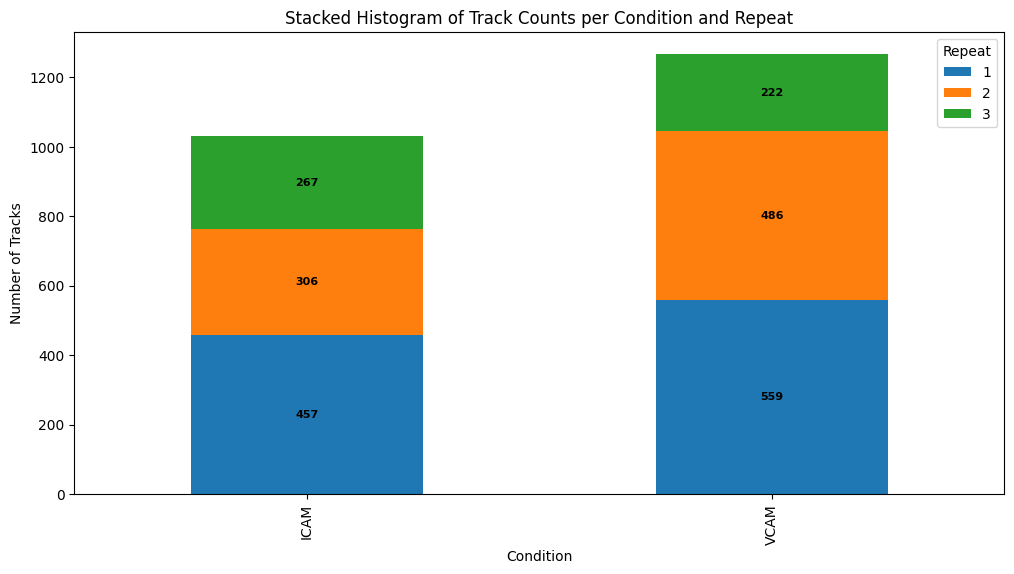

In [ ]:
import pandas as pd

# @title ##Check the number of track per condition per repeats


if not os.path.exists(f"{Results_Folder}/QC"):
    os.makedirs(f"{Results_Folder}/QC")


import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

def count_tracks_by_condition_and_repeat(df, Results_Folder, condition_col='Condition', repeat_col='Repeat', track_id_col='Unique_ID'):
    """
    Counts the number of unique tracks for each combination of condition and repeat in the given DataFrame and
    saves a stacked histogram plot as a PDF in the QC folder with annotations for each stack.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    Results_Folder (str): The base folder where the results will be saved.
    condition_col (str): The name of the column representing the condition. Default is 'Condition'.
    repeat_col (str): The name of the column representing the repeat. Default is 'Repeat'.
    track_id_col (str): The name of the column representing the track ID. Default is 'Unique_ID'.
    """
    track_counts = df.groupby([condition_col, repeat_col])[track_id_col].nunique()
    track_counts_df = track_counts.reset_index()
    track_counts_df.rename(columns={track_id_col: 'Number_of_Tracks'}, inplace=True)

    # Pivot the data for plotting
    pivot_df = track_counts_df.pivot(index=condition_col, columns=repeat_col, values='Number_of_Tracks').fillna(0)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = pivot_df.plot(kind='bar', stacked=True, ax=ax)
    ax.set_xlabel('Condition')
    ax.set_ylabel('Number of Tracks')
    ax.set_title('Stacked Histogram of Track Counts per Condition and Repeat')
    ax.legend(title=repeat_col)
    ax.grid(axis='y', linestyle='--')

    # Hide horizontal grid lines
    ax.yaxis.grid(False)

    # Add number annotations on each stack
    for bar in bars.patches:
        ax.text(bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                int(bar.get_height()),
                ha='center', va='center', color='black', fontweight='bold', fontsize=8)

    # Save the plot as a PDF
    pdf_file = os.path.join(Results_Folder, 'Track_Counts_Histogram.pdf')
    plt.savefig(pdf_file, bbox_inches='tight')
    print(f"Saved histogram to {pdf_file}")

    plt.show()

    return track_counts_df

result_df = count_tracks_by_condition_and_repeat(merged_tracks_df, f"{Results_Folder}/QC")




## **3.2. Compute Similarity Metrics between Field of Views (FOV) and between Conditions and Repeats**
---

<font size = 4>**Purpose**:

<font size = 4>This section provides a set of tools to compute and visualize similarities between different field of views (FOV) based on selected track parameters. By leveraging hierarchical clustering, the resulting dendrogram offers a clear visualization of how different FOV, conditions, or repeats relate to one another. This tool is essential for:

<font size = 4>1. **Quality Control**:
    - Ensuring that FOVs from the same condition or experimental setup are more similar to each other than to FOVs from different conditions.
    - Confirming that repeats of the same experiment yield consistent results and cluster together.
    
<font size = 4>2. **Data Integrity**:
    - Identifying potential outliers or anomalies in the dataset.
    - Assessing the overall consistency of the experiment and ensuring reproducibility.

<font size = 4>**How to Use**:

<font size = 4>1. **Track Parameters Selection**:
    - A list of checkboxes allows users to select which track parameters they want to consider for similarity calculations. By default, all parameters are selected. Users can deselect parameters that they believe might not contribute significantly to the similarity.

<font size = 4>2. **Similarity Metric**:
    - Users can choose a similarity metric from a dropdown list. Options include cosine, euclidean, cityblock, jaccard, and correlation. The choice of similarity metric can influence the clustering results, so users might need to experiment with different metrics to see which one provides the most meaningful results.

<font size = 4>3. **Linkage Method**:
    - Determines how the distance between clusters is calculated in the hierarchical clustering process. Different linkage methods can produce different dendrograms, so users might want to try various methods.

<font size = 4>4. **Visualization**:
    - Once the parameters are selected, users can click on the "Select the track parameters and visualize similarity" button. This will compute the hierarchical clustering and display two dendrograms:
        - One dendrogram displays similarities between individual FOVs.
        - Another dendrogram aggregates the data based on conditions and repeats, providing a higher-level view of the similarities.
      


GridBox(children=(Checkbox(value=True, description='NUMBER_SPOTS', indent=False), Checkbox(value=True, descrip…

Dropdown(description='Similarity Metric:', options=('cosine', 'euclidean', 'cityblock', 'jaccard', 'correlatio…

Dropdown(description='Linkage Method:', options=('single', 'complete', 'average', 'ward'), value='single')

Button(button_style='info', description='Select the track parameters and visualize similarity', layout=Layout(…

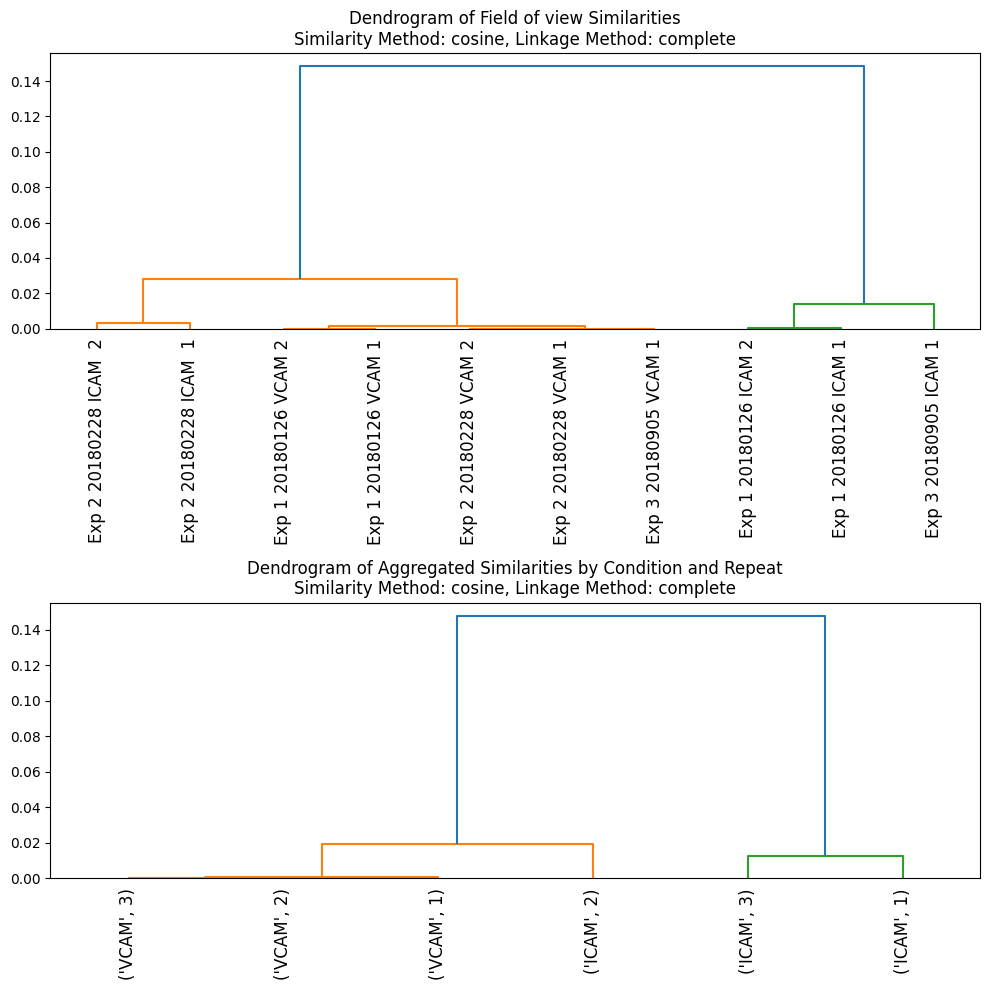

In [ ]:
# @title ##Compute similarity metrics between FOV and between conditions and repeats

import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ipywidgets as widgets
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist

# Check and create "QC" folder
if not os.path.exists(f"{Results_Folder}/QC"):
    os.makedirs(f"{Results_Folder}/QC")

# Columns to exclude
excluded_columns = ['Condition', 'experiment_nb', 'File_name', 'Repeat', 'Unique_ID', 'LABEL', 'TRACK_INDEX', 'TRACK_ID', 'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION', 'Exemplar','TRACK_STOP', 'TRACK_START', 'Cluster_UMAP', 'Cluster_tsne']

selected_df = pd.DataFrame()

# Filter out non-numeric columns but keep 'File_name'
numeric_df = merged_tracks_df.select_dtypes(include=['float64', 'int64']).copy()
numeric_df['File_name'] = merged_tracks_df['File_name']

# Create a list of column names excluding 'File_name'
column_names = [col for col in numeric_df.columns if col not in excluded_columns]

# Create a checkbox for each column
checkboxes = [widgets.Checkbox(value=True, description=col, indent=False) for col in column_names]

# Dropdown for similarity metrics
similarity_dropdown = widgets.Dropdown(
    options=['cosine', 'euclidean', 'cityblock', 'jaccard', 'correlation'],
    value='cosine',
    description='Similarity Metric:'
)

# Dropdown for linkage methods
linkage_dropdown = widgets.Dropdown(
    options=['single', 'complete', 'average', 'ward'],
    value='single',
    description='Linkage Method:'
)

# Arrange checkboxes in a 2x grid
grid = widgets.GridBox(checkboxes, layout=widgets.Layout(grid_template_columns="repeat(2, 300px)"))

# Create a button to trigger the selection and visualization
button = widgets.Button(description="Select the track parameters and visualize similarity", layout=widgets.Layout(width='400px'), button_style='info')

# Define the button click event handler
def on_button_click(b):
    global selected_df  # Declare selected_df as global

    # Get the selected columns from the checkboxes
    selected_columns = [box.description for box in checkboxes if box.value]
    selected_columns.append('File_name')  # Always include 'File_name'

    # Extract the selected columns from the DataFrame
    selected_df = numeric_df[selected_columns]

    # Aggregate the data by filename
    aggregated_by_filename = selected_df.groupby('File_name').mean(numeric_only=True)

    # Aggregate the data by condition and repeat
    aggregated_by_condition_repeat = merged_tracks_df.groupby(['Condition', 'Repeat'])[selected_columns].mean(numeric_only=True)

    # Compute condensed distance matrices
    distance_matrix_filename = pdist(aggregated_by_filename, metric=similarity_dropdown.value)
    distance_matrix_condition_repeat = pdist(aggregated_by_condition_repeat, metric=similarity_dropdown.value)

    # Perform hierarchical clustering
    linked_filename = linkage(distance_matrix_filename, method=linkage_dropdown.value)
    linked_condition_repeat = linkage(distance_matrix_condition_repeat, method=linkage_dropdown.value)

    annotation_text = f"Similarity Method: {similarity_dropdown.value}, Linkage Method: {linkage_dropdown.value}"

        # Prepare the parameters dictionary
    similarity_params = {
        'Similarity Metric': similarity_dropdown.value,
        'Linkage Method': linkage_dropdown.value,
        'Selected Columns': ', '.join(selected_columns)
    }

    # Save the parameters
    params_file_path = os.path.join(Results_Folder, "QC/analysis_parameters.csv")
    save_parameters(similarity_params, params_file_path, 'Similarity Metrics')

    # Plot the dendrograms one under the other
    plt.figure(figsize=(10, 10))

    # Dendrogram for individual filenames
    plt.subplot(2, 1, 1)
    dendrogram(linked_filename, labels=aggregated_by_filename.index, orientation='top', distance_sort='descending', leaf_rotation=90)
    plt.title(f'Dendrogram of Field of view Similarities\n{annotation_text}')

    # Dendrogram for aggregated data based on condition and repeat
    plt.subplot(2, 1, 2)
    dendrogram(linked_condition_repeat, labels=aggregated_by_condition_repeat.index, orientation='top', distance_sort='descending', leaf_rotation=90)
    plt.title(f'Dendrogram of Aggregated Similarities by Condition and Repeat\n{annotation_text}')

    plt.tight_layout()

    # Save the dendrogram to a PDF
    pdf_pages = PdfPages(f"{Results_Folder}/QC/Dendrogram_Similarities.pdf")

    # Save the current figure to the PDF
    pdf_pages.savefig()

    # Close the PdfPages object to finalize the document
    pdf_pages.close()

    plt.show()

# Set the button click event handler
button.on_click(on_button_click)

# Display the widgets
display(grid, similarity_dropdown, linkage_dropdown, button)


-------------------------------------------

# **Part 4. Plot track parameters**
-------------------------------------------

<font size = 4> In this section you can plot all the track parameters previously computed. Data and graphs are automatically saved in your result folder.

<font size = 4 color="red"> Parameters computed are in the unit you provided when tracking your data in TrackMate.

##**Statistical analyses**
### Cohen's d (Effect Size):
<font size = 4>Cohen's d measures the size of the difference between two groups, normalized by their pooled standard deviation. Values can be interpreted as small (0 to 0.2), medium (0.2 to 0.5), or large (0.5 and above) effects. It helps quantify how significant the observed difference is, beyond just being statistically significant.

### Randomization Test:
<font size = 4>This non-parametric test evaluates if observed differences between conditions could have arisen by random chance. It shuffles condition labels multiple times, recalculating the Cohen's d each time. The resulting p-value, which indicates the likelihood of observing the actual difference by chance, provides evidence against the null hypothesis: a smaller p-value implies stronger evidence against the null.

### Bonferroni Correction:
<font size = 4>Given multiple comparisons, the Bonferroni Correction adjusts significance thresholds to mitigate the risk of false positives. By dividing the standard significance level (alpha) by the number of tests, it ensures that only robust findings are considered significant. However, it's worth noting that this method can be conservative, sometimes overlooking genuine effects.


In [ ]:
# @title ##Plot track parameters


# Check and create "pdf" folder
if not os.path.exists(f"{Results_Folder}/track_parameters_plots"):
    os.makedirs(f"{Results_Folder}/track_parameters_plots")

# Check and create "pdf" folder
if not os.path.exists(f"{Results_Folder}/track_parameters_plots/pdf"):
    os.makedirs(f"{Results_Folder}/track_parameters_plots/pdf")

# Check and create "csv" folder
if not os.path.exists(f"{Results_Folder}/track_parameters_plots/csv"):
    os.makedirs(f"{Results_Folder}/track_parameters_plots/csv")

def get_selectable_columns(df):
    # Exclude certain columns from being plotted
    exclude_cols = ['Condition', 'experiment_nb', 'File_name', 'Repeat', 'Unique_ID', 'LABEL', 'TRACK_INDEX', 'TRACK_ID', 'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION', 'Exemplar','TRACK_STOP', 'TRACK_START', 'Cluster_UMAP', 'Cluster_tsne']
    return [col for col in df.columns if col not in exclude_cols]

def display_variable_checkboxes(selectable_columns):
    # Create checkboxes for selectable columns
    variable_checkboxes = [widgets.Checkbox(value=False, description=col) for col in selectable_columns]

    # Display checkboxes in the notebook
    display(widgets.VBox([
        widgets.Label('Variables to Plot:'),
        widgets.GridBox(variable_checkboxes, layout=widgets.Layout(grid_template_columns="repeat(%d, 300px)" % 3)),
    ]))
    return variable_checkboxes

def plot_selected_vars(button, variable_checkboxes, df, Results_Folder):
    print("Plotting in progress...")

    # Get selected variables
    variables_to_plot = [box.description for box in variable_checkboxes if box.value]
    n_plots = len(variables_to_plot)

    if n_plots == 0:
        print("No variables selected for plotting")
        return
# Initialize matrices to store effect sizes and p-values for each variable
    effect_size_matrices = {}
    p_value_matrices = {}
    bonferroni_matrices = {}

    unique_conditions = merged_tracks_df['Condition'].unique().tolist()
    num_comparisons = len(unique_conditions) * (len(unique_conditions) - 1) // 2
    alpha = 0.05
    corrected_alpha = alpha / num_comparisons
    n_iterations = 1000

# Loop through each variable to plot
    for var in variables_to_plot:

      pdf_pages = PdfPages(f"{Results_Folder}/track_parameters_plots/pdf/{var}_Boxplots_and_Statistics.pdf")
      effect_size_matrix = pd.DataFrame(index=unique_conditions, columns=unique_conditions)
      p_value_matrix = pd.DataFrame(index=unique_conditions, columns=unique_conditions)
      bonferroni_matrix = pd.DataFrame(index=unique_conditions, columns=unique_conditions)

      for cond1, cond2 in itertools.combinations(unique_conditions, 2):
        group1 = merged_tracks_df[merged_tracks_df['Condition'] == cond1][var]
        group2 = merged_tracks_df[merged_tracks_df['Condition'] == cond2][var]

        original_d = cohen_d(group1, group2)
        effect_size_matrix.loc[cond1, cond2] = original_d
        effect_size_matrix.loc[cond2, cond1] = original_d  # Mirroring

        count_extreme = 0
        for i in range(n_iterations):
            combined = pd.concat([group1, group2])
            shuffled = combined.sample(frac=1, replace=False).reset_index(drop=True)
            new_group1 = shuffled[:len(group1)]
            new_group2 = shuffled[len(group1):]

            new_d = cohen_d(new_group1, new_group2)
            if np.abs(new_d) >= np.abs(original_d):
                count_extreme += 1

        p_value = count_extreme / n_iterations
        p_value_matrix.loc[cond1, cond2] = p_value
        p_value_matrix.loc[cond2, cond1] = p_value  # Mirroring

        # Apply Bonferroni correction
        bonferroni_corrected_p_value = min(p_value * num_comparisons, 1.0)
        bonferroni_matrix.loc[cond1, cond2] = bonferroni_corrected_p_value
        bonferroni_matrix.loc[cond2, cond1] = bonferroni_corrected_p_value  # Mirroring

      effect_size_matrices[var] = effect_size_matrix
      p_value_matrices[var] = p_value_matrix
      bonferroni_matrices[var] = bonferroni_matrix

    # Concatenate the three matrices side-by-side
      combined_df = pd.concat(
        [
            effect_size_matrices[var].rename(columns={col: f"{col} (Effect Size)" for col in effect_size_matrices[var].columns}),
            p_value_matrices[var].rename(columns={col: f"{col} (P-Value)" for col in p_value_matrices[var].columns}),
            bonferroni_matrices[var].rename(columns={col: f"{col} (Bonferroni-corrected P-Value)" for col in bonferroni_matrices[var].columns})
        ], axis=1
    )

    # Save the combined DataFrame to a CSV file
      combined_df.to_csv(f"{Results_Folder}/track_parameters_plots/csv/{var}_statistics_combined.csv")

    # Create a new figure
      fig = plt.figure(figsize=(16, 10))

    # Create a gridspec for 2 rows and 4 columns
      gs = GridSpec(2, 3, height_ratios=[1.5, 1])

    # Create the ax for boxplot using the gridspec
      ax_box = fig.add_subplot(gs[0, :])

    # Extract the data for this variable
      data_for_var = merged_tracks_df[['Condition', var, 'Repeat', 'File_name' ]]

    # Save the data_for_var to a CSV for replotting
      data_for_var.to_csv(f"{Results_Folder}/track_parameters_plots/csv/{var}_boxplot_data.csv", index=False)

    # Calculate the Interquartile Range (IQR) using the 25th and 75th percentiles
      Q1 = merged_tracks_df[var].quantile(0.25)
      Q3 = merged_tracks_df[var].quantile(0.75)
      IQR = Q3 - Q1

    # Define bounds for the outliers
      multiplier = 10
      lower_bound = Q1 - multiplier * IQR
      upper_bound = Q3 + multiplier * IQR

    # Plotting
      sns.boxplot(x='Condition', y=var, data=merged_tracks_df, ax=ax_box, color='lightgray')  # Boxplot
      sns.stripplot(x='Condition', y=var, data=merged_tracks_df, ax=ax_box, hue='Repeat', dodge=True, jitter=True, alpha=0.2)  # Individual data points
      ax_box.set_ylim([max(min(merged_tracks_df[var]), lower_bound), min(max(merged_tracks_df[var]), upper_bound)])
      ax_box.set_title(f"{var}")
      ax_box.set_xlabel('Condition')
      ax_box.set_ylabel(var)
      ax_box.set_xticklabels(ax_box.get_xticklabels(), rotation=90)
      ax_box.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Repeat')

    # Statistical Analyses and Heatmaps

    # Effect Size heatmap ax
      ax_d = fig.add_subplot(gs[1, 0])
      sns.heatmap(effect_size_matrices[var].fillna(0), annot=True, cmap="coolwarm", cbar=True, square=True, ax=ax_d)
      ax_d.set_title(f"Effect Size (Cohen's d) for {var}")

    # p-value heatmap ax
      ax_p = fig.add_subplot(gs[1, 1])
      sns.heatmap(p_value_matrices[var].fillna(1), annot=True, cmap="viridis_r", cbar=True, square=True, ax=ax_p, vmax=0.1)
      ax_p.set_title(f"Randomization Test p-value for {var}")

    # Bonferroni corrected p-value heatmap ax
      ax_bonf = fig.add_subplot(gs[1, 2])
      sns.heatmap(bonferroni_matrices[var].fillna(1), annot=True, cmap="viridis_r", cbar=True, square=True, ax=ax_bonf, vmax=0.1)
      ax_bonf.set_title(f"Bonferroni-corrected p-value for {var}")

      plt.tight_layout()
      pdf_pages.savefig(fig)

    # Close the PDF
      pdf_pages.close()

selectable_columns = get_selectable_columns(merged_tracks_df)
variable_checkboxes = display_variable_checkboxes(selectable_columns)
#merged_tracks_df = merged_tracks_df.dropna

# Create and display the plot button
button = widgets.Button(description="Plot Selected Variables", layout=widgets.Layout(width='400px'), button_style='info')
button.on_click(lambda b: plot_selected_vars(b, variable_checkboxes, merged_tracks_df, Results_Folder))
display(button)

Output hidden; open in https://colab.research.google.com to view.

--------
# **Part 5. Explore your high-dimensional data using UMAP and HDBSCAN**
--------

<font size = 4> The workflow provided below is inspired by [CellPlato](https://github.com/Michael-shannon/cellPLATO)

## **5.1. Choose the track metrics to use for clustering**
--------


In [ ]:
# @title ##Choose the track metrics to use

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Check and create "pdf" folder
if not os.path.exists(f"{Results_Folder}/Umap"):
    os.makedirs(f"{Results_Folder}/Umap")


excluded_columns = ['Condition', 'experiment_nb', 'File_name', 'Repeat', 'Unique_ID', 'LABEL', 'TRACK_INDEX', 'TRACK_ID', 'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION', 'Exemplar','TRACK_STOP', 'TRACK_START', 'Cluster_UMAP', 'Cluster_tsne']

# Columns you want to always include
columns_to_include = ['File_name', 'Repeat', 'Condition', 'Unique_ID']

selected_df = pd.DataFrame()
nan_columns = pd.DataFrame()
# Extract the columns you always want to include and ensure they exist in the original dataframe
saved_columns = {col: merged_tracks_df[col].copy() for col in columns_to_include if col in merged_tracks_df}

# Filter out non-numeric columns
numeric_df = merged_tracks_df.select_dtypes(include=['float64', 'int64'])  # Selecting only numeric columns

column_names = [col for col in numeric_df.columns if col not in excluded_columns]

# Create a checkbox for each column
checkboxes = [widgets.Checkbox(value=True, description=col, indent=False) for col in column_names]

# Arrange checkboxes in a 2x grid
grid = widgets.GridBox(checkboxes, layout=widgets.Layout(grid_template_columns="repeat(2, 300px)"))

# Create a button to trigger the selection
button = widgets.Button(description="Select the track parameters", layout=widgets.Layout(width='400px'), button_style='info')

# Define the button click event handler
def on_button_click(b):
    global selected_df  # Declare selected_df as global
    global nan_columns
    # Get the selected columns from the checkboxes
    selected_columns = [box.description for box in checkboxes if box.value]

    # Extract the selected columns from the DataFrame
    selected_df = numeric_df[selected_columns].copy()

        # Prepare the parameters dictionary
    UMAP_params = {
        'Selected Columns': ', '.join(selected_columns)
    }

    # Save the parameters
    params_file_path = os.path.join(Results_Folder, "Umap/analysis_parameters.csv")
    save_parameters(UMAP_params, params_file_path, 'UMAP')

    # Add back the always-included columns to selected_df
    for col, data in saved_columns.items():
        selected_df.loc[:, col] = data

    # Check if the DataFrame has any NaN values and print a warning if it does.
    nan_columns = selected_df.columns[selected_df.isna().any()].tolist()
    if nan_columns:
        for col in nan_columns:
            selected_df = selected_df.dropna(subset=[col])  # Drop NaN values only from columns containing them

    print("Done")

# Set the button click event handler
button.on_click(on_button_click)

# Display the grid of checkboxes and the button
display(grid, button)


GridBox(children=(Checkbox(value=True, description='NUMBER_SPOTS', indent=False), Checkbox(value=True, descrip…

Button(button_style='info', description='Select the track parameters', layout=Layout(width='400px'), style=But…

Done


## **5.2. UMAP**
---

<font size = 4> The given code performs UMAP (Uniform Manifold Approximation and Projection) dimensionality reduction on the merged tracks dataframe, focusing on its numeric columns, and visualizes the result. In the provided UMAP code, the parameters `n_neighbors`, `min_dist`, and `n_components` are crucial for determining the structure and appearance of the resulting low-dimensional representation of the data.

<font size = 4>`n_neighbors`: This parameter controls how UMAP balances local versus global structure in the data. It determines the size of the local neighborhood UMAP will look at when learning the manifold structure of the data.
- A smaller value emphasizes the local structure of the data, potentially at the expense of the global structure.
- A larger value allows UMAP to consider more distant neighbors, emphasizing more on the global structure of the data.
- Typically, values in the range of 5 to 50 are chosen, depending on the density and scale of the data.

<font size = 4>`min_dist`: This parameter controls how tightly UMAP is allowed to pack points together. It determines the minimum distance between points in the low-dimensional representation.
- Setting it to a low value will allow points to be packed more closely, potentially revealing clusters in the data.
- A higher value ensures that points are more spread out in the representation.
- Values usually range between 0 and 1.

<font size = 4>`n_dimension`: This parameter determines the number of dimensions in the low-dimensional space that the data will be reduced to.
For visualization purposes, `n_dimension` is typically set to 2 or 3 to obtain 2D or 3D representations, respectively.


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



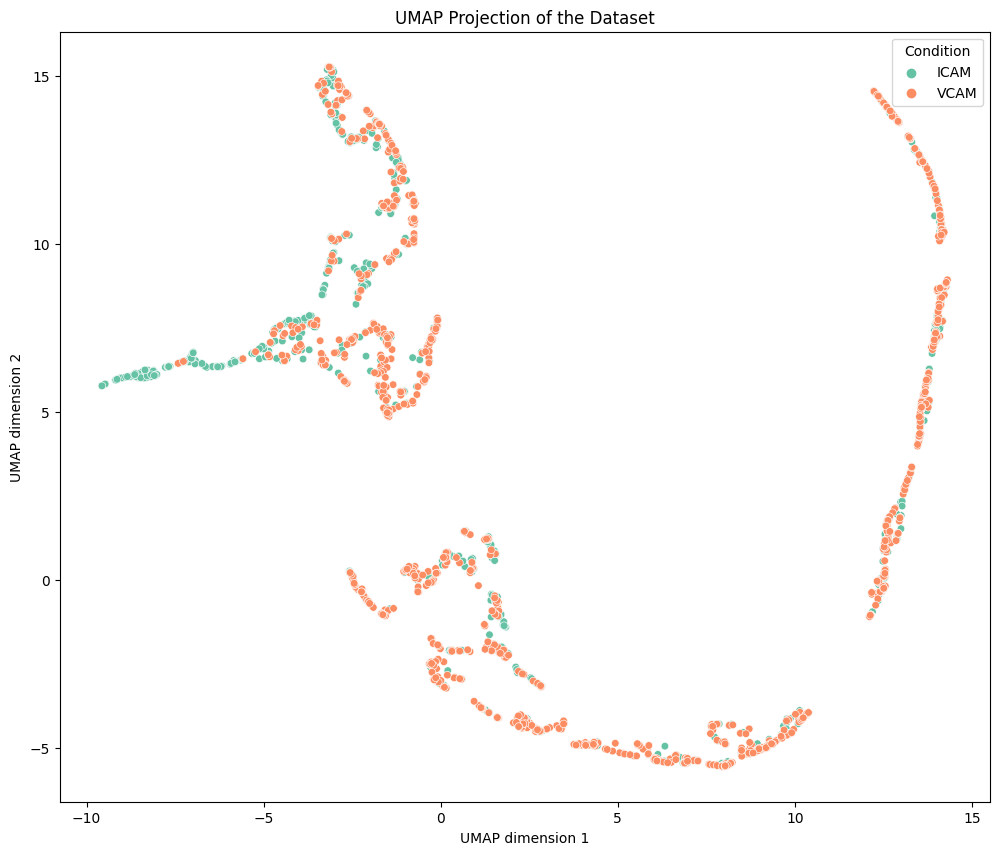

In [ ]:
# @title ##Perform UMAP
import umap
import plotly.offline as pyo

#@markdown ###UMAP parameters:

n_neighbors = 20  # @param {type: "number"}
min_dist = 0  # @param {type: "number"}
n_dimension = 2  # @param {type: "slider", min: 1, max: 3}

#@markdown ###Display parameters:
spot_size = 30 # @param {type: "number"}

# Initialize UMAP object with the specified settings
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_dimension, random_state=42)
# Exclude non-numeric columns when fitting UMAP
embedding = reducer.fit_transform(selected_df.drop(columns=columns_to_include))
# Create dynamic column names based on n_components
column_names = [f'UMAP dimension {i}' for i in range(1, n_dimension + 1)]

# Extract the columns_to_include from selected_df
included_data = selected_df[columns_to_include].reset_index(drop=True)

# Concatenate the UMAP embedding with the included columns
umap_df = pd.concat([pd.DataFrame(embedding, columns=column_names), included_data], axis=1)


# Check if the DataFrame has any NaN values and print a warning if it does.
nan_columns = umap_df.columns[umap_df.isna().any()].tolist()

if nan_columns:
  warnings.warn(f"The DataFrame contains NaN values in the following columns: {', '.join(nan_columns)}")
  for col in nan_columns:
    umap_df = umap_df.dropna(subset=[col])  # Drop NaN values only from columns containing them

  # Prepare the parameters dictionary
UMAP_params = {
        'n_neighbors': n_neighbors,
        'min_dist': min_dist,
        'n_dimension': n_dimension
    }

    # Save the parameters
params_file_path = os.path.join(Results_Folder, "Umap/analysis_parameters.csv")
save_parameters(UMAP_params, params_file_path, 'UMAP')

# Visualize the UMAP projection
plt.figure(figsize=(12, 10))

# The plot will adjust automatically based on the n_components
if n_dimension == 2:
    sns.scatterplot(x=column_names[0], y=column_names[1], hue='Condition', data=umap_df, palette='Set2', s=spot_size)
    plt.title('UMAP Projection of the Dataset')
    plt.savefig(f"{Results_Folder}/Umap/umap_projection_2D.pdf")  # Save 2D plot as PDF
    plt.show()
elif n_dimension == 1:
    sns.stripplot(x=column_names[0], hue='Condition', data=umap_df, palette='Set2', jitter=0.05, size=spot_size)
    plt.title('UMAP Projection of the Dataset')
    plt.savefig(f"{Results_Folder}/Umap/umap_projection_1D.pdf")  # Save 2D plot as PDF
    plt.show()
else:
    # umap_df should have columns like 'UMAP dimension 1', 'UMAP dimension 2', 'UMAP dimension 3', and 'condition'
    import plotly.express as px
    import pandas as pd
    import numpy as np

    fig = px.scatter_3d(umap_df,
                    x='UMAP dimension 1',
                    y='UMAP dimension 2',
                    z='UMAP dimension 3',
                    color='Condition')

    for trace in fig.data:
      trace.marker.size = spot_size  # You can set this to any desired value

    fig.show()
    pyo.plot(fig, filename=f"{Results_Folder}/Umap/umap_projection.html", auto_open=False)

## **5.3. HDBSCAN**
---

<font size = 4> The provided code employs HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) to identify clusters within a dataset that has already undergone UMAP dimensionality reduction. HDBSCAN is utilized for its proficiency in determining the optimal number of clusters while managing varied densities within the data.

<font size = 4>In the provided HDBSCAN code, the parameters `min_samples`, `min_cluster_size`, and `metric` are crucial for determining the structure and appearance of the resulting clusters in the data.

<font size = 4>`min_samples`: This parameter primarily controls the degree to which the algorithm is willing to declare noise. It's the number of samples in a neighborhood for a point to be considered as a core point.
- A smaller value of `min_samples` makes the algorithm more prone to declaring points as part of a cluster, potentially leading to larger clusters and fewer noise points.
- A larger value makes the algorithm more conservative, resulting in more points declared as noise and smaller, more defined clusters.
- The choice of `min_samples` typically depends on the density of the data; denser datasets may require a larger value.

<font size = 4>`min_cluster_size`: This parameter determines the smallest size grouping that you wish to consider a cluster.
- A smaller value will allow the formation of smaller clusters, whereas a larger value will prevent small isolated groups of points from being declared as clusters.
- The choice of `min_cluster_size` depends on the scale of the data and the desired level of granularity in the clustering.

<font size = 4>`metric`: This parameter is the metric used for distance computation between data points, and it affects the shape of the clusters.
- The `euclidean` metric is a good starting point, and depending on the clustering results and the data type, it might be beneficial to experiment with different metrics.


In [ ]:
# @title ##Run to see more information about the available metrics
print("""
Metric                   Description                                                               Suitable For
-------------------------------------------------------------------------------------------------------------------------------------------------------
Euclidean                Standard distance metric.                                                 Numerical data.
Manhattan                Sum of absolute differences.                                              Numerical/Categorical data.
Chebyshev                Maximum value of absolute differences.                                    Numerical data.
Minkowski                Generalization of Euclidean and Manhattan distance.                       Numerical data.
Bray-Curtis              Dissimilarity between sample sets.                                        Numerical data.
Canberra                 Weighted version of Manhattan distance.                                   Numerical data.
Mahalanobis              Distance between a point and a distribution.                              Numerical data.

""")


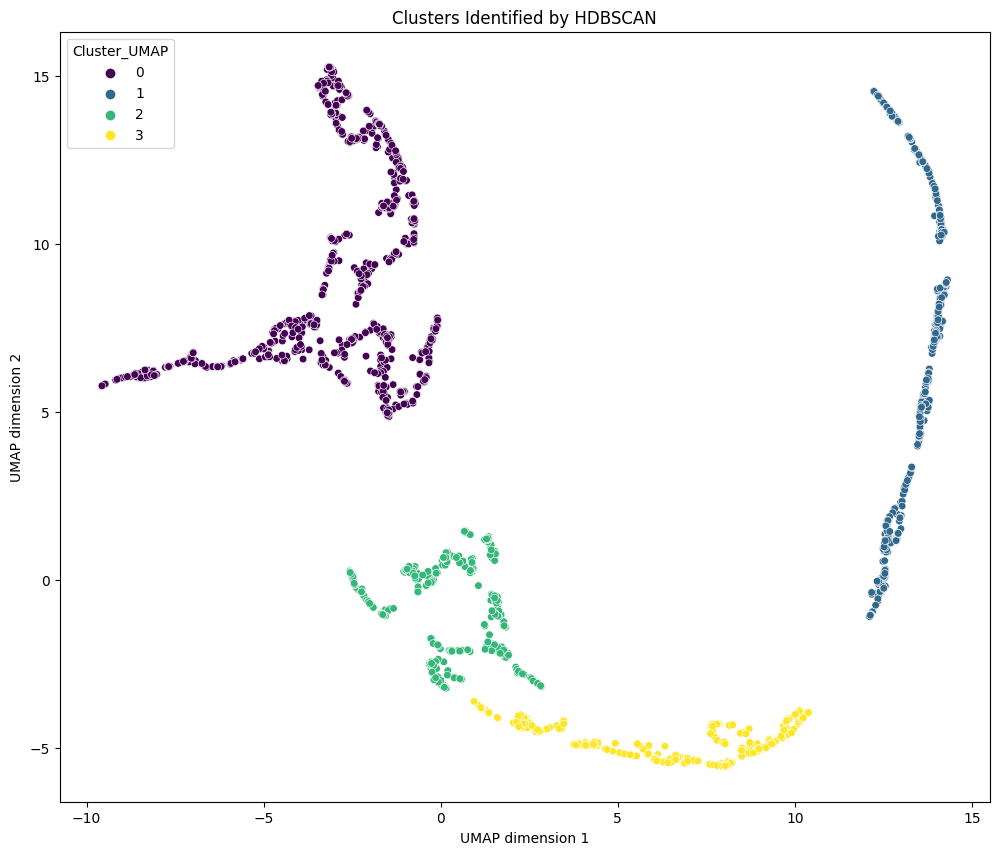

In [ ]:
# @title ##Identify clusters using HDBSCAN
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np

#@markdown ###HDBSCAN parameters:
clustering_data_source = 'umap'  # @param ['umap', 'raw']
min_samples = 20  # @param {type: "number"}
min_cluster_size = 200  # @param {type: "number"}
metric = "euclidean"  # @param ['euclidean', 'manhattan', 'chebyshev', 'braycurtis', 'canberra']

#@markdown ###Display parameters:
spot_size = 30 # @param {type: "number"}
# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric=metric)  # You may need to tune these parameters

if clustering_data_source == 'umap':
  if n_dimension == 1:
    clusterer.fit(umap_df[['UMAP dimension 1']])  # Use only one UMAP dimension for clustering

  elif n_dimension == 2:
    clusterer.fit(umap_df[['UMAP dimension 1', 'UMAP dimension 2']])  # Use two UMAP dimensions for clustering

  elif n_dimension == 3:
    clusterer.fit(umap_df[['UMAP dimension 1', 'UMAP dimension 2', 'UMAP dimension 3']])  # Use three UMAP dimensions for clustering

else:
  clusterer.fit(selected_df.select_dtypes(include=['number']))

# Add the cluster labels to your UMAP DataFrame
umap_df['Cluster_UMAP'] = clusterer.labels_

# If the Cluster column already exists in merged_tracks_df, drop it to avoid duplications
if 'Cluster_UMAP' in merged_tracks_df.columns:
    merged_tracks_df.drop(columns='Cluster_UMAP', inplace=True)

# Merge the Cluster column from umap_df to merged_tracks_df based on Unique_ID
merged_tracks_df = pd.merge(merged_tracks_df, umap_df[['Unique_ID', 'Cluster_UMAP']], on='Unique_ID', how='left')

# Handle cases where some rows in merged_tracks_df might not have a corresponding cluster label
merged_tracks_df['Cluster_UMAP'].fillna(-1, inplace=True)  # Assigning -1 to cells that were not assigned to any cluster

# Save the DataFrame with the identified clusters
merged_tracks_df.to_csv(Results_Folder + '/' + 'merged_Tracks.csv', index=False)

  # Prepare the parameters dictionary
UMAP_params = {
        'clustering_data_source': clustering_data_source,
        'min_samples': min_samples,
        'min_cluster_size': min_cluster_size,
        'metric': metric
    }

    # Save the parameters
params_file_path = os.path.join(Results_Folder, "Umap/analysis_parameters.csv")
save_parameters(UMAP_params, params_file_path, 'HDBSCAN')

# Plotting the results
if n_dimension == 1:
    plt.figure(figsize=(12, 6))
    sns.stripplot(data=umap_df, x='UMAP dimension 1', hue='Cluster_UMAP', palette='viridis', s=spot_size)
    plt.title('Clusters Identified by HDBSCAN (1D)')
    plt.xlabel('UMAP dimension 1')
    plt.ylabel('Count')
    plt.savefig(f"{Results_Folder}/Umap/HDBSCAN_clusters_1D.pdf")  # Save 1D histogram as PDF
    plt.show()

if n_dimension == 2:

  plt.figure(figsize=(12,10))
  sns.scatterplot(x='UMAP dimension 1', y='UMAP dimension 2', hue='Cluster_UMAP', palette='viridis', data=umap_df, s=spot_size)
  plt.title('Clusters Identified by HDBSCAN')
  plt.savefig(f"{Results_Folder}/Umap/HDBSCAN_clusters_2D.pdf")  # Save 2D plot as PDF
  plt.show()

if n_dimension == 3:

  fig = px.scatter_3d(umap_df,
                    x='UMAP dimension 1',
                    y='UMAP dimension 2',
                    z='UMAP dimension 3',
                    color='Cluster_UMAP')

  for trace in fig.data:
    trace.marker.size = spot_size

  fig.show()
  pyo.plot(fig, filename=f"{Results_Folder}/Umap/HDBSCAN_clusters.html", auto_open=False)

## **5.4. Fingerprint**
---

<font size = 4>This section is designed to visualize the distribution of different clusters within each condition in a dataset, showing the 'fingerprint' of each cluster per condition.

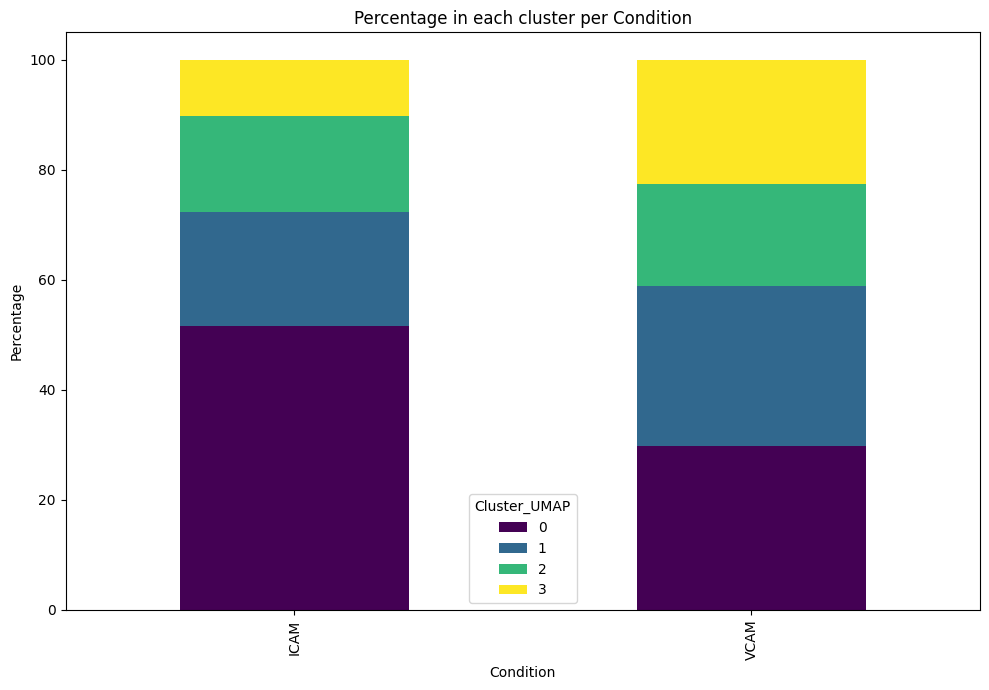

In [ ]:
# @title ##Plot the 'fingerprint' of each cluster per condition

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Group by 'Condition' and 'Cluster' and calculate the size of each group
cluster_counts = umap_df.groupby(['Condition', 'Cluster_UMAP']).size().reset_index(name='counts')

# Calculate the total number of points per condition
total_counts = umap_df.groupby('Condition').size().reset_index(name='total_counts')

# Merge the DataFrames on 'Condition' to calculate percentages
percentage_df = pd.merge(cluster_counts, total_counts, on='Condition')
percentage_df['percentage'] = (percentage_df['counts'] / percentage_df['total_counts']) * 100

# Save the percentage_df DataFrame as a CSV file
percentage_df.to_csv(Results_Folder+'/Umap/UMAP_percentage_results.csv', index=False)

# Pivot the percentage_df to have Conditions as index, Clusters as columns, and percentages as values
pivot_df = percentage_df.pivot(index='Condition', columns='Cluster_UMAP', values='percentage')

# Fill NaN values with 0 if any, as there might be some Condition-Cluster combinations that are not present
pivot_df.fillna(0, inplace=True)

# Initialize PDF
pdf_pages = PdfPages(Results_Folder+'/Umap/UMAP_Cluster_Fingerprint_Plot.pdf')

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))
pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
plt.title('Percentage in each cluster per Condition')
plt.ylabel('Percentage')
plt.xlabel('Condition')
plt.xticks(rotation=90)
plt.tight_layout()

# Save the figure to a PDF
pdf_pages.savefig(fig)

# Close the PDF
pdf_pages.close()

# Display the plot
plt.show()



## **5.5. Understand your clusters using heatmaps**
--------

<font size = 4>This section help visualize how different track parameters vary across the identified clusters. The approach is to display these variations using a heatmap, which offers a color-coded representation of the median values of each parameter for each cluster. This visualization technique can make it easier to spot differences or patterns among the clusters.


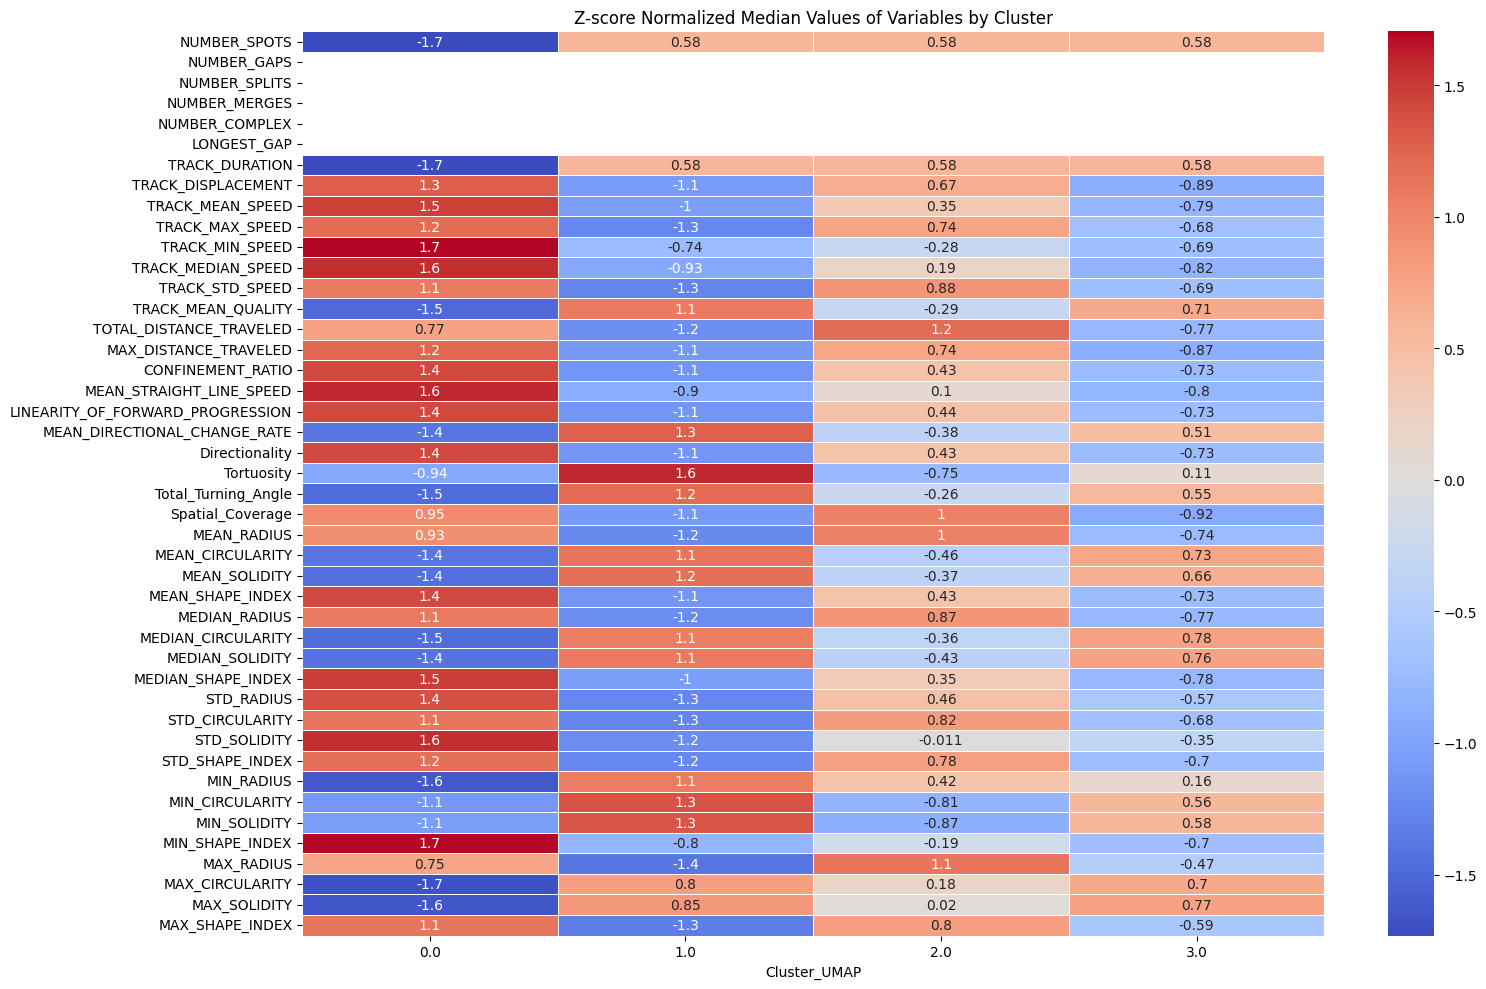

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy.stats import zscore

# @title ##Plot track normalized track parameters based on clusters as an heatmap

# Check and create "pdf" folder
if not os.path.exists(f"{Results_Folder}/Umap/Track_parameters"):
    os.makedirs(f"{Results_Folder}/Umap/Track_parameters")

def get_selectable_columns(df):
    # Exclude certain columns from being plotted
    exclude_cols = ['Condition', 'experiment_nb', 'File_name', 'Repeat', 'Unique_ID', 'LABEL', 'TRACK_INDEX', 'TRACK_ID', 'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION', 'Exemplar','TRACK_STOP', 'TRACK_START', 'Cluster_UMAP', 'Cluster_tsne']
    return [col for col in df.columns if col not in exclude_cols]

def heatmap_comparison(df, Results_Folder):
    # Get all the selectable columns
    variables_to_plot = get_selectable_columns(df)

    # Drop rows where all elements are NaNs in the variables_to_plot columns
    df = df.dropna()

    # Compute median for each variable across clusters
    median_values = df.groupby('Cluster_UMAP')[variables_to_plot].median().transpose()

    # Normalize the median values using Z-score
    normalized_values = median_values.apply(zscore, axis=1)

    # Plot the heatmap
    plt.figure(figsize=(16, 10))
    sns.heatmap(normalized_values, cmap='coolwarm', annot=True, linewidths=.5)
    plt.title("Z-score Normalized Median Values of Variables by Cluster")
    plt.tight_layout()

    # Save the heatmap
    plt.savefig(f"{Results_Folder}/Umap/Track_parameters/Heatmap_Normalized_Median_Values_by_Cluster.pdf")
    plt.show()

    # Save the normalized median values data to CSV
    normalized_values.to_csv(f"{Results_Folder}/Umap/Track_parameters/Normalized_Median_Values_by_Cluster.csv")

# Plot the heatmap directly
heatmap_comparison(merged_tracks_df, Results_Folder)


## **5.6. Understand your clusters using box plots**
--------

<font size = 4>The provided code aims to visually represent the distribution of different track parameters across the identified clusters. Specifically, for each parameter selected, a boxplot is generated to showcase the spread of its values across different clusters. This approach provides a comprehensive view of how each track parameter varies within and across the clusters.




Button(description='Plot Selected Variables', layout=Layout(width='400px'), style=ButtonStyle())

Plotting in progress...


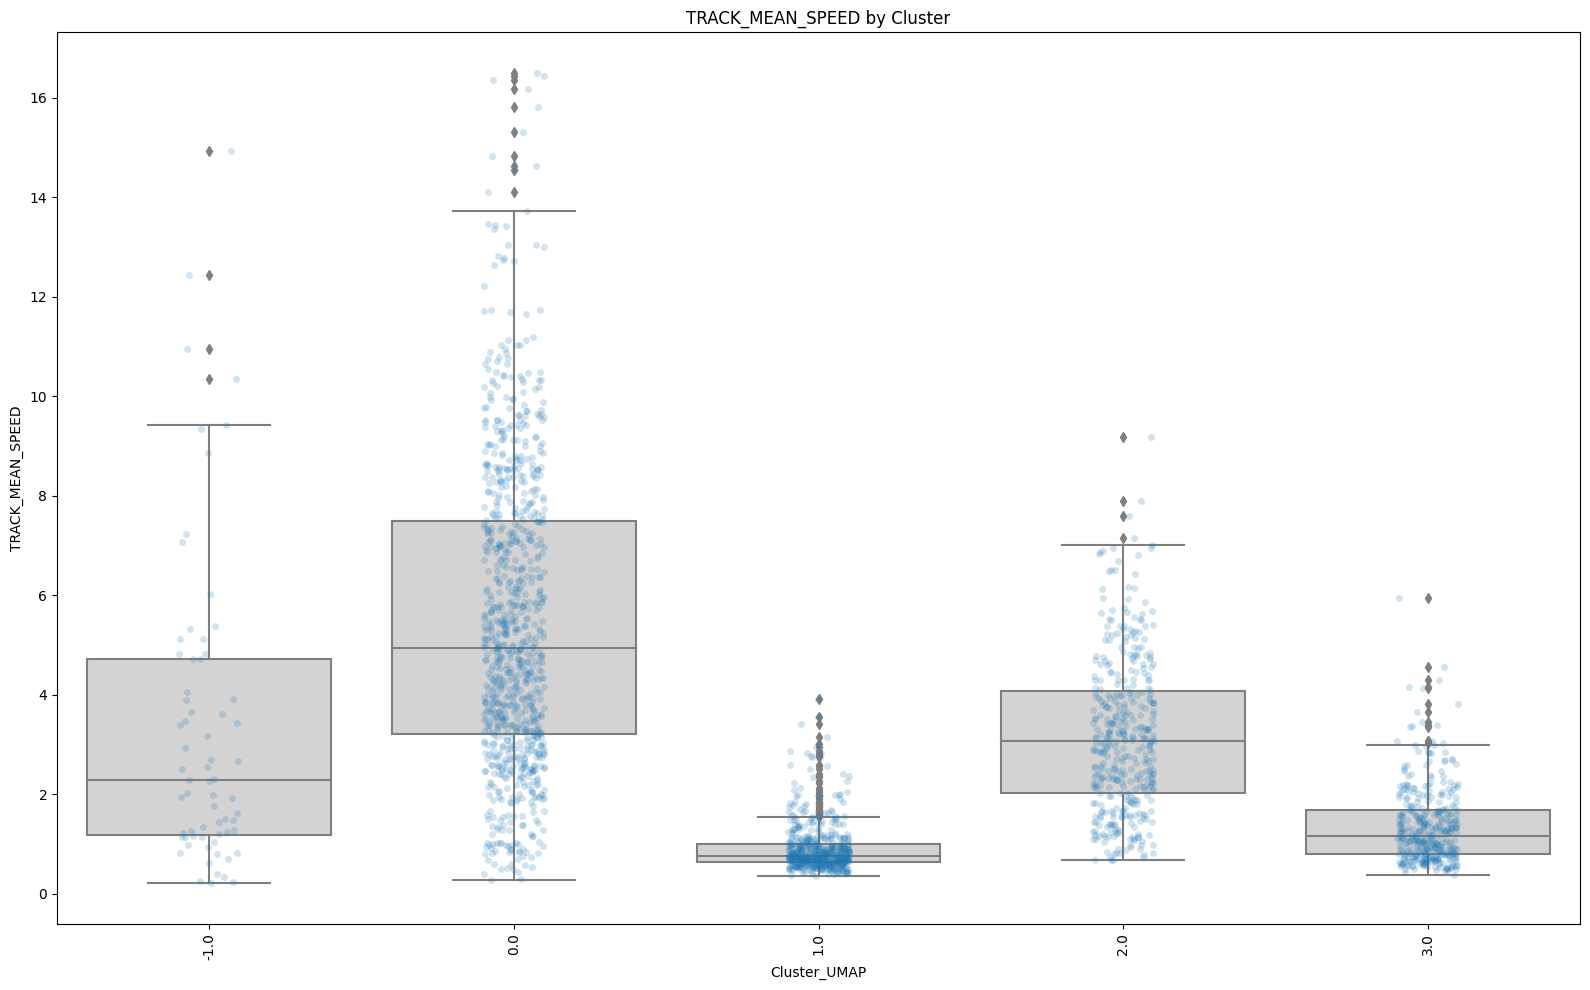

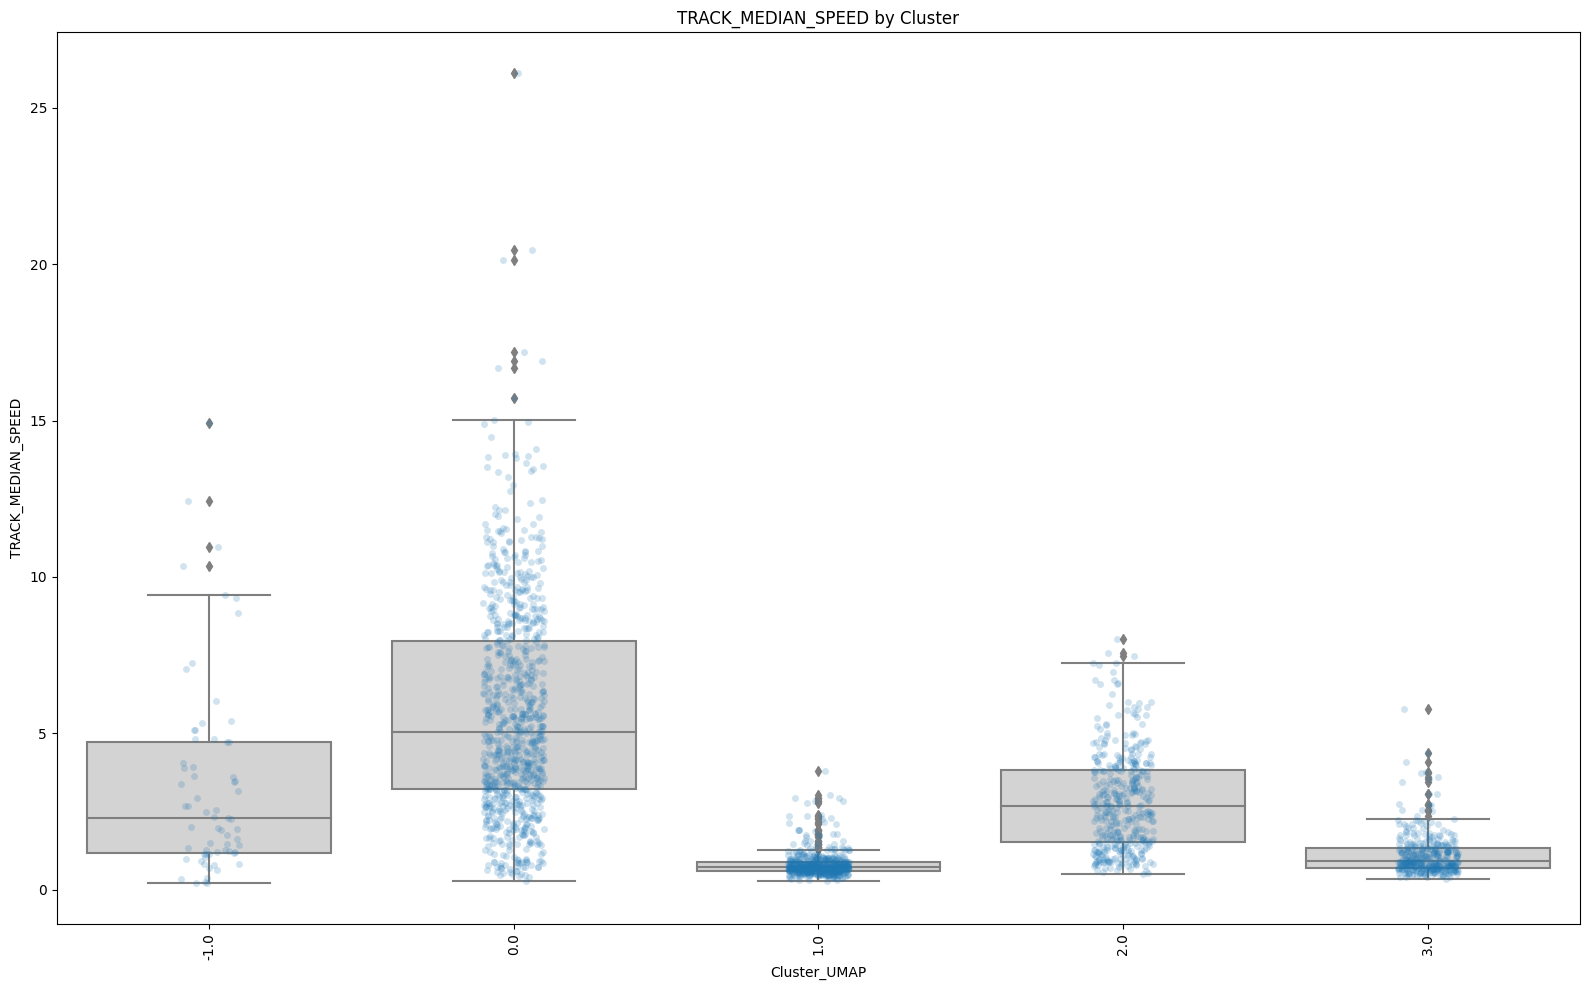

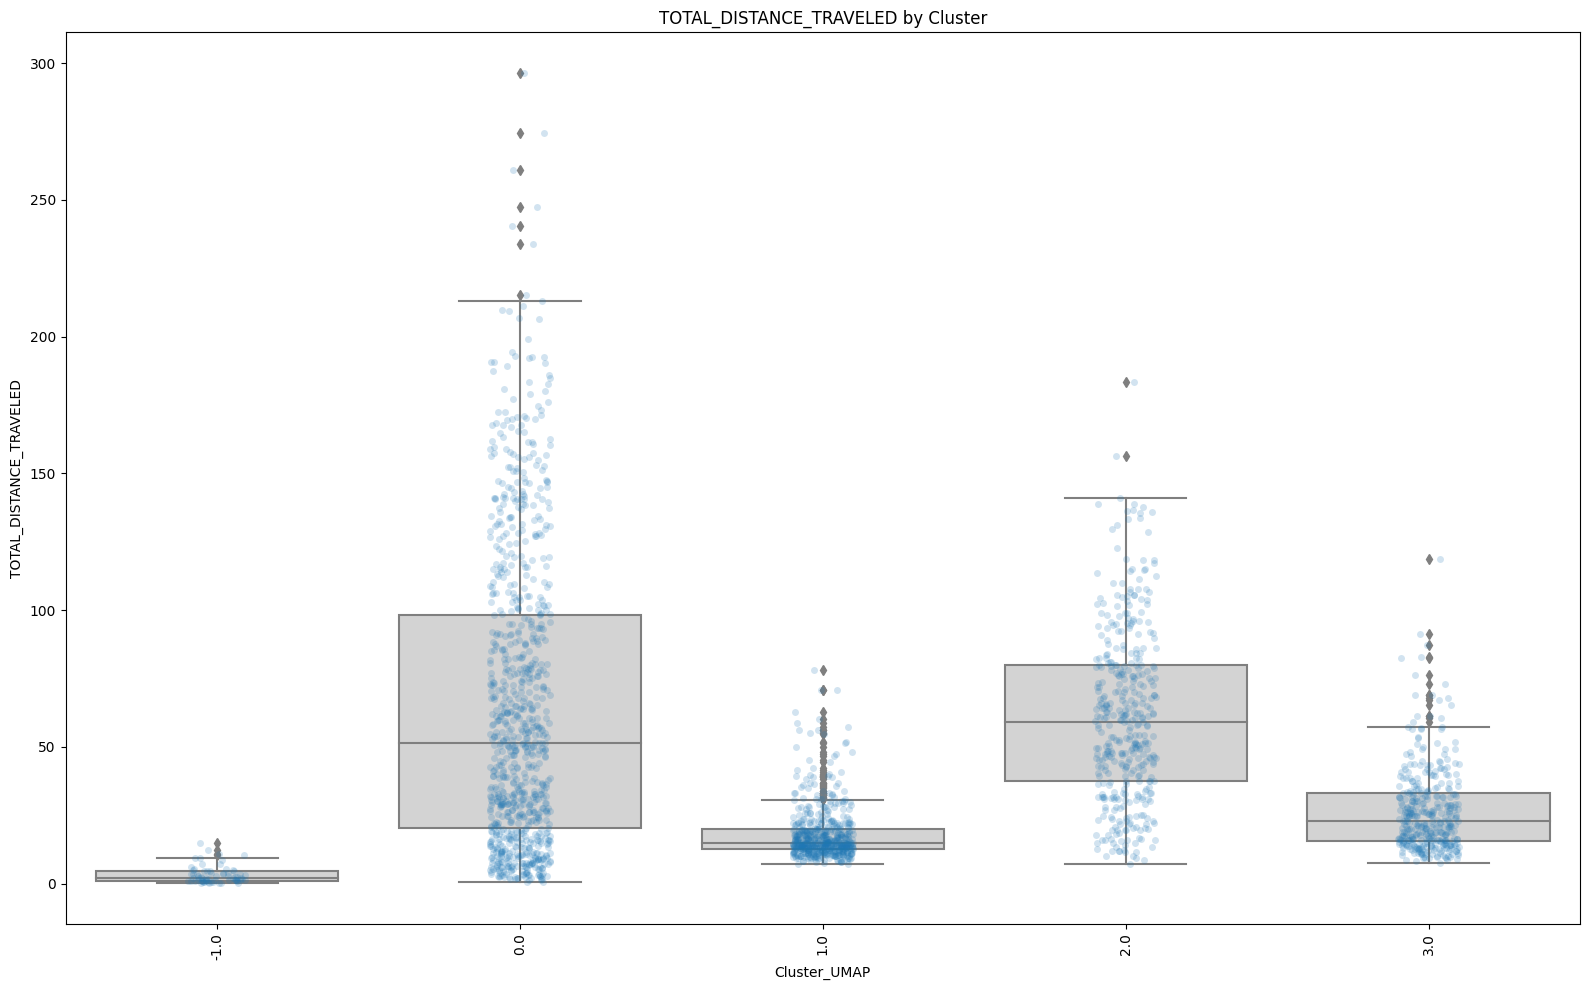

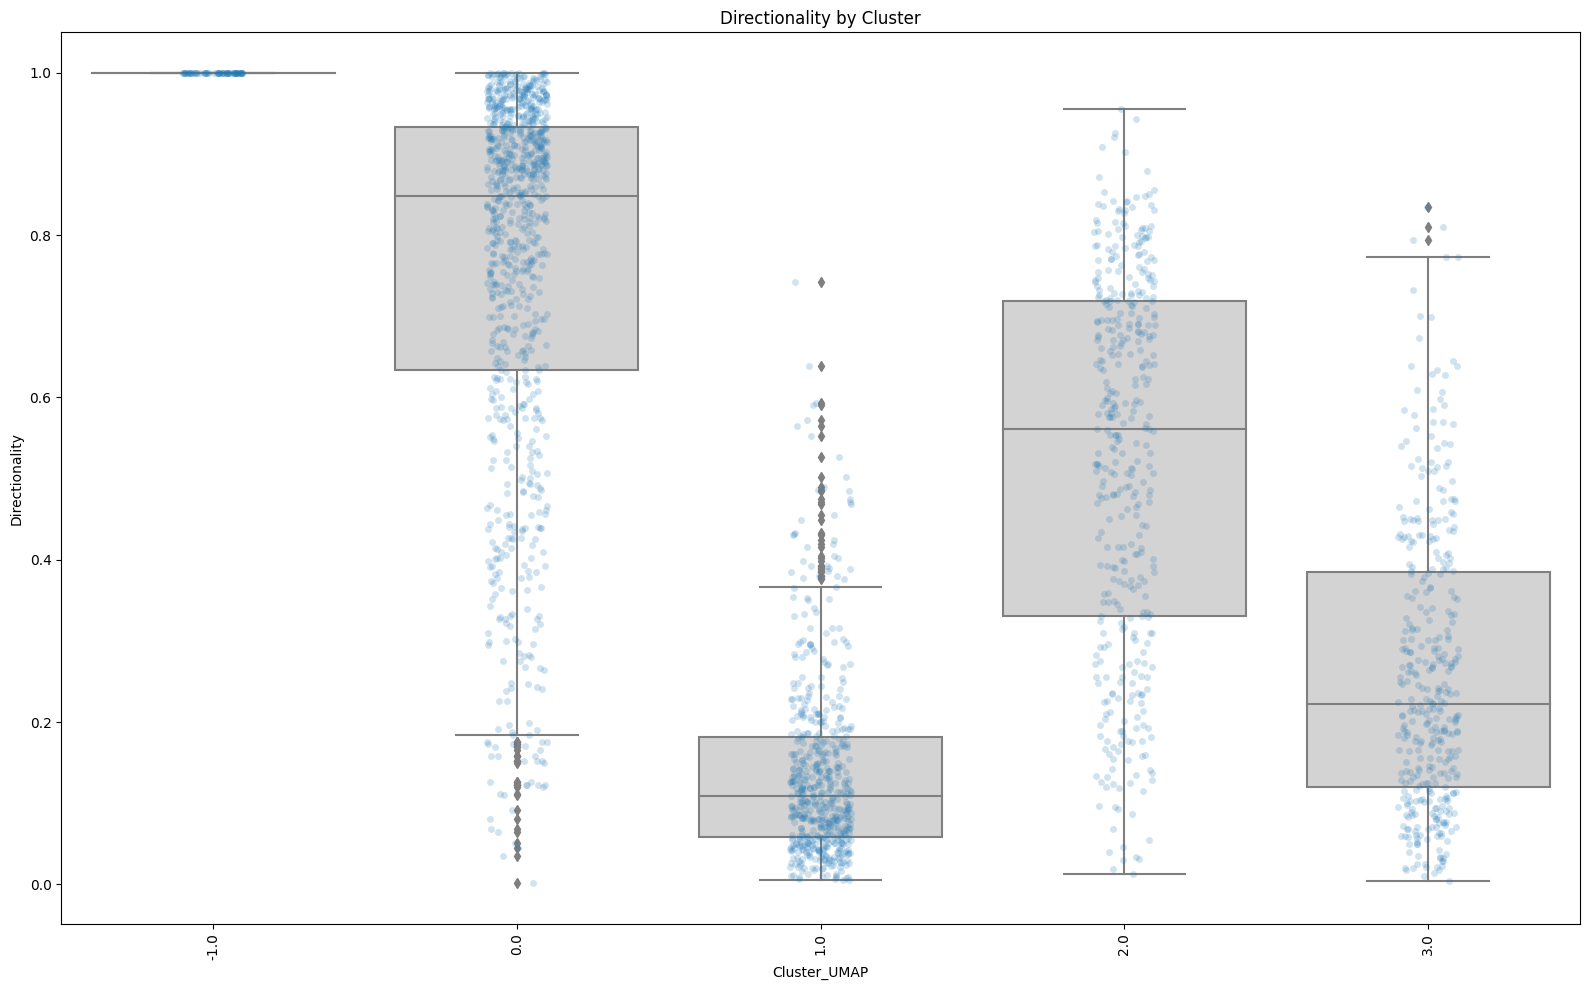

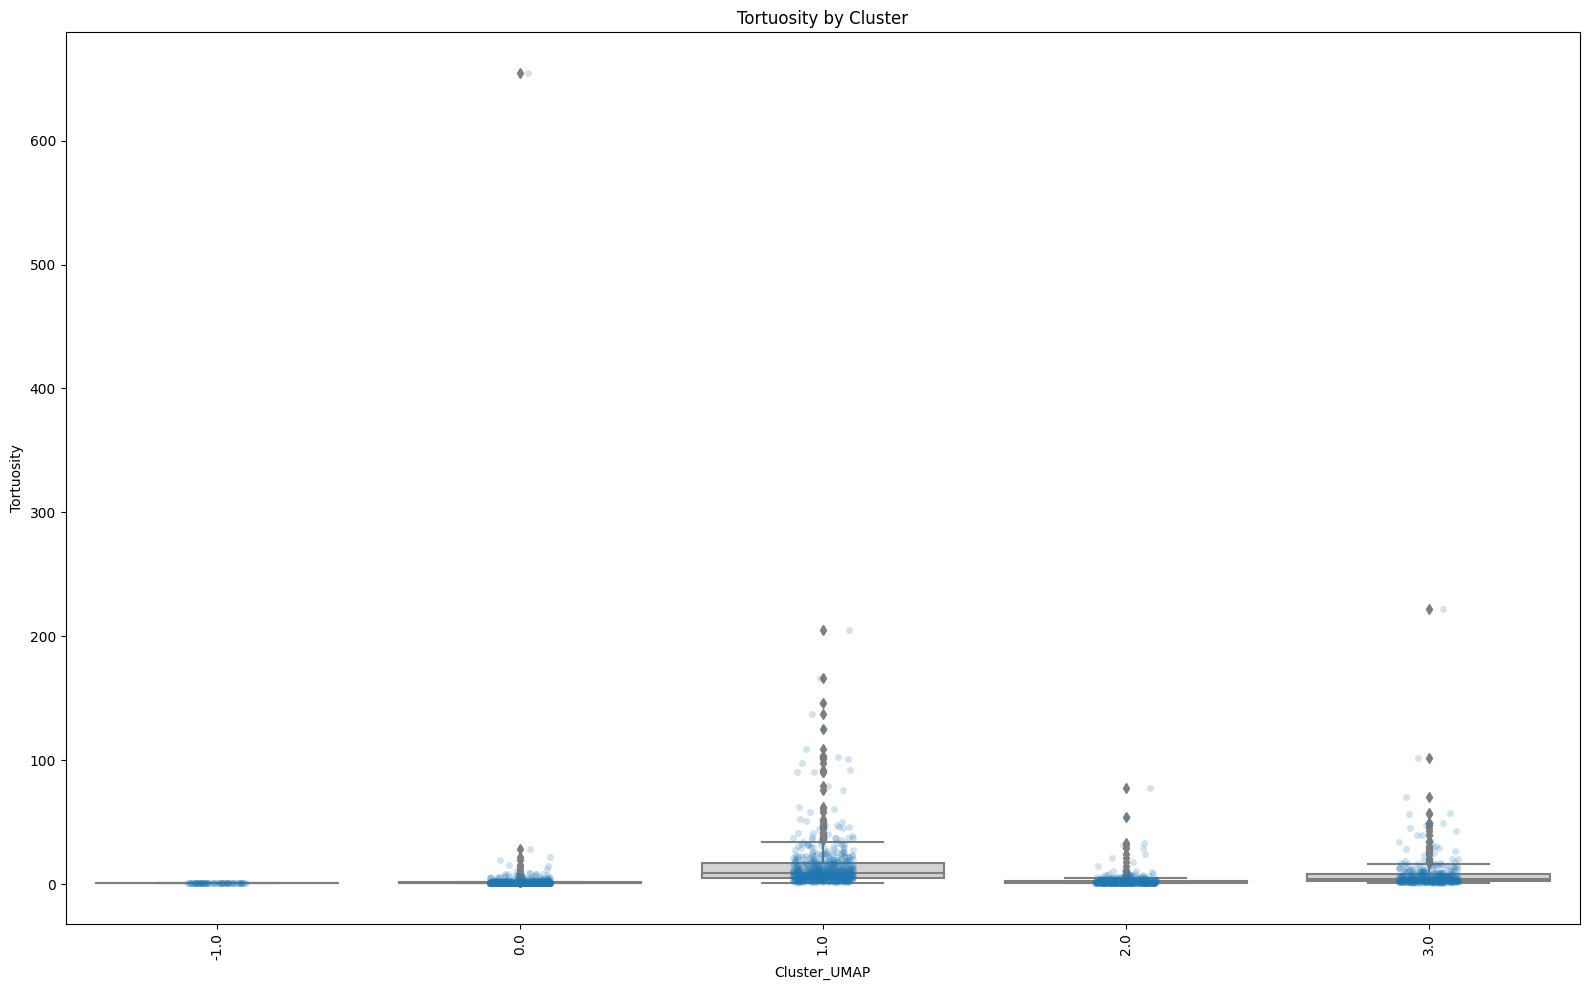

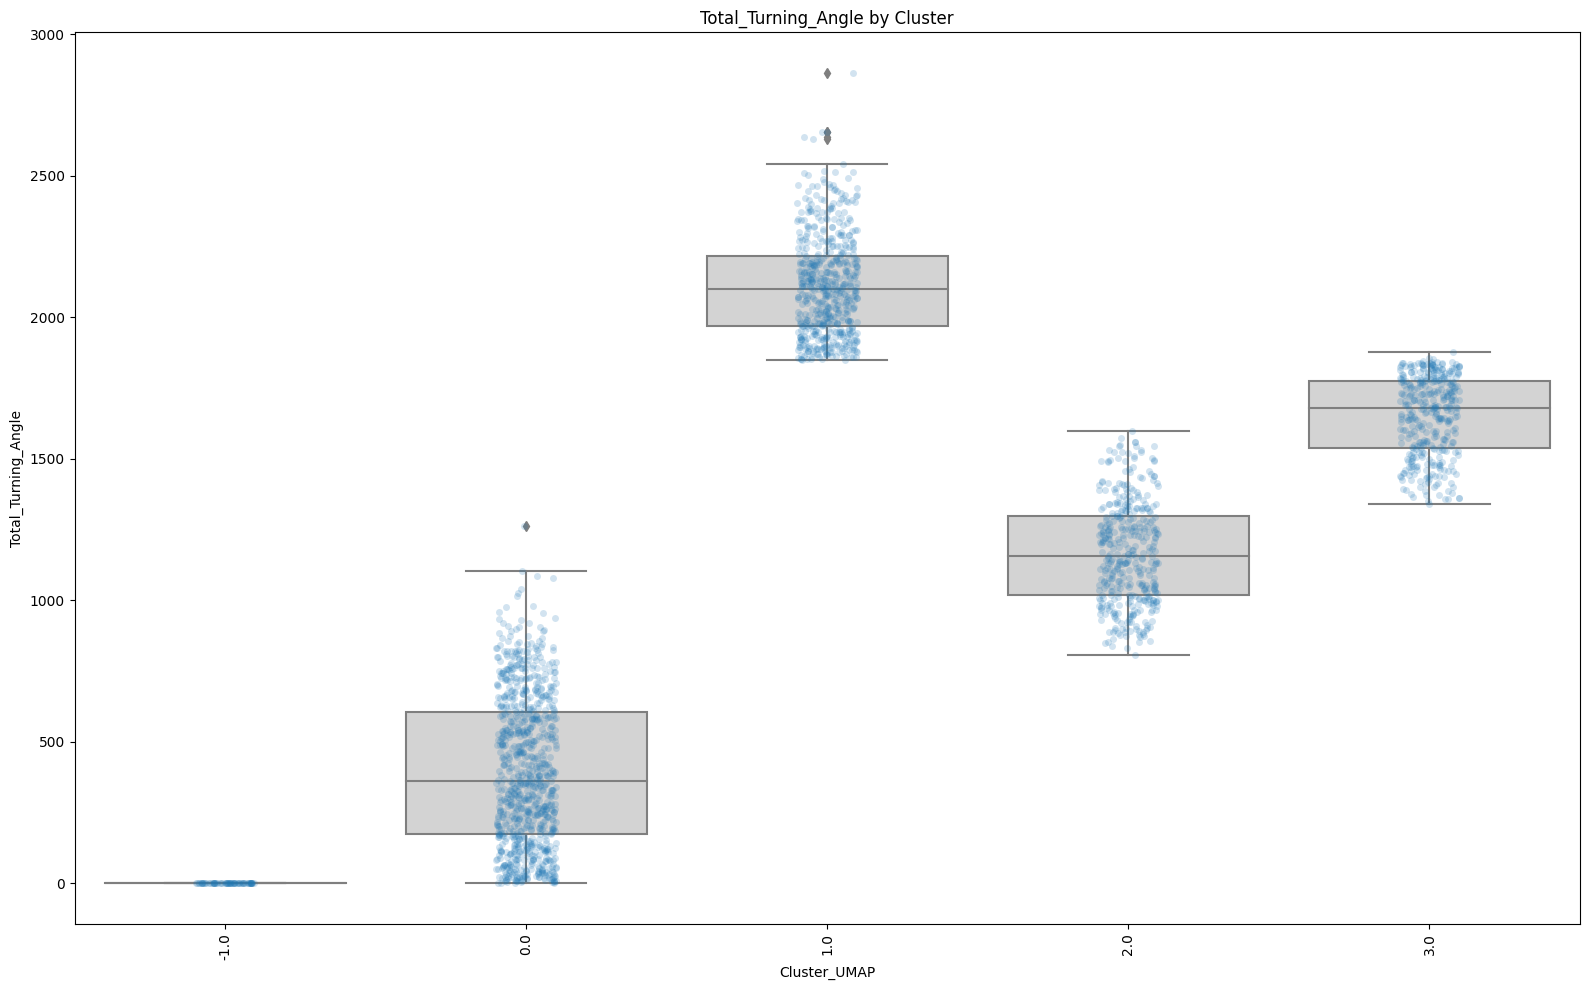

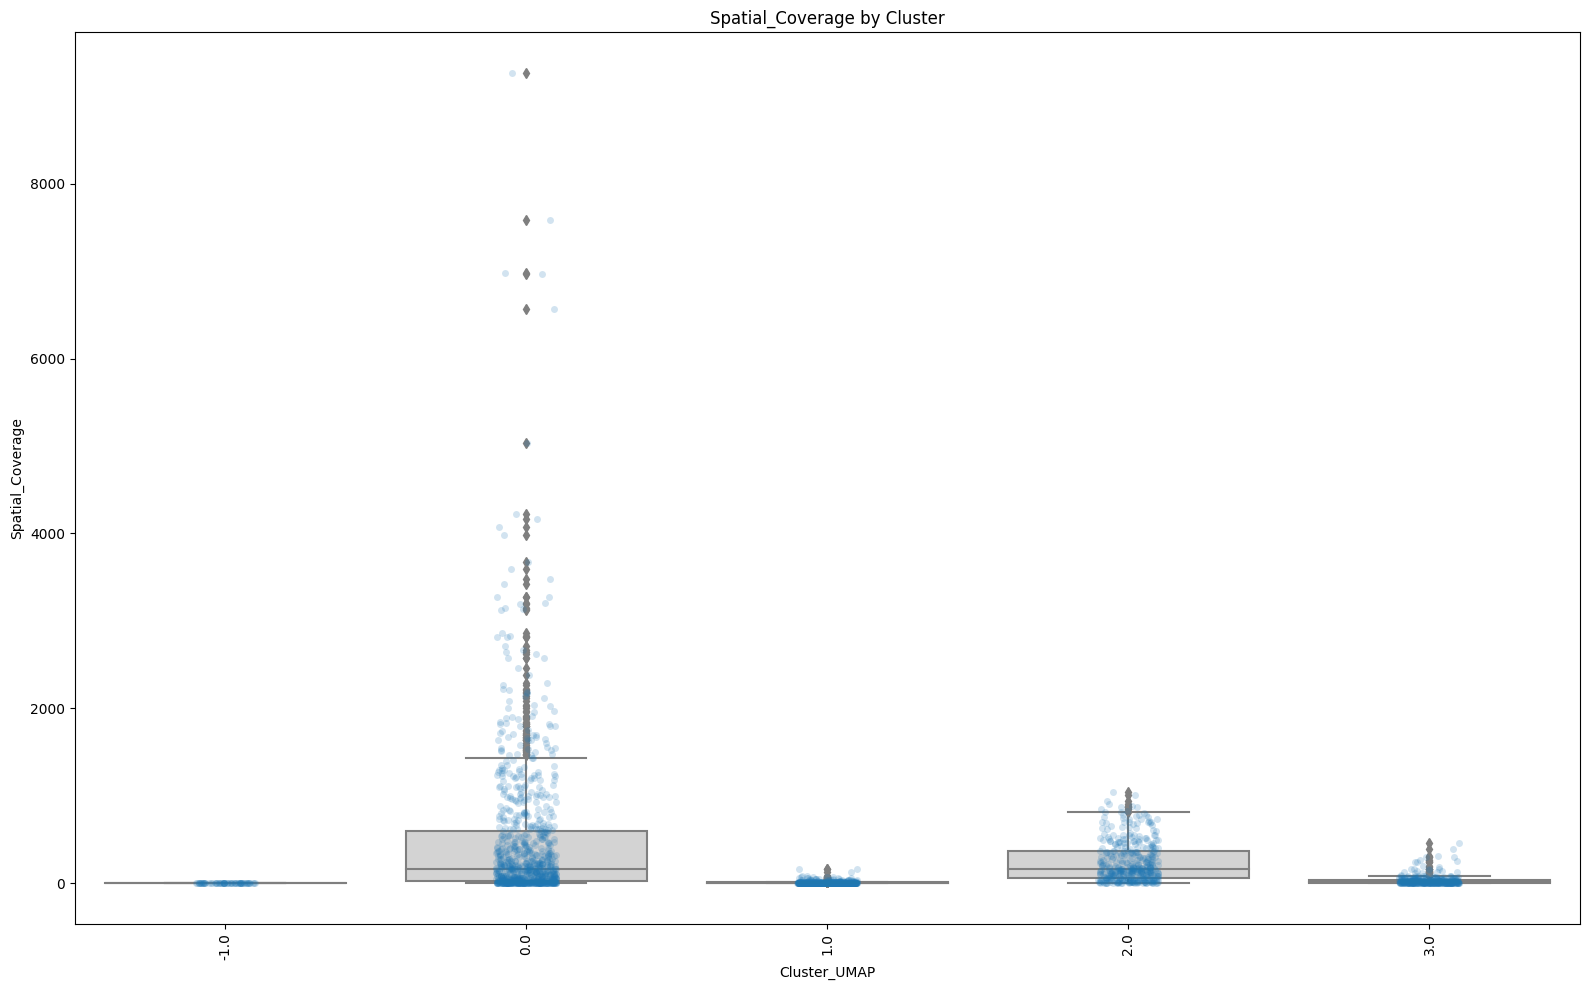

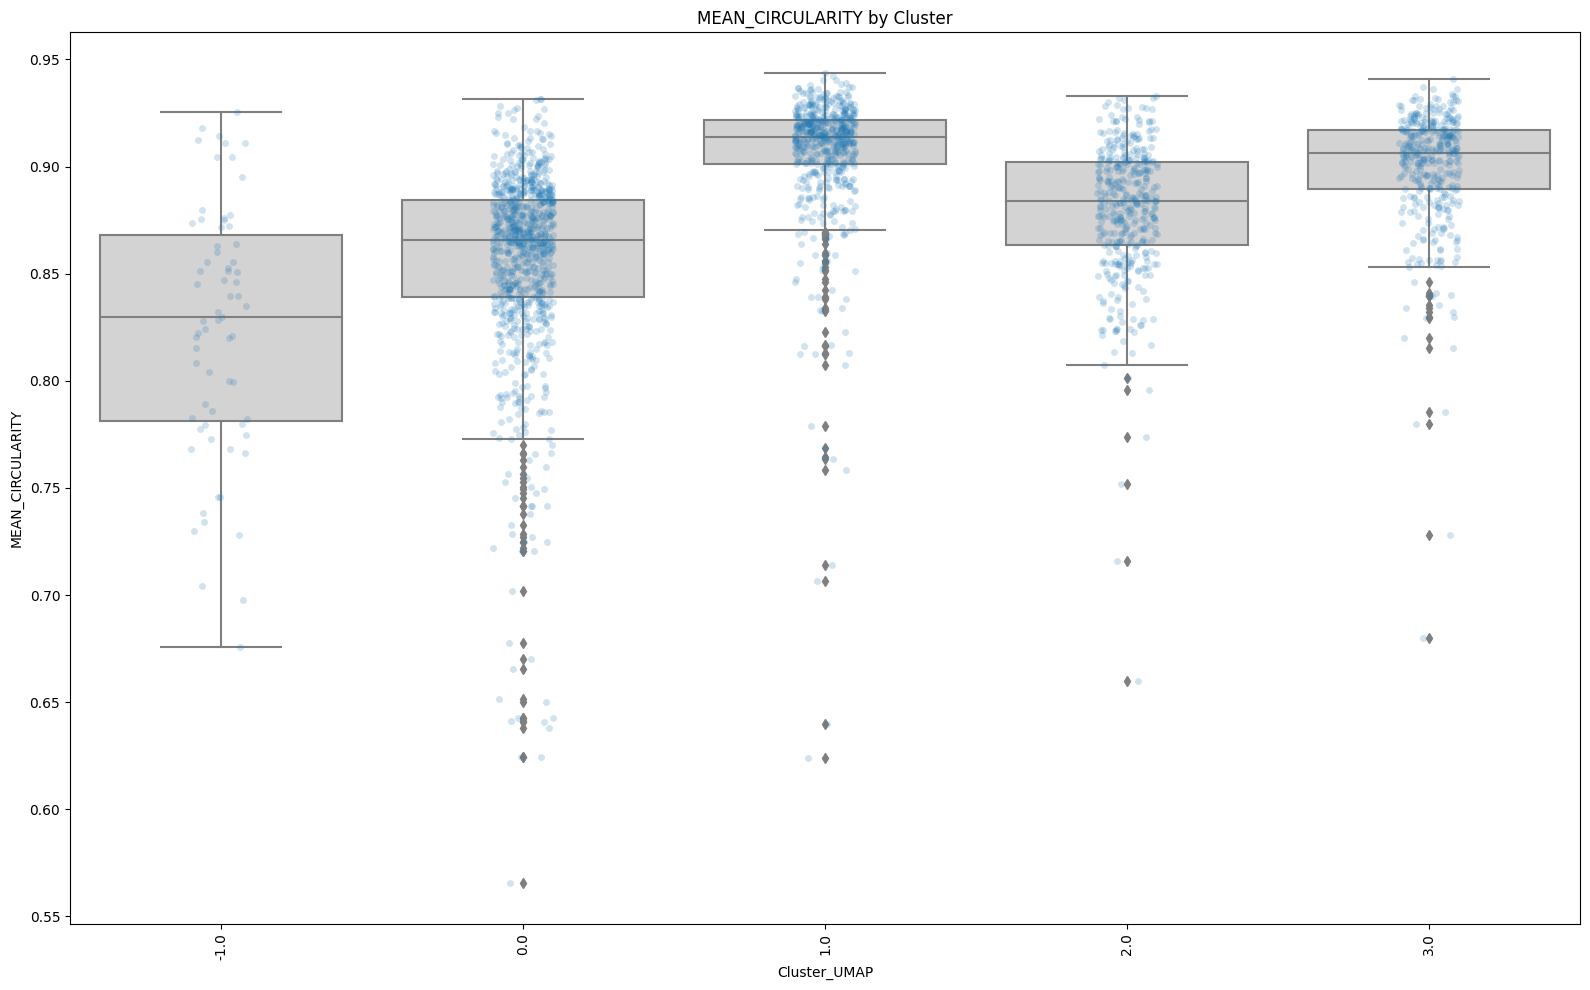

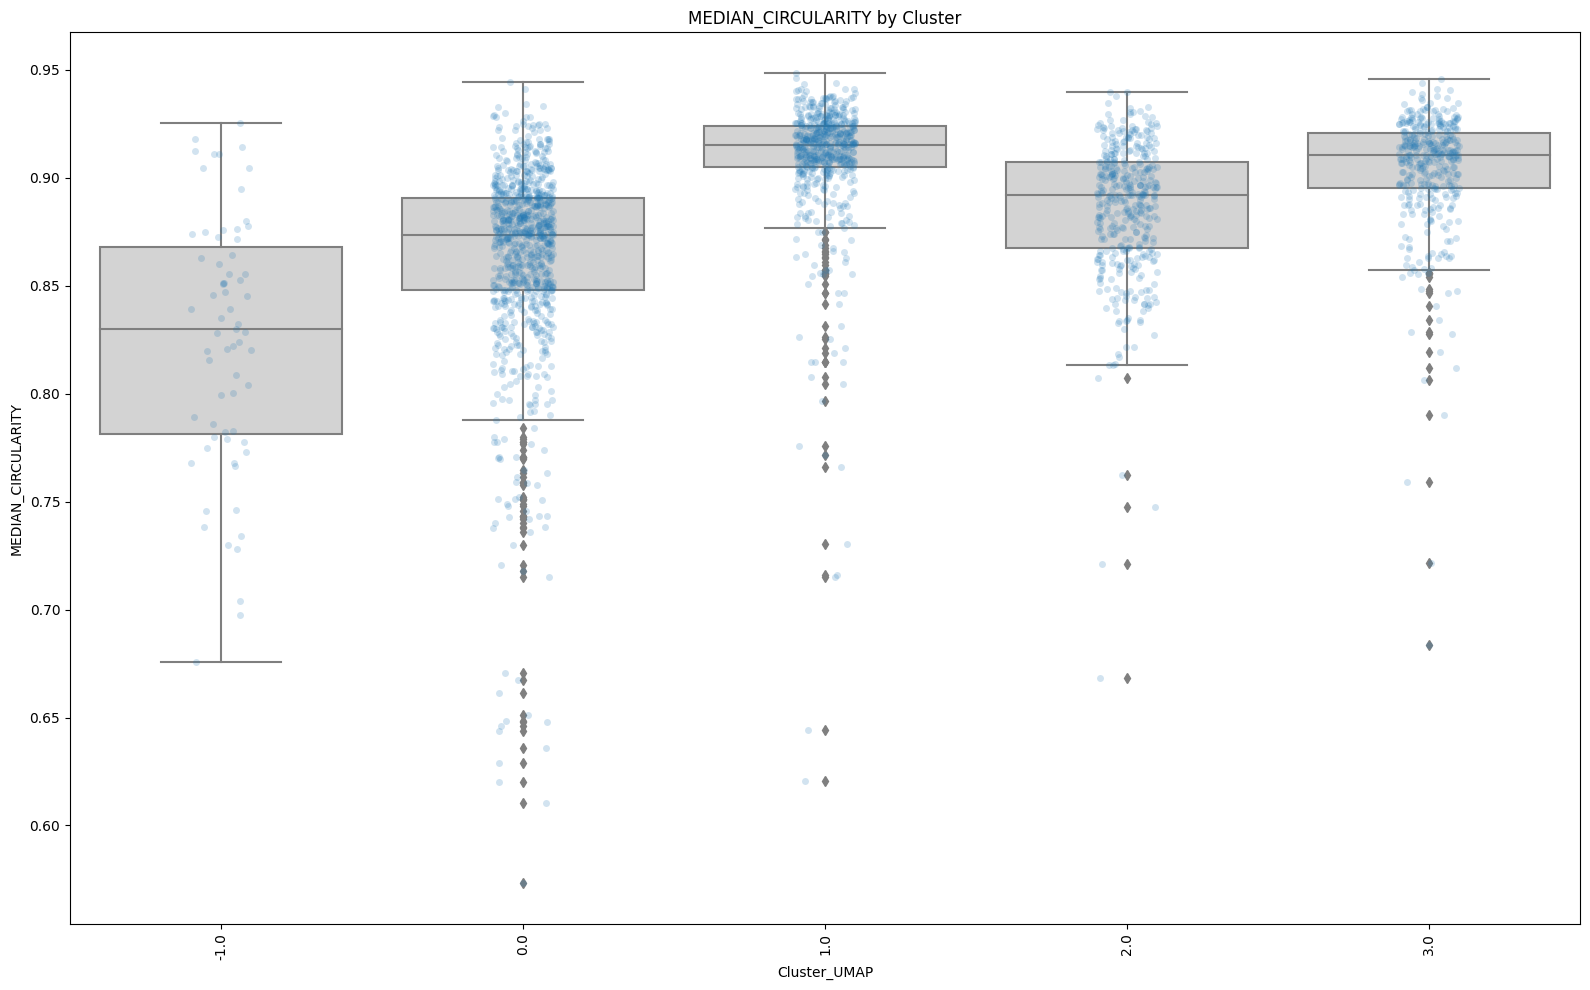

In [ ]:
import os
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
import pandas as pd
import ipywidgets as widgets

# @title ##Plot track parameters based on clusters

# Check and create "pdf" folder
if not os.path.exists(f"{Results_Folder}/Umap/Track_parameters"):
    os.makedirs(f"{Results_Folder}/Umap/Track_parameters")

def get_selectable_columns(df):
    # Exclude certain columns from being plotted
    exclude_cols = ['Condition', 'experiment_nb', 'File_name', 'Repeat', 'Unique_ID', 'LABEL', 'TRACK_INDEX', 'TRACK_ID', 'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION', 'Exemplar','TRACK_STOP', 'TRACK_START', 'Cluster_UMAP', 'Cluster_tsne']
    return [col for col in df.columns if col not in exclude_cols]

def display_variable_checkboxes(selectable_columns):
    # Create checkboxes for selectable columns
    variable_checkboxes = [widgets.Checkbox(value=False, description=col) for col in selectable_columns]

    # Display checkboxes in the notebook
    display(widgets.VBox([
        widgets.Label('Variables to Plot:'),
        widgets.GridBox(variable_checkboxes, layout=widgets.Layout(grid_template_columns="repeat(%d, 300px)" % 3)),
    ]))
    return variable_checkboxes

def plot_selected_vars(button, variable_checkboxes, df, Results_Folder):
    print("Plotting in progress...")

    # Get selected variables
    variables_to_plot = [box.description for box in variable_checkboxes if box.value]
    n_plots = len(variables_to_plot)

    if n_plots == 0:
        print("No variables selected for plotting")
        return

    for var in variables_to_plot:
        # Extract data for the specific variable and cluster
        data_to_save = df[['Cluster_UMAP', var]]

        # Save data for the plot to CSV
        data_to_save.to_csv(f"{Results_Folder}/Umap/Track_parameters/{var}_data_by_Cluster.csv", index=False)

        plt.figure(figsize=(16, 10))

        # Plotting
        sns.boxplot(x='Cluster_UMAP', y=var, data=df, color='lightgray')  # Boxplot by cluster
        sns.stripplot(x='Cluster_UMAP', y=var, data=df, jitter=True, alpha=0.2)  # Individual data points

        plt.title(f"{var} by Cluster")
        plt.xlabel('Cluster_UMAP')
        plt.ylabel(var)
        plt.xticks(rotation=90)
        plt.tight_layout()

        # Save the plot
        plt.savefig(f"{Results_Folder}/Umap/Track_parameters/{var}_Boxplots_by_Cluster.pdf")
        plt.show()

selectable_columns = get_selectable_columns(merged_tracks_df)
variable_checkboxes = display_variable_checkboxes(selectable_columns)

# Create and display the plot button
button = widgets.Button(description="Plot Selected Variables", layout=widgets.Layout(width='400px'))
button.on_click(lambda b: plot_selected_vars(b, variable_checkboxes, merged_tracks_df, Results_Folder))
display(button)


## **5.7. Plot track parameters for a selected cluster**
---

In [ ]:
# @title ##Plot track parameters for a selected cluster


# Check and create "cluster_plots" folder
if not os.path.exists(f"{Results_Folder}/Umap/cluster_plots"):
    os.makedirs(f"{Results_Folder}/Umap/cluster_plots")

# Check and create "pdf" folder
if not os.path.exists(f"{Results_Folder}/Umap/cluster_plots/pdf"):
    os.makedirs(f"{Results_Folder}/Umap/cluster_plots/pdf")

# Check and create "csv" folder
if not os.path.exists(f"{Results_Folder}/Umap/cluster_plots/csv"):
    os.makedirs(f"{Results_Folder}/Umap/cluster_plots/csv")

def get_selectable_columns(df):
    # Exclude certain columns from being plotted
    exclude_cols = ['Condition', 'experiment_nb', 'File_name', 'Repeat', 'Unique_ID', 'LABEL', 'TRACK_INDEX', 'TRACK_ID', 'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION', 'Exemplar','TRACK_STOP', 'TRACK_START', 'Cluster_UMAP', 'Cluster_tsne']
    return [col for col in df.columns if col not in exclude_cols]


def display_cluster_dropdown(df):
    # Extract unique clusters
    unique_clusters = df['Cluster_UMAP'].unique()
    cluster_dropdown = widgets.Dropdown(
        options=unique_clusters,
        description='Select Cluster:',
        disabled=False,
    )
    display(cluster_dropdown)
    return cluster_dropdown

def display_variable_checkboxes(selectable_columns):
    # Create checkboxes for selectable columns
    variable_checkboxes = [widgets.Checkbox(value=False, description=col) for col in selectable_columns]

    # Display checkboxes in the notebook
    display(widgets.VBox([
        widgets.Label('Variables to Plot:'),
        widgets.GridBox(variable_checkboxes, layout=widgets.Layout(grid_template_columns="repeat(%d, 300px)" % 3)),
    ]))
    return variable_checkboxes

def plot_selected_vars(button, variable_checkboxes, cluster_dropdown, df, Results_Folder):
    selected_cluster = cluster_dropdown.value
    print(f"Plotting in progress for Cluster {selected_cluster}...")

    # Attempt to filter the dataframe for the selected cluster
    filtered_df = df[df['Cluster_UMAP'] == selected_cluster]

    # Get selected variables
    variables_to_plot = [box.description for box in variable_checkboxes if box.value]
    n_plots = len(variables_to_plot)

    if n_plots == 0:
        print("No variables selected for plotting")
        return
# Initialize matrices to store effect sizes and p-values for each variable
    effect_size_matrices = {}
    p_value_matrices = {}
    bonferroni_matrices = {}

    unique_conditions = filtered_df['Condition'].unique().tolist()
    num_comparisons = len(unique_conditions) * (len(unique_conditions) - 1) // 2
    alpha = 0.05
    corrected_alpha = alpha / num_comparisons
    n_iterations = 1000

# Loop through each variable to plot
    for var in variables_to_plot:

      pdf_pages = PdfPages(f"{Results_Folder}/Umap/cluster_plots/pdf/Cluster_{selected_cluster}_{var}_Boxplots_and_Statistics.pdf")
      effect_size_matrix = pd.DataFrame(index=unique_conditions, columns=unique_conditions)
      p_value_matrix = pd.DataFrame(index=unique_conditions, columns=unique_conditions)
      bonferroni_matrix = pd.DataFrame(index=unique_conditions, columns=unique_conditions)

      for cond1, cond2 in itertools.combinations(unique_conditions, 2):
        group1 = filtered_df[filtered_df['Condition'] == cond1][var]
        group2 = filtered_df[filtered_df['Condition'] == cond2][var]

        original_d = cohen_d(group1, group2)
        effect_size_matrix.loc[cond1, cond2] = original_d
        effect_size_matrix.loc[cond2, cond1] = original_d  # Mirroring

        count_extreme = 0
        for i in range(n_iterations):
            combined = pd.concat([group1, group2])
            shuffled = combined.sample(frac=1, replace=False).reset_index(drop=True)
            new_group1 = shuffled[:len(group1)]
            new_group2 = shuffled[len(group1):]

            new_d = cohen_d(new_group1, new_group2)
            if np.abs(new_d) >= np.abs(original_d):
                count_extreme += 1

        p_value = count_extreme / n_iterations
        p_value_matrix.loc[cond1, cond2] = p_value
        p_value_matrix.loc[cond2, cond1] = p_value  # Mirroring

        # Apply Bonferroni correction
        bonferroni_corrected_p_value = min(p_value * num_comparisons, 1.0)
        bonferroni_matrix.loc[cond1, cond2] = bonferroni_corrected_p_value
        bonferroni_matrix.loc[cond2, cond1] = bonferroni_corrected_p_value  # Mirroring

      effect_size_matrices[var] = effect_size_matrix
      p_value_matrices[var] = p_value_matrix
      bonferroni_matrices[var] = bonferroni_matrix

    # Concatenate the three matrices side-by-side
      combined_df = pd.concat(
        [
            effect_size_matrices[var].rename(columns={col: f"{col} (Effect Size)" for col in effect_size_matrices[var].columns}),
            p_value_matrices[var].rename(columns={col: f"{col} (P-Value)" for col in p_value_matrices[var].columns}),
            bonferroni_matrices[var].rename(columns={col: f"{col} (Bonferroni-corrected P-Value)" for col in bonferroni_matrices[var].columns})
        ], axis=1
    )

    # Save the combined DataFrame to a CSV file
      combined_df.to_csv(f"{Results_Folder}/Umap/cluster_plots/csv/Cluster_{selected_cluster}_{var}_statistics_combined.csv")

    # Create a new figure
      fig = plt.figure(figsize=(16, 10))

    # Create a gridspec for 2 rows and 4 columns
      gs = GridSpec(2, 3, height_ratios=[1.5, 1])

    # Create the ax for boxplot using the gridspec
      ax_box = fig.add_subplot(gs[0, :])

    # Extract the data for this variable
      data_for_var = filtered_df[['Condition', var, 'Repeat', 'File_name', 'Cluster_UMAP']]

    # Save the data_for_var to a CSV for replotting
      data_for_var.to_csv(f"{Results_Folder}/Umap/cluster_plots/csv/Cluster_{selected_cluster}_{var}_boxplot_data.csv", index=False)

    # Calculate the Interquartile Range (IQR) using the 25th and 75th percentiles
      Q1 = filtered_df[var].quantile(0.25)
      Q3 = filtered_df[var].quantile(0.75)
      IQR = Q3 - Q1

    # Define bounds for the outliers
      multiplier = 10
      lower_bound = Q1 - multiplier * IQR
      upper_bound = Q3 + multiplier * IQR

    # Plotting
      sns.boxplot(x='Condition', y=var, data=filtered_df, ax=ax_box, color='lightgray')  # Boxplot
      sns.stripplot(x='Condition', y=var, data=filtered_df, ax=ax_box, hue='Repeat', dodge=True, jitter=True, alpha=0.2)  # Individual data points
      ax_box.set_ylim([max(min(filtered_df[var]), lower_bound), min(max(filtered_df[var]), upper_bound)])
      ax_box.set_title(f"{var} for Cluster {selected_cluster}")
      ax_box.set_xlabel('Condition')
      ax_box.set_ylabel(var)
      ax_box.set_xticklabels(ax_box.get_xticklabels(), rotation=90)
      ax_box.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Repeat')

    # Statistical Analyses and Heatmaps

    # Effect Size heatmap ax
      ax_d = fig.add_subplot(gs[1, 0])
      sns.heatmap(effect_size_matrices[var].fillna(0), annot=True, cmap="coolwarm", cbar=True, square=True, ax=ax_d)
      ax_d.set_title(f"Effect Size (Cohen's d) for {var}")

    # p-value heatmap ax
      ax_p = fig.add_subplot(gs[1, 1])
      sns.heatmap(p_value_matrices[var].fillna(1), annot=True, cmap="viridis_r", cbar=True, square=True, ax=ax_p, vmax=0.1)
      ax_p.set_title(f"Randomization Test p-value for {var}")

    # Bonferroni corrected p-value heatmap ax
      ax_bonf = fig.add_subplot(gs[1, 2])
      sns.heatmap(bonferroni_matrices[var].fillna(1), annot=True, cmap="viridis_r", cbar=True, square=True, ax=ax_bonf, vmax=0.1)
      ax_bonf.set_title(f"Bonferroni-corrected p-value for {var}")

      plt.tight_layout()
      pdf_pages.savefig(fig)

    # Close the PDF
      pdf_pages.close()

selectable_columns = get_selectable_columns(merged_tracks_df)
variable_checkboxes = display_variable_checkboxes(selectable_columns)
cluster_dropdown = display_cluster_dropdown(merged_tracks_df)

#merged_tracks_df = merged_tracks_df.dropna

# Create and display the plot button
button = widgets.Button(description="Plot Selected Variables", layout=widgets.Layout(width='400px'), button_style='info')
button.on_click(lambda b: plot_selected_vars(b, variable_checkboxes, cluster_dropdown, merged_tracks_df, Results_Folder))
display(button)

Output hidden; open in https://colab.research.google.com to view.

## **5.8. Identify exemplar tracks from each clusters**
---

<font size = 4>Exemplars, in the context of clustering analysis, refer to representative data points that are selected to encapsulate the essential characteristics of a cluster. They are often chosen because they are central or prototypical members of a cluster, making them valuable for summarizing the cluster's properties. In the provided code, exemplars are identified using the HDBSCAN clustering algorithm and marked within the dataset.

<font size = 4>**Keep in mind that not all cluster will have examplar**.


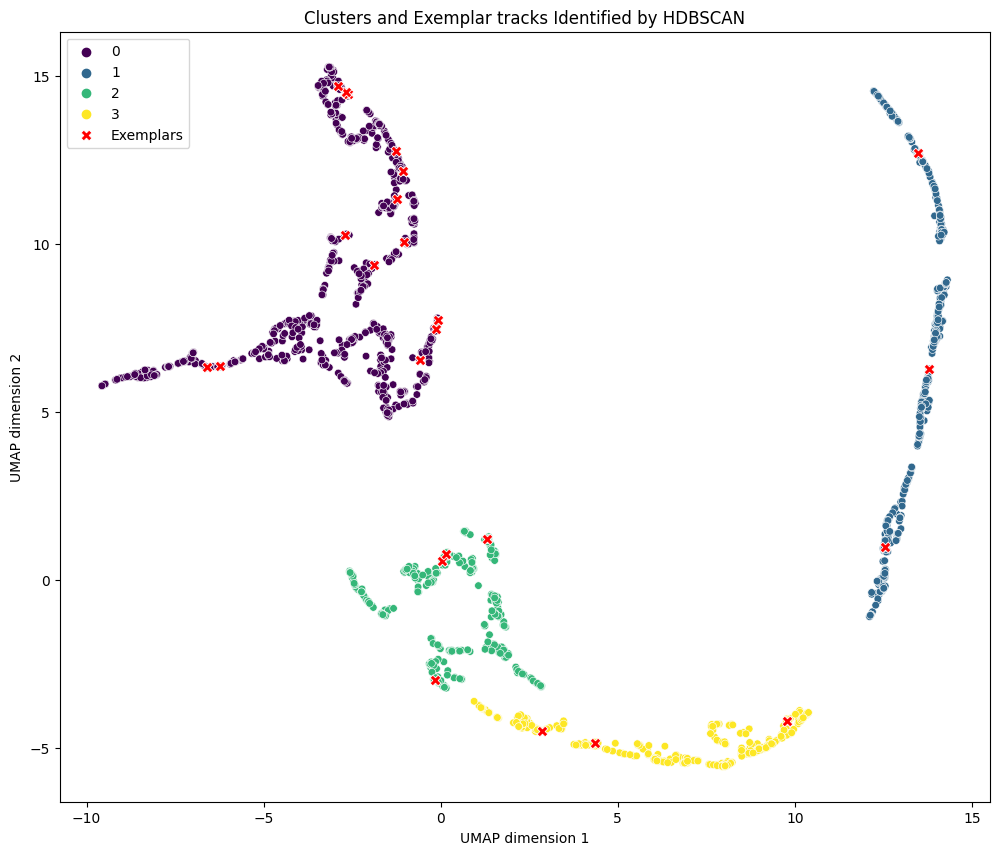

In [ ]:
import plotly.express as px  # Importing plotly for 3D plots

# @title ##Identify exemplar tracks using HDBSCAN

#@markdown ###Display parameters:
spot_size = 30 # @param {type: "number"}

# Check and create "pdf" folder
if not os.path.exists(f"{Results_Folder}/Umap/Examplar"):
    os.makedirs(f"{Results_Folder}/Umap/Examplar")

# Extracting exemplar points
exemplars = []
for exemplar in clusterer.exemplars_:
    exemplars.extend(exemplar)

# Flatten the exemplars list of lists into a single list
flattened_exemplars = [index for sublist in exemplars for index in sublist]

# Now pass the flattened list to iloc
exemplar_df = umap_df.iloc[flattened_exemplars]

# Deduplicate exemplar_df based on 'Unique_ID'
exemplar_df = exemplar_df.drop_duplicates(subset='Unique_ID')

# Create a new column in exemplar_df to indicate it's an exemplar
exemplar_df['Exemplar'] = 1

# If the Exemplar column already exists in merged_tracks_df, drop it to avoid duplications
if 'Exemplar' in merged_tracks_df.columns:
    merged_tracks_df.drop(columns='Exemplar', inplace=True)

# Merge the Exemplar column from exemplar_df to merged_tracks_df based on Unique_ID
merged_tracks_df = pd.merge(merged_tracks_df, exemplar_df[['Unique_ID', 'Exemplar']], on='Unique_ID', how='left')

# Handle cases where some rows in merged_tracks_df might not have a corresponding Exemplar label
merged_tracks_df['Exemplar'].fillna(0, inplace=True)  # Assigning 0 to cells that were not identified as exemplars

# Save the DataFrame with the identified clusters Exemplar label
merged_tracks_df.to_csv(Results_Folder + '/' + 'merged_Tracks.csv', index=False)


# Plotting clusters and exemplar points
if n_dimension == 1:
    plt.figure(figsize=(12,10))
    sns.stripplot(x='UMAP dimension 1', hue='Cluster_UMAP', data=umap_df, palette='viridis', jitter=0.05, size=spot_size)
    sns.stripplot(x='UMAP dimension 1', color='red', label='Exemplars', data=exemplar_df, jitter=0.05, size=spot_size, marker='X')
    plt.title('Clusters and Exemplar tracks Identified by HDBSCAN')
    plt.show()

elif n_dimension == 2:
    plt.figure(figsize=(12,10))
    sns.scatterplot(x='UMAP dimension 1', y='UMAP dimension 2', hue='Cluster_UMAP', palette='viridis', data=umap_df, s=spot_size)
    sns.scatterplot(x='UMAP dimension 1', y='UMAP dimension 2', color='red', label='Exemplars', data=exemplar_df, s=spot_size*2, marker='X')
    plt.title('Clusters and Exemplar tracks Identified by HDBSCAN')
    plt.show()

elif n_dimension == 3:
    fig = px.scatter_3d(umap_df,
                        x='UMAP dimension 1',
                        y='UMAP dimension 2',
                        z='UMAP dimension 3',
                        color='Cluster_UMAP',
                        color_discrete_sequence=px.colors.qualitative.Vivid)

    # Add a new column for coloring exemplars
    exemplar_df['ExemplarColor'] = 'Exemplar'
    exemplar_fig = px.scatter_3d(exemplar_df,
                                 x='UMAP dimension 1',
                                 y='UMAP dimension 2',
                                 z='UMAP dimension 3',
                                 color='ExemplarColor',
                                 color_discrete_map={'Exemplar':'red'})

    for trace in fig.data:
        trace.marker.size = spot_size

    for trace in exemplar_fig.data:
        trace.marker.size = spot_size
        trace.marker.symbol = 'x'

    fig.add_trace(exemplar_fig.data[0])
    fig.show()
    pyo.plot(fig, filename=f"{Results_Folder}/Umap/Examplar/HDBSCAN_examplar.html", auto_open=False)


## **5.9. See the exemplar tracks**
---

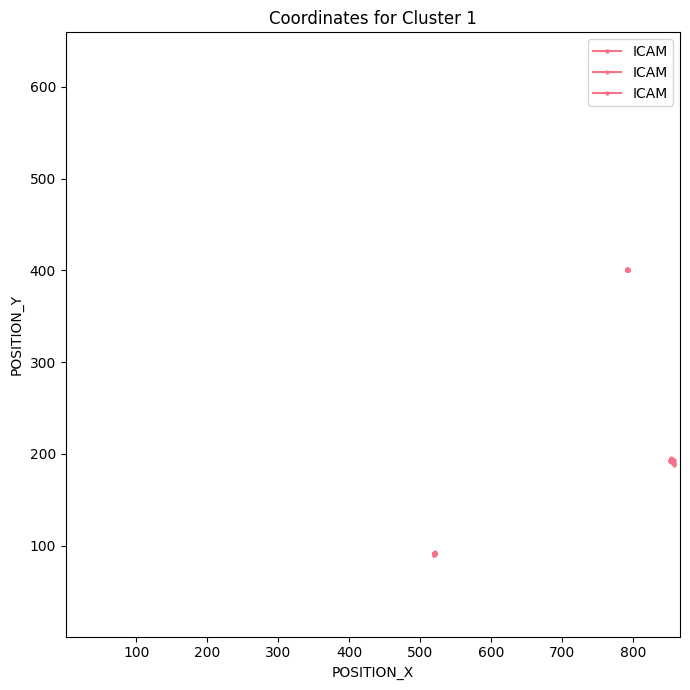

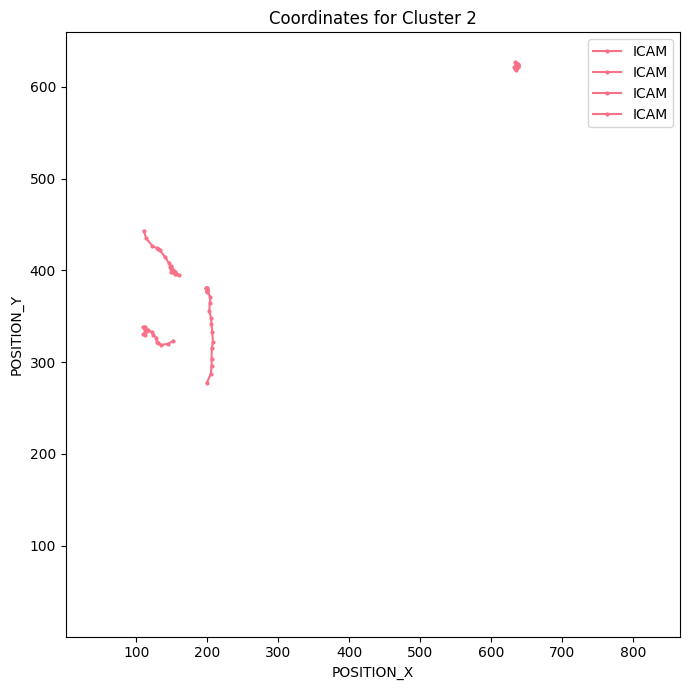

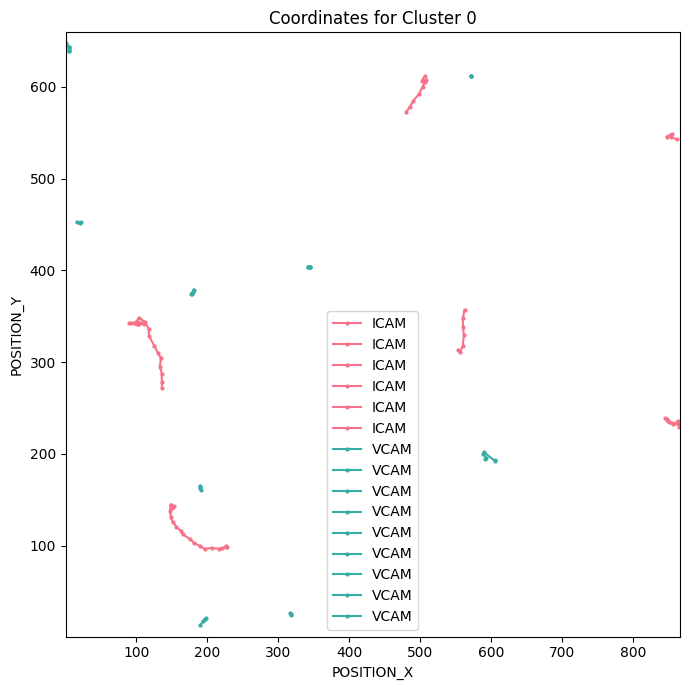

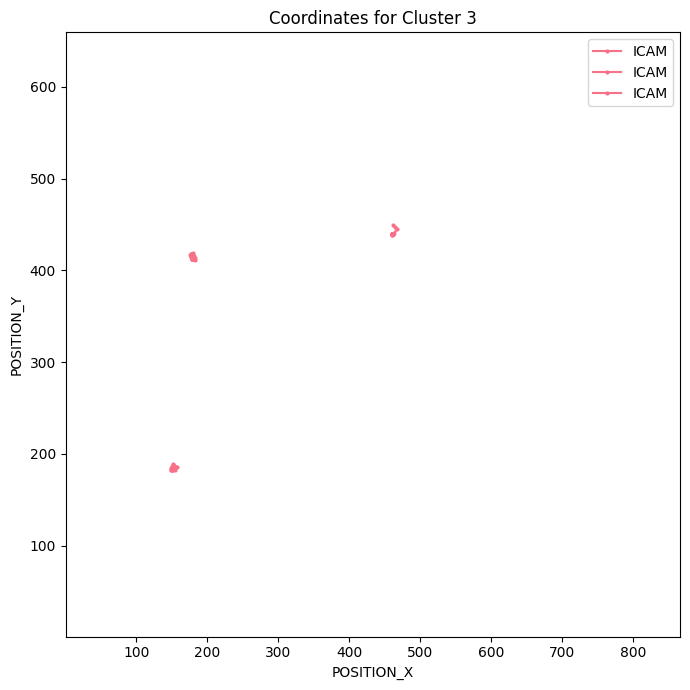

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# @title ##Plot the examplar tracks for each cluster

# Check and create "pdf" folder
if not os.path.exists(f"{Results_Folder}/Umap/Examplar"):
    os.makedirs(f"{Results_Folder}/Umap/Examplar")


# Extracting actual indices for exemplar rows
exemplar_indices = umap_df.iloc[flattened_exemplars].index

# Add a new column to umap_df to indicate if a point is an exemplar
umap_df['Exemplar'] = 0

# Mark the rows corresponding to exemplars as 1
umap_df.loc[exemplar_indices, 'Exemplar'] = 1

# Determine max and min coordinates from the DataFrame
min_x = merged_spots_df['POSITION_X'].min()
max_x = merged_spots_df['POSITION_X'].max()
min_y = merged_spots_df['POSITION_Y'].min()
max_y = merged_spots_df['POSITION_Y'].max()

# Extract exemplars from the umap_df
exemplar_info = umap_df[umap_df['Exemplar'] == 1]

# Determine the unique clusters from exemplar_info
clusters = exemplar_info['Cluster_UMAP'].unique()

# Create a PDF object to save the plots
with PdfPages(f"{Results_Folder}/Umap/Examplar/Examplar_tracks_Clusters.pdf") as pdf:

    # Iterate over each cluster
    for cluster in clusters:

        # Start a new figure for this cluster
        plt.figure(figsize=(7, 7))

        # Extract unique IDs for the current cluster from exemplar_info
        cluster_unique_ids = exemplar_info[exemplar_info['Cluster_UMAP'] == cluster]['Unique_ID'].tolist()

        # For each unique ID in the cluster, plot the track
        for unique_id in cluster_unique_ids:

            # Filter dataframe based on the unique ID
            unique_df = merged_spots_df[merged_spots_df['Unique_ID'] == unique_id].sort_values(by='POSITION_T')

            # Color code tracks based on 'Condition' using seaborn's color palette
            color = sns.color_palette('husl', n_colors=merged_spots_df['Condition'].nunique())[merged_spots_df['Condition'].unique().tolist().index(unique_df['Condition'].iloc[0])]

            plt.plot(unique_df['POSITION_X'], unique_df['POSITION_Y'], marker='o', linestyle='-', markersize=2, color=color, label=unique_df['Condition'].iloc[0])

            # Set title for the subplot
            plt.title(f'Coordinates for Cluster {cluster}')

            # Limit the plot dimensions based on your data's extent
            plt.xlim(min_x - 1, max_x + 1)
            plt.ylim(min_y - 1, max_y + 1)

            # Add legend to differentiate tracks based on condition
            plt.legend(loc='best')

            plt.xlabel('POSITION_X')
            plt.ylabel('POSITION_Y')

        # Save the figure in the PDF
        pdf.savefig()

# Adjust layout to avoid overlap
        plt.tight_layout()

        plt.show()


## **5.10. Find the exemplar on your raw images**
--------


<font size = 4>This Python script serves as a user-friendly tool for visualizing exemplar tracks within your microscopy video.

<font size = 4>To utilize it effectively, **users should provide the path to the directory containing the raw stacks of their data**.
<font size = 4>It's essential to ensure that these stack files have the same name as the
*  Use .tif or .tiff files only
*  It's essential to ensure that these tif files have the same name as the corresponding CSV file used in the analysis.
*   The Tif files can be in the same folder as your csv file

<font size = 4>Additionally, users are required to **specify the pixel calibration** value to accurately scale the visualization.
*   Use the same calibration as the one used in TrackMate


<font size = 4>With these inputs, the script automates the retrieval of matching TIFF files, adjusts for pixel calibration, and overlays vital information on video frames. Users can interactively select a specific cluster and initiate the visualization process with a single click.

In [ ]:
import requests
import zipfile
import os
from tqdm import tqdm
from tifffile import imread
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, widgets, Button, Output
from IPython.display import clear_output

# @title ##Find your examplar tracks

#@markdown ###Are you using the test dataset?

Use_test_dataset = False #@param {type:"boolean"}

#@markdown ###Or provide the path to the folder containing your .tif files

Video_path = '/gdrive/MyDrive/Work/manuscript/Ongoing Projects/Colab analyse my cell tracks/Test_datasets/T_Cells/Tracks'  # @param {type: "string"}

#@markdown ###Provide the pixel calibration

Pixel_calibration = 0.6450002 # @param {type: "number"}

# Error message widget
error_output = Output()

if Use_test_dataset:
  Video_path = '/content/Tracks/Tracks'


# Function to display an error message
def display_error_message(message):
    with error_output:
        print(message)

def refined_find_matching_tiff_file(directory, filename):
    """Refined function to find a TIFF file that matches the given filename in the directory or its subdirectories."""
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Use exact string match for more accurate matching
            if file == filename + '.tif' or file == filename + '.tiff':
                return os.path.join(root, file)
    return None

def overlay_square_on_frame(frame, x, y, square_size=50, border_width=3):
    """Overlay a red square on a single frame."""
    overlaid_frame = frame.copy()

    half_size = square_size // 2

    # Define the coordinates for the top-left and bottom-right corners of the square
    top_left_x = max(0, x - half_size)
    top_left_y = max(0, y - half_size)
    bottom_right_x = min(frame.shape[1] - 1, x + half_size)
    bottom_right_y = min(frame.shape[0] - 1, y + half_size)

    # Overlay the red border on the frame
    # Horizontal lines
    overlaid_frame[top_left_y:top_left_y+border_width, top_left_x:bottom_right_x] = np.max(frame)
    overlaid_frame[bottom_right_y-border_width:bottom_right_y, top_left_x:bottom_right_x] = np.max(frame)

    # Vertical lines
    overlaid_frame[top_left_y:bottom_right_y, top_left_x:top_left_x+border_width] = np.max(frame)
    overlaid_frame[top_left_y:bottom_right_y, bottom_right_x-border_width:bottom_right_x] = np.max(frame)

    return overlaid_frame

# Function to visualize a track for a cluster
def visualize_track_for_cluster(cluster_number):
    # Filter merged_tracks_df for exemplars and the selected cluster
    exemplar_tracks = merged_tracks_df[(merged_tracks_df['Cluster_UMAP'] == cluster_number) & (merged_tracks_df['Exemplar'] == 1)]

    if exemplar_tracks.empty:
        display_error_message("No exemplar found for this cluster.")
        return

    for idx, track in exemplar_tracks.iterrows():
        # Get the filename
        filename = track['File_name']

        # Find the corresponding tiff file
        full_path = refined_find_matching_tiff_file(Video_path, filename)

        if not full_path:
            display_error_message(f"No matching .tif or .tiff file found for filename: {filename}")
            continue

        # Load the movie
        movie = imread(full_path)

        if len(movie.shape) != 3:
            display_error_message(f"Warning: The loaded movie from file '{filename}' is not 2D over time.")
            continue

        # Fetch the track coordinates from merged_spots_df and adjust for calibration
        track_id = track['Unique_ID']
        track_coordinates = merged_spots_df[merged_spots_df['Unique_ID'] == track_id][['POSITION_T', 'POSITION_X', 'POSITION_Y']].copy()
        track_coordinates['POSITION_X'] = track_coordinates['POSITION_X'] / Pixel_calibration
        track_coordinates['POSITION_Y'] = track_coordinates['POSITION_Y'] / Pixel_calibration

        # Define a function to update the display based on the frame slider
        def update_display(frame_number):
            plt.figure(figsize=(10, 10))
            frame_with_square = movie[frame_number, :, :].copy()
            coords_for_frame = track_coordinates[track_coordinates['POSITION_T'] == frame_number]
            if not coords_for_frame.empty:
                x, y = int(coords_for_frame['POSITION_X'].values[0]), int(coords_for_frame['POSITION_Y'].values[0])
                frame_with_square = overlay_square_on_frame(frame_with_square, x, y)
            plt.imshow(frame_with_square, cmap='gray')
            plt.title(f"Frame {frame_number} for Exemplar in Cluster {cluster_number} from file {filename}")
            plt.show()

        # Create a slider for frame navigation
        frame_slider = widgets.IntSlider(min=0, max=len(movie) - 1, description='Frame')

        # Display the visualization with interactive for more reactive updates
        w = interactive(update_display, frame_number=frame_slider)
        display(w)  # This line explicitly displays the widget
        break  # Only display for the first matching exemplar for the sake of demonstration

# Dropdown widget for cluster selection
clusters = merged_tracks_df['Cluster_UMAP'].unique()
cluster_dropdown = widgets.Dropdown(
    options=clusters,
    description='Select Cluster:',
    disabled=False,
)

# Button to trigger visualization
plot_button = Button(description="Plot")

# Function to handle button click
def on_plot_button_click(b):
    cluster_number = cluster_dropdown.value
        # Clear the previous output
    clear_output()

    display(cluster_dropdown)
    display(plot_button)
    display(error_output)
    visualize_track_for_cluster(cluster_number)

# Bind the function to the button click event
plot_button.on_click(on_plot_button_click)

# Display the widgets
display(cluster_dropdown)
display(plot_button)
display(error_output)


Dropdown(description='Select Cluster:', options=(1.0, 2.0, 0.0, 3.0, -1.0), value=1.0)

Button(description='Plot', style=ButtonStyle())

Output()

interactive(children=(IntSlider(value=0, description='Frame', max=20), Output()), _dom_classes=('widget-intera…

## **5.11. Export movies of the exemplar tracks**
---

In [ ]:
# @title ##Export movies with the examplar tracks labelled

import os
import numpy as np
from tifffile import imwrite
from tqdm.notebook import tqdm
import imageio

def percentile_normalize_and_convert_uint8(image_sequence, low_percentile=1, high_percentile=99):
    """
    Normalize the image sequence to 0-255 based on percentiles and convert to uint8.

    Parameters:
    - image_sequence: The sequence of images to be normalized.
    - low_percentile: Lower percentile value used for normalization.
    - high_percentile: Higher percentile value used for normalization.

    Returns:
    - Normalized image sequence in uint8 format.
    """
    # Compute the percentiles
    min_val = np.percentile(image_sequence, low_percentile)
    max_val = np.percentile(image_sequence, high_percentile)

    # Clip the values outside the percentiles and normalize
    normalized = 255 * (np.clip(image_sequence, min_val, max_val) - min_val) / (max_val - min_val)

    return normalized.astype(np.uint8)

# Function to find a TIFF file that matches the given filename in the directory or its subdirectories
def find_matching_tiff_file(directory, filename):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.startswith(filename) and (file.endswith('.tif') or file.endswith('.tiff')):
                return os.path.join(root, file)
    return None

def overlay_square_on_frame(frame, x, y, square_size=50, border_width=3):
    """Overlay a red square on a single frame."""
    overlaid_frame = frame.copy()

    half_size = square_size // 2

    # Define the coordinates for the top-left and bottom-right corners of the square
    top_left_x = max(0, x - half_size)
    top_left_y = max(0, y - half_size)
    bottom_right_x = min(frame.shape[1] - 1, x + half_size)
    bottom_right_y = min(frame.shape[0] - 1, y + half_size)

    # Overlay the red border on the frame
    # Horizontal lines
    overlaid_frame[top_left_y:top_left_y+border_width, top_left_x:bottom_right_x] = np.max(frame)
    overlaid_frame[bottom_right_y-border_width:bottom_right_y, top_left_x:bottom_right_x] = np.max(frame)

    # Vertical lines
    overlaid_frame[top_left_y:bottom_right_y, top_left_x:top_left_x+border_width] = np.max(frame)
    overlaid_frame[top_left_y:bottom_right_y, bottom_right_x-border_width:bottom_right_x] = np.max(frame)

    return overlaid_frame

# Create a directory to store the exported videos
video_export_folder = Results_Folder + "/Umap/Examplar/Exported_Videos"
if not os.path.exists(video_export_folder):
    os.makedirs(video_export_folder)

# Iterate over all exemplar tracks
# Iterate over all exemplar tracks
for idx, track in tqdm(merged_tracks_df[merged_tracks_df['Exemplar'] == 1].iterrows(), total=merged_tracks_df[merged_tracks_df['Exemplar'] == 1].shape[0]):
    # Get the filename and cluster number
    filename = track['File_name']
    cluster_num = track['Cluster_UMAP']

    # Find the corresponding tiff file
    full_path = find_matching_tiff_file(Folder_path, filename)

    if not full_path:
        print(f"No matching .tif or .tiff file found for filename: {filename}")
        continue

    # Load the movie
    movie = imread(full_path)

    # Check dimensions to ensure 2D video
    if len(movie.shape) != 3:
        print(f"Skipping {filename} as it is not a 2D video.")
        continue

    # Fetch the track coordinates from merged_spots_df
    track_id = track['Unique_ID']
    track_coordinates = merged_spots_df[merged_spots_df['Unique_ID'] == track_id][['POSITION_T', 'POSITION_X', 'POSITION_Y']]

    # Overlay the track on the video using the overlay_square_on_frame function
    for _, coord in track_coordinates.iterrows():
        frame_number = int(coord['POSITION_T'])
        x = int(coord['POSITION_X'] / Pixel_calibration)
        y = int(coord['POSITION_Y'] / Pixel_calibration)
        movie[frame_number] = overlay_square_on_frame(movie[frame_number], x, y)

    # Incorporate the cluster number in the output filenames
    output_video_path_tiff = os.path.join(video_export_folder, f"{filename}_Cluster_{cluster_num}_with_track.tiff")
    output_video_path_mp4 = os.path.join(video_export_folder, f"{filename}_Cluster_{cluster_num}_with_track.mp4")

    # Save the video with overlaid track as TIFF
    imwrite(output_video_path_tiff, movie)

    # Normalize and convert the movie to uint8
    movie_uint8 = percentile_normalize_and_convert_uint8(movie)

    # Convert and save as MP4
    imageio.mimwrite(output_video_path_mp4, movie_uint8, fps=10)

print("Video export completed.")



  0%|          | 0/25 [00:00<?, ?it/s]

Video export completed.


--------
# **Part 6. Explore your high-dimensional data using t-SNE and HDBSCAN**
--------

## **6.1. Choose the track metrics to use for clustering**
--------

In [ ]:
# @title ##Choose the track metrics to use

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Check and create "pdf" folder
if not os.path.exists(f"{Results_Folder}/Tsne"):
    os.makedirs(f"{Results_Folder}/Tsne")


excluded_columns = ['Condition', 'experiment_nb', 'File_name', 'Repeat', 'Unique_ID', 'LABEL', 'TRACK_INDEX', 'TRACK_ID', 'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION', 'Exemplar','TRACK_STOP', 'TRACK_START', 'Cluster_UMAP', 'Cluster_tsne']

# Columns you want to always include
columns_to_include = ['File_name', 'Repeat', 'Condition', 'Unique_ID']

selected_df = pd.DataFrame()
nan_columns = pd.DataFrame()
# Extract the columns you always want to include and ensure they exist in the original dataframe
saved_columns = {col: merged_tracks_df[col].copy() for col in columns_to_include if col in merged_tracks_df}

# Filter out non-numeric columns
numeric_df = merged_tracks_df.select_dtypes(include=['float64', 'int64'])  # Selecting only numeric columns

column_names = [col for col in numeric_df.columns if col not in excluded_columns]

# Create a checkbox for each column
checkboxes = [widgets.Checkbox(value=True, description=col, indent=False) for col in column_names]

# Arrange checkboxes in a 2x grid
grid = widgets.GridBox(checkboxes, layout=widgets.Layout(grid_template_columns="repeat(2, 300px)"))

# Create a button to trigger the selection
button = widgets.Button(description="Select the track parameters", layout=widgets.Layout(width='400px'), button_style='info')

# Define the button click event handler
def on_button_click(b):
    global selected_df  # Declare selected_df as global
    global nan_columns
    # Get the selected columns from the checkboxes
    selected_columns = [box.description for box in checkboxes if box.value]

    # Extract the selected columns from the DataFrame
    selected_df = numeric_df[selected_columns].copy()

            # Prepare the parameters dictionary
    tsne_params = {
        'Selected Columns': ', '.join(selected_columns)
    }

    # Save the parameters
    params_file_path = os.path.join(Results_Folder, "Tsne/analysis_parameters.csv")
    save_parameters(tsne_params, params_file_path, 'tsne')

    # Add back the always-included columns to selected_df
    for col, data in saved_columns.items():
        selected_df.loc[:, col] = data

    # Check if the DataFrame has any NaN values and print a warning if it does.
    nan_columns = selected_df.columns[selected_df.isna().any()].tolist()

    if nan_columns:

        for col in nan_columns:
            selected_df = selected_df.dropna(subset=[col])  # Drop NaN values only from columns containing them

    print("Done")

# Set the button click event handler
button.on_click(on_button_click)

# Display the grid of checkboxes and the button
display(grid, button)



GridBox(children=(Checkbox(value=True, description='NUMBER_SPOTS', indent=False), Checkbox(value=True, descrip…

Button(button_style='info', description='Select the track parameters', layout=Layout(width='400px'), style=But…

Done


## **6.2. t-SNE**
--------

The code snippet provided performs **t-Distributed Stochastic Neighbor Embedding (t-SNE)**, a powerful technique for dimensionality reduction, particularly suited for the visualization of high-dimensional datasets. The process is applied to the merged tracks dataframe, focusing on its numeric columns, with the goal of visualizing the data in a lower-dimensional space.

### Key Parameters of t-SNE:

- **Perplexity (`perplexity`):**
  - This parameter is a measure of the effective number of local neighbors each point has.
  - Perplexity influences the t-SNE algorithm's ability to capture local versus global aspects of the data.
  - Typical values for perplexity range between 5 and 50, with the choice depending on dataset size and density.

- **Learning Rate (`learning_rate`):**
  - This parameter controls the step size in the optimization process.
  - A suitable learning rate helps t-SNE to converge to a meaningful low-dimensional representation.
  - Values too high might cause the algorithm to converge to a suboptimal solution, while too low values can slow down the convergence.

- **Number of Iterations (`n_iter`):**
  - This parameter defines the number of optimization iterations t-SNE will run.
  - A higher number of iterations allows the algorithm more time to find a stable configuration.
  - Generally, a value of 1000 iterations is sufficient for most datasets.

- **Number of Dimensions (`n_dimension`):**
  - The target dimensionality for the lower-dimensional space.
  - For visualization purposes, this is commonly set to 2, allowing the data to be plotted in a 2D scatter plot.


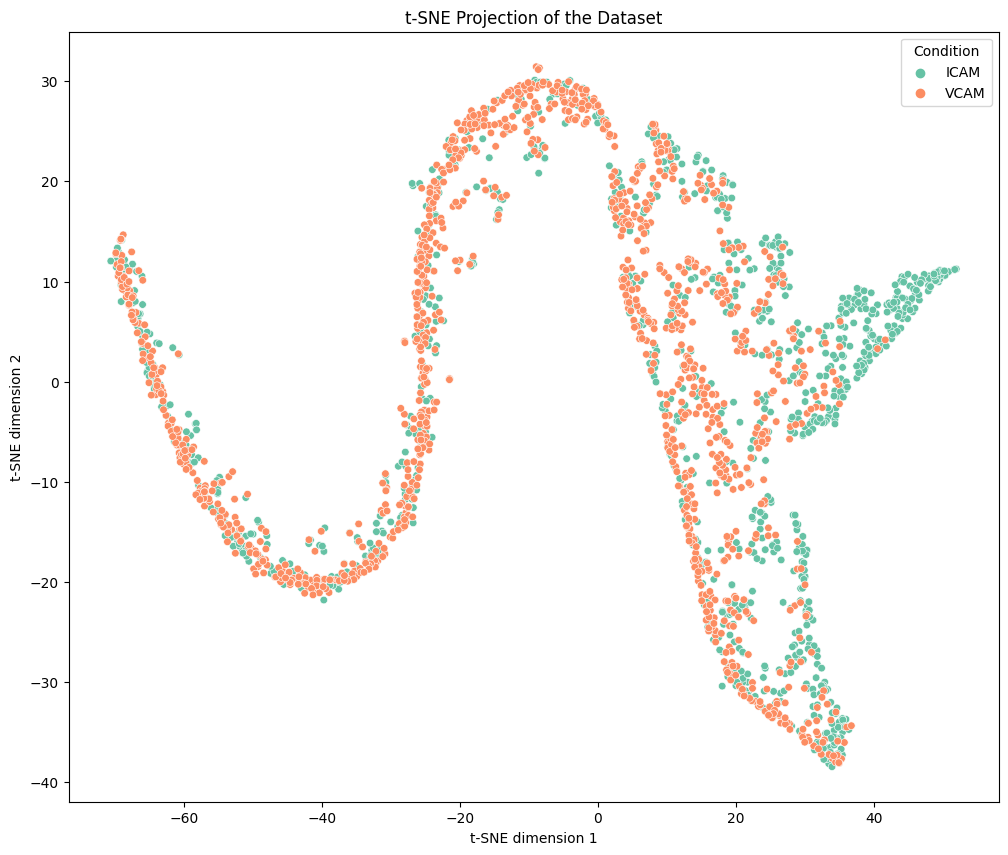

In [ ]:
# @title ##Perform t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import pandas as pd

# Check and create necessary directories
tsne_folder_path = f"{Results_Folder}/Tsne/"
if not os.path.exists(tsne_folder_path):
    os.makedirs(tsne_folder_path)

#@markdown ###t-SNE parameters:

perplexity = 50  # @param {type: "number"}
learning_rate = 200  # @param {type: "number"}
n_iter = 1000  # @param {type: "number"}
n_dimension = 2  # The number of dimensions is set to 2 for t-SNE as standard practice

#@markdown ###Display parameters:
spot_size = 30  # @param {type: "number"}

# Initialize t-SNE object with the specified settings
tsne = TSNE(n_components=n_dimension, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)

# Exclude non-numeric columns when fitting t-SNE
numeric_columns = selected_df._get_numeric_data()
embedding = tsne.fit_transform(numeric_columns)

  # Prepare the parameters dictionary
tsne_params = {
        'perplexity': perplexity,
        'learning_rate': learning_rate,
        'n_iter': n_iter,
        'n_dimension': n_dimension,
        'spot_size': spot_size
    }

    # Save the parameters
params_file_path = os.path.join(Results_Folder, "Tsne/analysis_parameters.csv")
save_parameters(tsne_params, params_file_path, 'tsne')

# Create dynamic column names based on n_components
column_names = [f't-SNE dimension {i+1}' for i in range(n_dimension)]

# Extract the columns_to_include from selected_df
included_data = selected_df[columns_to_include].reset_index(drop=True)

# Concatenate the t-SNE embedding with the included columns
tsne_df = pd.concat([pd.DataFrame(embedding, columns=column_names), included_data], axis=1)

# Check if the DataFrame has any NaN values and print a warning if it does.
nan_columns = tsne_df.columns[tsne_df.isna().any()].tolist()
if nan_columns:
  warnings.warn(f"The DataFrame contains NaN values in the following columns: {', '.join(nan_columns)}")
  tsne_df.dropna(subset=nan_columns, inplace=True)  # Drop NaN values only from columns containing them

# Visualize the t-SNE projection
plt.figure(figsize=(12, 10))
sns.scatterplot(x=column_names[0], y=column_names[1], hue='Condition', data=tsne_df, palette='Set2', s=spot_size)
plt.title('t-SNE Projection of the Dataset')
tsne_output_path = os.path.join(tsne_folder_path, 'tsne_projection_2D.pdf')
plt.savefig(tsne_output_path)  # Save 2D plot as PDF
plt.show()


## **6.3. HDBSCAN**
---

<font size = 4> The provided code employs HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) to identify clusters within a dataset that has already undergone UMAP dimensionality reduction. HDBSCAN is utilized for its proficiency in determining the optimal number of clusters while managing varied densities within the data.

<font size = 4>In the provided HDBSCAN code, the parameters `min_samples`, `min_cluster_size`, and `metric` are crucial for determining the structure and appearance of the resulting clusters in the data.

<font size = 4>`min_samples`: This parameter primarily controls the degree to which the algorithm is willing to declare noise. It's the number of samples in a neighborhood for a point to be considered as a core point.
- A smaller value of `min_samples` makes the algorithm more prone to declaring points as part of a cluster, potentially leading to larger clusters and fewer noise points.
- A larger value makes the algorithm more conservative, resulting in more points declared as noise and smaller, more defined clusters.
- The choice of `min_samples` typically depends on the density of the data; denser datasets may require a larger value.

<font size = 4>`min_cluster_size`: This parameter determines the smallest size grouping that you wish to consider a cluster.
- A smaller value will allow the formation of smaller clusters, whereas a larger value will prevent small isolated groups of points from being declared as clusters.
- The choice of `min_cluster_size` depends on the scale of the data and the desired level of granularity in the clustering.

<font size = 4>`metric`: This parameter is the metric used for distance computation between data points, and it affects the shape of the clusters.
- The `euclidean` metric is a good starting point, and depending on the clustering results and the data type, it might be beneficial to experiment with different metrics.


Saving:   0%|          | 0/2297 [00:00<?, ?rows/s]

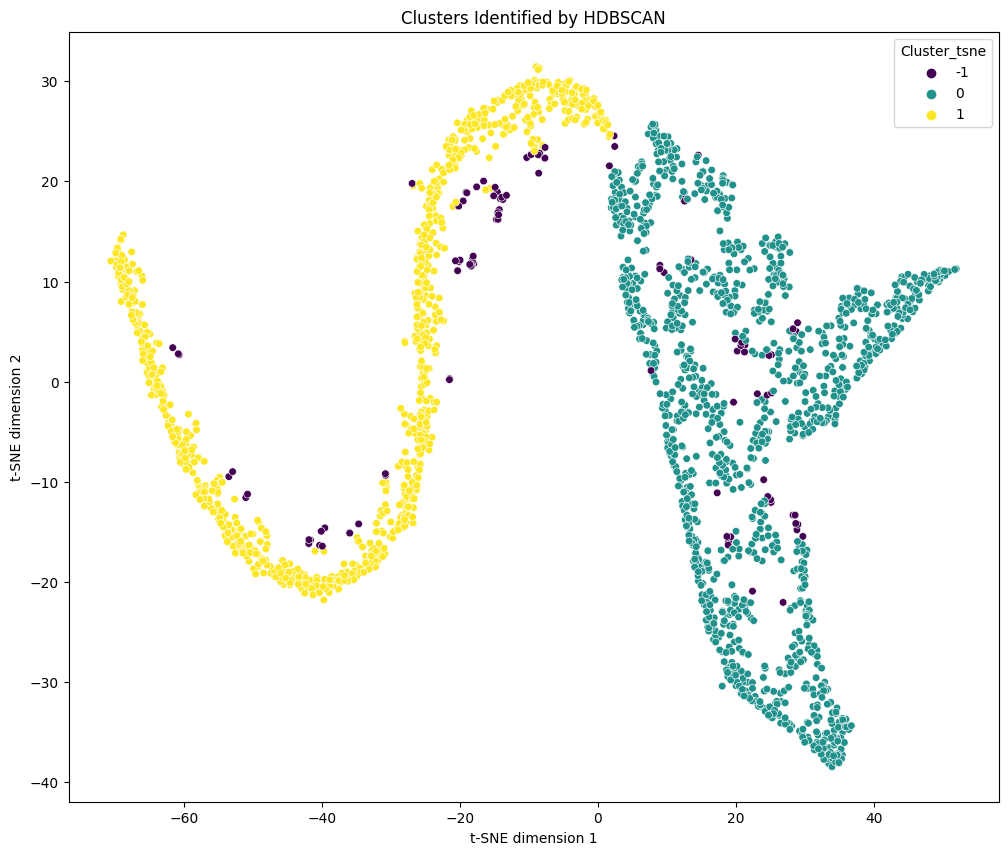

In [ ]:
# @title ##Identify clusters using HDBSCAN
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#@markdown ###HDBSCAN parameters:
clustering_data_source = 'tsne'  # @param ['tsne', 'raw']
min_samples = 20  # @param {type: "number"}
min_cluster_size = 200  # @param {type: "number"}
metric = "euclidean"  # @param ['euclidean', 'manhattan', 'chebyshev', 'braycurtis', 'canberra']

#@markdown ###Display parameters:
spot_size = 30 # @param {type: "number"}

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric=metric)


  # Prepare the parameters dictionary
tsne_params = {
        'clustering_data_source': clustering_data_source,
        'min_samples': min_samples,
        'min_cluster_size': min_cluster_size,
        'metric': metric
    }

    # Save the parameters
params_file_path = os.path.join(Results_Folder, "Tsne/analysis_parameters.csv")
save_parameters(tsne_params, params_file_path, 'tsne')

# Depending on the data source, we fit HDBSCAN to the t-SNE dimensions or the raw data
if clustering_data_source == 'tsne':
    # We only have two t-SNE dimensions based on the previous t-SNE code provided
    clusterer.fit(tsne_df[['t-SNE dimension 1', 't-SNE dimension 2']])
else:
    # If raw data is selected, we use all the numerical columns for clustering
    clusterer.fit(selected_df.select_dtypes(include=['number']))

# Add the cluster labels to your t-SNE DataFrame
tsne_df['Cluster_tsne'] = clusterer.labels_

# If the Cluster column already exists in merged_tracks_df, drop it to avoid duplications
if 'Cluster_tsne' in merged_tracks_df.columns:
    merged_tracks_df.drop(columns='Cluster_tsne', inplace=True)

# Merge the Cluster column from tsne_df to merged_tracks_df based on Unique_ID
merged_tracks_df = pd.merge(merged_tracks_df, tsne_df[['Unique_ID', 'Cluster_tsne']], on='Unique_ID', how='left')

# Handle cases where some rows in merged_tracks_df might not have a corresponding cluster label
merged_tracks_df['Cluster_tsne'].fillna(-1, inplace=True)  # Assigning -1 to cells that were not assigned to any cluster

# Save the DataFrame with the identified clusters
save_dataframe_with_progress(merged_tracks_df, Results_Folder + '/' + 'merged_Tracks.csv')

# Plotting the results
plt.figure(figsize=(12, 10))
sns.scatterplot(x='t-SNE dimension 1', y='t-SNE dimension 2', hue='Cluster_tsne', palette='viridis', data=tsne_df, s=spot_size)
plt.title('Clusters Identified by HDBSCAN')
plt.savefig(os.path.join(Results_Folder, 'Tsne', 'HDBSCAN_clusters_2D.pdf'))  # Save 2D plot as PDF
plt.show()


## **6.4 Fingerprint**
---

<font size = 4>This section is designed to visualize the distribution of different clusters within each condition in a dataset, showing the 'fingerprint' of each cluster per condition.

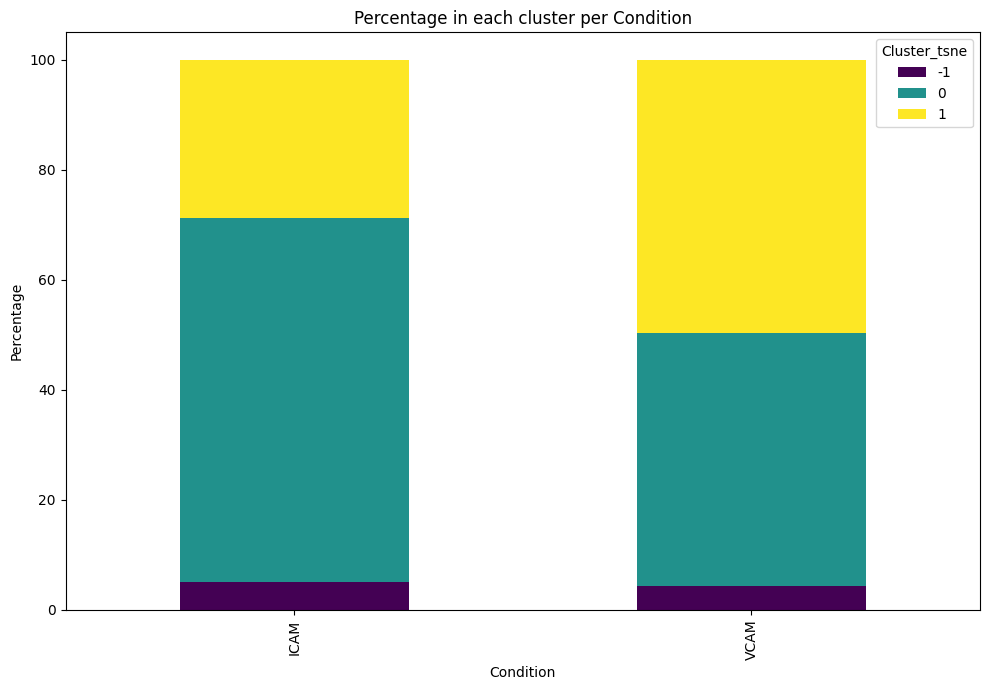

In [ ]:
# @title ##Plot the 'fingerprint' of each cluster per condition

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Group by 'Condition' and 'Cluster' and calculate the size of each group
cluster_counts = tsne_df.groupby(['Condition', 'Cluster_tsne']).size().reset_index(name='counts')

# Calculate the total number of points per condition
total_counts = tsne_df.groupby('Condition').size().reset_index(name='total_counts')

# Merge the DataFrames on 'Condition' to calculate percentages
percentage_df = pd.merge(cluster_counts, total_counts, on='Condition')
percentage_df['percentage'] = (percentage_df['counts'] / percentage_df['total_counts']) * 100

# Save the percentage_df DataFrame as a CSV file
percentage_df.to_csv(os.path.join(Results_Folder, 'Tsne', 'TSNE_percentage_results.csv'), index=False)

# Pivot the percentage_df to have Conditions as index, Clusters as columns, and percentages as values
pivot_df = percentage_df.pivot(index='Condition', columns='Cluster_tsne', values='percentage')

# Fill NaN values with 0 if any, as there might be some Condition-Cluster combinations that are not present
pivot_df.fillna(0, inplace=True)

# Initialize PDF
pdf_path = os.path.join(Results_Folder, 'Tsne', 'TSNE_Cluster_Fingerprint_Plot.pdf')
pdf_pages = PdfPages(pdf_path)

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))
pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
plt.title('Percentage in each cluster per Condition')
plt.ylabel('Percentage')
plt.xlabel('Condition')
plt.xticks(rotation=90)
plt.tight_layout()

# Save the figure to a PDF
pdf_pages.savefig(fig)

# Close the PDF
pdf_pages.close()

# Display the plot
plt.show()


## **6.5. Understand your clusters using heatmaps**
--------
<font size = 4>This section help visualize how different track parameters vary across the identified clusters. The approach is to display these variations using a heatmap, which offers a color-coded representation of the median values of each parameter for each cluster. This visualization technique can make it easier to spot differences or patterns among the clusters.


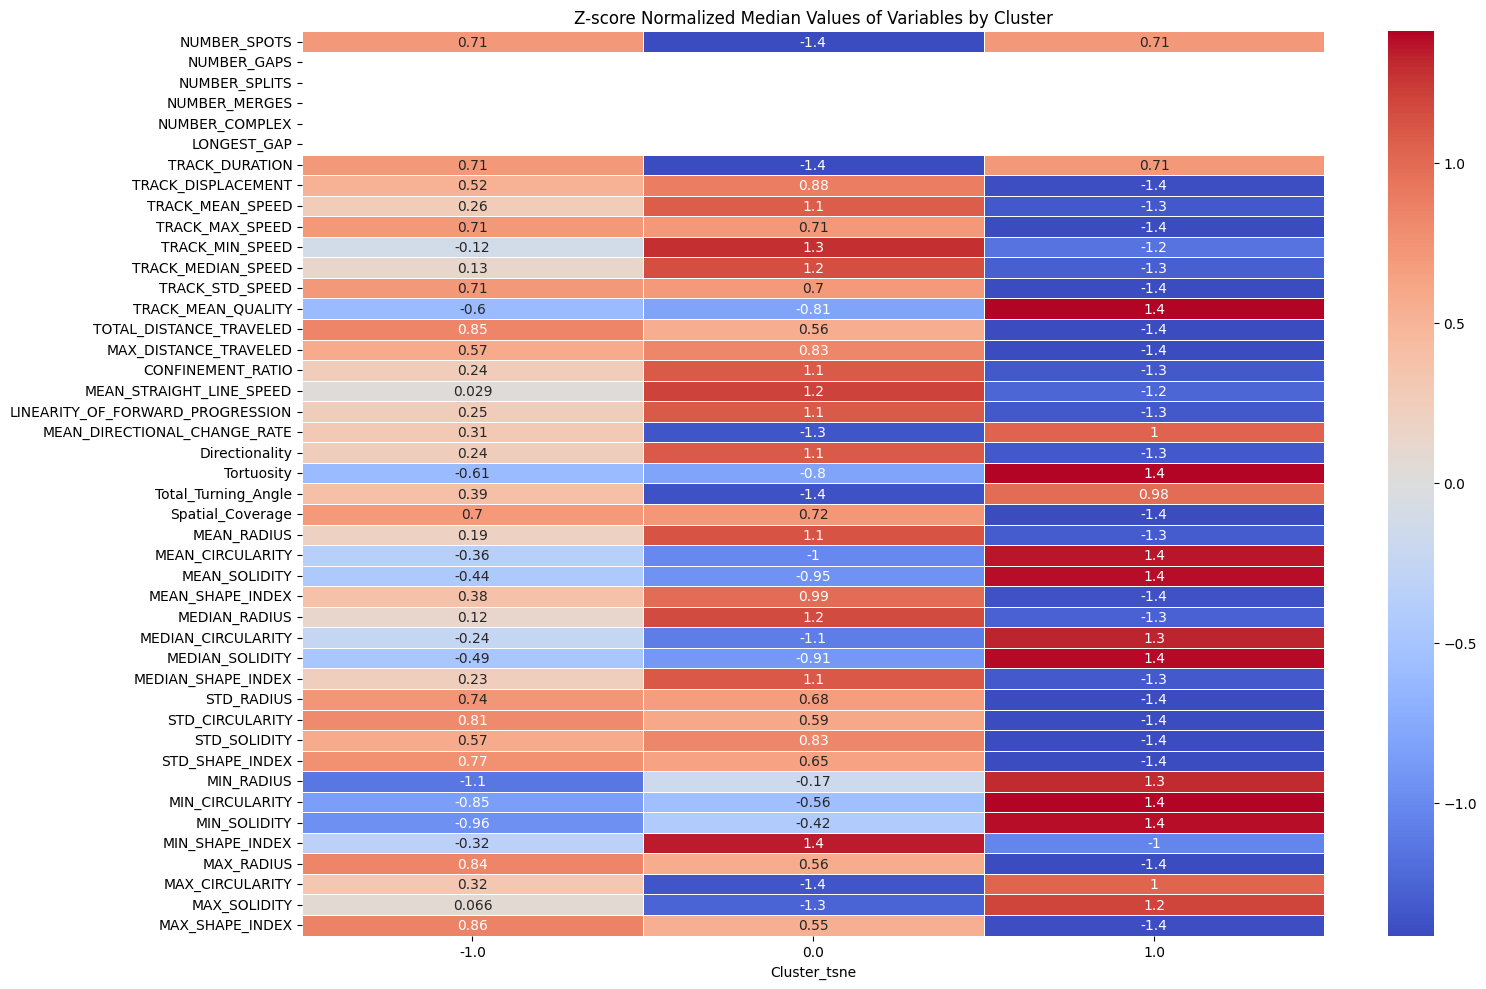

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import pandas as pd

# @title ##Plot track normalized track parameters based on clusters as a heatmap

# Create "Tsne/Track_parameters" directory if it doesn't exist
tsne_track_parameters_path = os.path.join(Results_Folder, 'Tsne', 'Track_parameters')
os.makedirs(tsne_track_parameters_path, exist_ok=True)

def get_selectable_columns(df):
    # Exclude certain columns from being plotted
    exclude_cols = ['Condition', 'experiment_nb', 'File_name', 'Repeat', 'Unique_ID', 'LABEL', 'TRACK_INDEX', 'TRACK_ID', 'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION', 'Exemplar','TRACK_STOP', 'TRACK_START', 'Cluster_UMAP', 'Cluster_tsne']
    return [col for col in df.columns if col not in exclude_cols]

def heatmap_comparison(df, Results_Folder):
    # Get all the selectable columns
    variables_to_plot = get_selectable_columns(df)

    # Drop rows where all elements are NaNs in the variables_to_plot columns
    df = df.dropna()

    # Compute median for each variable across clusters
    median_values = df.groupby('Cluster_tsne')[variables_to_plot].median().transpose()

    # Normalize the median values using Z-score
    normalized_values = median_values.apply(zscore, axis=1)

    # Plot the heatmap
    plt.figure(figsize=(16, 10))
    sns.heatmap(normalized_values, cmap='coolwarm', annot=True, linewidths=.5)
    plt.title("Z-score Normalized Median Values of Variables by Cluster")
    plt.tight_layout()

    # Save the heatmap to PDF
    heatmap_pdf_path = os.path.join(tsne_track_parameters_path, 'Heatmap_Normalized_Median_Values_by_Cluster.pdf')
    plt.savefig(heatmap_pdf_path)
    plt.show()

    # Save the normalized median values data to CSV
    normalized_values_csv_path = os.path.join(tsne_track_parameters_path, 'Normalized_Median_Values_by_Cluster.csv')
    normalized_values.to_csv(normalized_values_csv_path)

# Plot the heatmap directly
heatmap_comparison(merged_tracks_df, Results_Folder)


## **6.6. Understand your clusters using box plots**
--------
<font size = 4>The provided code aims to visually represent the distribution of different track parameters across the identified clusters. Specifically, for each parameter selected, a boxplot is generated to showcase the spread of its values across different clusters. This approach provides a comprehensive view of how each track parameter varies within and across the clusters.




In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets

# @title ##Plot track parameters based on clusters

# Define paths for Tsne
tsne_track_parameters_path = os.path.join(Results_Folder, 'Tsne', 'Track_parameters')
os.makedirs(tsne_track_parameters_path, exist_ok=True)

def get_selectable_columns(df):
    # Exclude certain columns from being plotted
    exclude_cols = ['Condition', 'experiment_nb', 'File_name', 'Repeat', 'Unique_ID', 'LABEL', 'TRACK_INDEX', 'TRACK_ID', 'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION', 'Exemplar','TRACK_STOP', 'TRACK_START', 'Cluster_UMAP', 'Cluster_tsne']
    return [col for col in df.columns if col not in exclude_cols]

def display_variable_checkboxes(selectable_columns):
    # Create checkboxes for selectable columns
    variable_checkboxes = [widgets.Checkbox(value=False, description=col) for col in selectable_columns]

    # Display checkboxes in the notebook
    display(widgets.VBox([
        widgets.Label('Variables to Plot:'),
        widgets.GridBox(variable_checkboxes, layout=widgets.Layout(grid_template_columns="repeat(3, 300px)")),
    ]))
    return variable_checkboxes

def plot_selected_vars(button, variable_checkboxes, df, Results_Folder):
    print("Plotting in progress...")

    # Get selected variables
    variables_to_plot = [box.description for box in variable_checkboxes if box.value]
    n_plots = len(variables_to_plot)

    if n_plots == 0:
        print("No variables selected for plotting")
        return

    for var in variables_to_plot:
        # Extract data for the specific variable and cluster
        data_to_save = df[['Cluster_tsne', var]]

        # Save data for the plot to CSV
        data_to_save.to_csv(os.path.join(tsne_track_parameters_path, f"{var}_data_by_Cluster.csv"), index=False)

        plt.figure(figsize=(16, 10))

        # Plotting
        sns.boxplot(x='Cluster_tsne', y=var, data=df, color='lightgray')  # Boxplot by cluster
        sns.stripplot(x='Cluster_tsne', y=var, data=df, jitter=True, alpha=0.2)  # Individual data points

        plt.title(f"{var} by Cluster")
        plt.xlabel('Cluster')
        plt.ylabel(var)
        plt.xticks(rotation=90)
        plt.tight_layout()

        # Save the plot to PDF
        plt.savefig(os.path.join(tsne_track_parameters_path, f"{var}_Boxplots_by_Cluster.pdf"))
        plt.show()

selectable_columns = get_selectable_columns(merged_tracks_df)
variable_checkboxes = display_variable_checkboxes(selectable_columns)

# Create and display the plot button
button = widgets.Button(description="Plot Selected Variables", layout=widgets.Layout(width='400px'), button_style='info')
button.on_click(lambda b: plot_selected_vars(b, variable_checkboxes, merged_tracks_df, Results_Folder))
display(button)


## **6.7 Plot track parameters for a selected cluster**
---

In [ ]:
# @title ##Plot track parameters for a selected cluster


# Check and create "cluster_plots" folder
if not os.path.exists(f"{Results_Folder}/Tsne/cluster_plots"):
    os.makedirs(f"{Results_Folder}/Tsne/cluster_plots")

# Check and create "pdf" folder
if not os.path.exists(f"{Results_Folder}/Tsne/cluster_plots/pdf"):
    os.makedirs(f"{Results_Folder}/Tsne/cluster_plots/pdf")

# Check and create "csv" folder
if not os.path.exists(f"{Results_Folder}/Tsne/cluster_plots/csv"):
    os.makedirs(f"{Results_Folder}/Tsne/cluster_plots/csv")

def get_selectable_columns(df):
    # Exclude certain columns from being plotted
    exclude_cols = ['Condition', 'experiment_nb', 'File_name', 'Repeat', 'Unique_ID', 'LABEL', 'TRACK_INDEX', 'TRACK_ID', 'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'Cluster_tsne', 'TRACK_Z_LOCATION']
    return [col for col in df.columns if col not in exclude_cols]


def display_cluster_dropdown(df):
    # Extract unique clusters
    unique_clusters = df['Cluster_tsne'].unique()
    cluster_dropdown = widgets.Dropdown(
        options=unique_clusters,
        description='Select Cluster:',
        disabled=False,
    )
    display(cluster_dropdown)
    return cluster_dropdown

def display_variable_checkboxes(selectable_columns):
    # Create checkboxes for selectable columns
    variable_checkboxes = [widgets.Checkbox(value=False, description=col) for col in selectable_columns]

    # Display checkboxes in the notebook
    display(widgets.VBox([
        widgets.Label('Variables to Plot:'),
        widgets.GridBox(variable_checkboxes, layout=widgets.Layout(grid_template_columns="repeat(%d, 300px)" % 3)),
    ]))
    return variable_checkboxes

def plot_selected_vars(button, variable_checkboxes, cluster_dropdown, df, Results_Folder):
    selected_cluster = cluster_dropdown.value
    print(f"Plotting in progress for Cluster {selected_cluster}...")

    # Attempt to filter the dataframe for the selected cluster
    filtered_df = df[df['Cluster_tsne'] == selected_cluster]

    # Get selected variables
    variables_to_plot = [box.description for box in variable_checkboxes if box.value]
    n_plots = len(variables_to_plot)

    if n_plots == 0:
        print("No variables selected for plotting")
        return
# Initialize matrices to store effect sizes and p-values for each variable
    effect_size_matrices = {}
    p_value_matrices = {}
    bonferroni_matrices = {}

    unique_conditions = filtered_df['Condition'].unique().tolist()
    num_comparisons = len(unique_conditions) * (len(unique_conditions) - 1) // 2
    alpha = 0.05
    corrected_alpha = alpha / num_comparisons
    n_iterations = 1000

# Loop through each variable to plot
    for var in variables_to_plot:

      pdf_pages = PdfPages(f"{Results_Folder}/Tsne/cluster_plots/pdf/Cluster_{selected_cluster}_{var}_Boxplots_and_Statistics.pdf")
      effect_size_matrix = pd.DataFrame(index=unique_conditions, columns=unique_conditions)
      p_value_matrix = pd.DataFrame(index=unique_conditions, columns=unique_conditions)
      bonferroni_matrix = pd.DataFrame(index=unique_conditions, columns=unique_conditions)

      for cond1, cond2 in itertools.combinations(unique_conditions, 2):
        group1 = filtered_df[filtered_df['Condition'] == cond1][var]
        group2 = filtered_df[filtered_df['Condition'] == cond2][var]

        original_d = cohen_d(group1, group2)
        effect_size_matrix.loc[cond1, cond2] = original_d
        effect_size_matrix.loc[cond2, cond1] = original_d  # Mirroring

        count_extreme = 0
        for i in range(n_iterations):
            combined = pd.concat([group1, group2])
            shuffled = combined.sample(frac=1, replace=False).reset_index(drop=True)
            new_group1 = shuffled[:len(group1)]
            new_group2 = shuffled[len(group1):]

            new_d = cohen_d(new_group1, new_group2)
            if np.abs(new_d) >= np.abs(original_d):
                count_extreme += 1

        p_value = count_extreme / n_iterations
        p_value_matrix.loc[cond1, cond2] = p_value
        p_value_matrix.loc[cond2, cond1] = p_value  # Mirroring

        # Apply Bonferroni correction
        bonferroni_corrected_p_value = min(p_value * num_comparisons, 1.0)
        bonferroni_matrix.loc[cond1, cond2] = bonferroni_corrected_p_value
        bonferroni_matrix.loc[cond2, cond1] = bonferroni_corrected_p_value  # Mirroring

      effect_size_matrices[var] = effect_size_matrix
      p_value_matrices[var] = p_value_matrix
      bonferroni_matrices[var] = bonferroni_matrix

    # Concatenate the three matrices side-by-side
      combined_df = pd.concat(
        [
            effect_size_matrices[var].rename(columns={col: f"{col} (Effect Size)" for col in effect_size_matrices[var].columns}),
            p_value_matrices[var].rename(columns={col: f"{col} (P-Value)" for col in p_value_matrices[var].columns}),
            bonferroni_matrices[var].rename(columns={col: f"{col} (Bonferroni-corrected P-Value)" for col in bonferroni_matrices[var].columns})
        ], axis=1
    )

    # Save the combined DataFrame to a CSV file
      combined_df.to_csv(f"{Results_Folder}/Tsne/cluster_plots/csv/Cluster_{selected_cluster}_{var}_statistics_combined.csv")

    # Create a new figure
      fig = plt.figure(figsize=(16, 10))

    # Create a gridspec for 2 rows and 4 columns
      gs = GridSpec(2, 3, height_ratios=[1.5, 1])

    # Create the ax for boxplot using the gridspec
      ax_box = fig.add_subplot(gs[0, :])

    # Extract the data for this variable
      data_for_var = filtered_df[['Condition', var, 'Repeat', 'File_name', 'Cluster_tsne']]

    # Save the data_for_var to a CSV for replotting
      data_for_var.to_csv(f"{Results_Folder}/Tsne/cluster_plots/csv/Cluster_{selected_cluster}_{var}_boxplot_data.csv", index=False)

    # Calculate the Interquartile Range (IQR) using the 25th and 75th percentiles
      Q1 = filtered_df[var].quantile(0.25)
      Q3 = filtered_df[var].quantile(0.75)
      IQR = Q3 - Q1

    # Define bounds for the outliers
      multiplier = 10
      lower_bound = Q1 - multiplier * IQR
      upper_bound = Q3 + multiplier * IQR

    # Plotting
      sns.boxplot(x='Condition', y=var, data=filtered_df, ax=ax_box, color='lightgray')  # Boxplot
      sns.stripplot(x='Condition', y=var, data=filtered_df, ax=ax_box, hue='Repeat', dodge=True, jitter=True, alpha=0.2)  # Individual data points
      ax_box.set_ylim([max(min(filtered_df[var]), lower_bound), min(max(filtered_df[var]), upper_bound)])
      ax_box.set_title(f"{var} for Cluster {selected_cluster}")
      ax_box.set_xlabel('Condition')
      ax_box.set_ylabel(var)
      ax_box.set_xticklabels(ax_box.get_xticklabels(), rotation=90)
      ax_box.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Repeat')

    # Statistical Analyses and Heatmaps

    # Effect Size heatmap ax
      ax_d = fig.add_subplot(gs[1, 0])
      sns.heatmap(effect_size_matrices[var].fillna(0), annot=True, cmap="coolwarm", cbar=True, square=True, ax=ax_d)
      ax_d.set_title(f"Effect Size (Cohen's d) for {var}")

    # p-value heatmap ax
      ax_p = fig.add_subplot(gs[1, 1])
      sns.heatmap(p_value_matrices[var].fillna(1), annot=True, cmap="viridis_r", cbar=True, square=True, ax=ax_p, vmax=0.1)
      ax_p.set_title(f"Randomization Test p-value for {var}")

    # Bonferroni corrected p-value heatmap ax
      ax_bonf = fig.add_subplot(gs[1, 2])
      sns.heatmap(bonferroni_matrices[var].fillna(1), annot=True, cmap="viridis_r", cbar=True, square=True, ax=ax_bonf, vmax=0.1)
      ax_bonf.set_title(f"Bonferroni-corrected p-value for {var}")

      plt.tight_layout()
      pdf_pages.savefig(fig)

    # Close the PDF
      pdf_pages.close()

selectable_columns = get_selectable_columns(merged_tracks_df)
variable_checkboxes = display_variable_checkboxes(selectable_columns)
cluster_dropdown = display_cluster_dropdown(merged_tracks_df)

#merged_tracks_df = merged_tracks_df.dropna

# Create and display the plot button
button = widgets.Button(description="Plot Selected Variables", layout=widgets.Layout(width='400px'), button_style='info')
button.on_click(lambda b: plot_selected_vars(b, variable_checkboxes, cluster_dropdown, merged_tracks_df, Results_Folder))
display(button)

Dropdown(description='Select Cluster:', options=(1.0, 0.0, -1.0), value=1.0)

Button(button_style='info', description='Plot Selected Variables', layout=Layout(width='400px'), style=ButtonS…

# **Part 7. Version log**
---
<font size = 4>While I strive to provide accurate and helpful information, please be aware that:
  - This notebook may contain bugs.
  - Features are currently limited and will be expanded in future releases.

<font size = 4>We encourage users to report any issues or suggestions for improvement. Please check the [repository](https://github.com/guijacquemet/CellTracksColab) regularly for updates and the latest version of this notebook.

#### **Known Issues**:
- Tracks are displayed in 2D in section 1.4

<font size = 4>**Version 0.8**
  - Settings are now saved
  - Order of the section has been modified to help streamline biological discoveries
  - New section added to quality Control to check if the dataset is balanced
  - New section added to the UMAP and tsne section to plot track parameters for selected clusters
  - clusters for UMAP and t-sne are now saved in the dataframe separetly

<font size = 4>**Version 0.7**
  - check_for_nans function added
  - Clustering using t-SNE added

<font size = 4>**Version 0.6**
  - Improved organisation of the results
  - Tracks visualisation are now saved

<font size = 4>**Version 0.5**
  - Improved part 5
  - Added the possibility to find examplar on the raw movies when available
  - Added the possibility to export video with the examplar labeled
  - Code improved to deal with larger dataset (tested with over 50k tracks)
  - test dataset now contains raw video and is hosted on Zenodo
  - Results are now organised in folders
  - Added progress bars
  - Minor code fixes

<font size = 4>**Version 0.4**

  - Added the possibility to filter and smooth tracks
  - Added spatial and temporal calibration
  - Notebook is streamlined
  - multiple bug fix
  - Remove the t-sne
  - Improved documentation

<font size = 4>**Version 0.3**
  - Fix a nasty bug in the import functions
  - Add basic examplar for UMAP
  - Added the statistical analyses and their explanations.
  - Added a new quality control part that helps assessing the similarity of results between FOV, conditions and repeats
  - Improved part 5 (previously part 4).

<font size = 4>**Version 0.2**
  - Added support for 3D tracks
  - New documentation and metrics added.

<font size = 4>**Version 0.1**
This is the first release of this notebook.

---